# Surface type distinctions: comparison of different types using constant or random mass balance runs

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import scipy
import scipy.stats as stats
import os
import oggm
from oggm import cfg, utils, workflow, tasks, graphics, entity_task
from oggm.core import massbalance, flowline, climate
from oggm.utils import (floatyear_to_date, date_to_floatyear)

# just for the graphics
SMALL_SIZE = 22
MEDIUM_SIZE = 24
BIGGER_SIZE = 26

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


# import the MSsandbox modules
from MBsandbox.mbmod_daily_oneflowline import MultipleFlowlineMassBalance_TIModel
from MBsandbox.mbmod_daily_oneflowline import process_w5e5_data, process_era5_daily_data, TIModel, TIModel_Sfc_Type, BASENAMES
# from MBsandbox.help_func import compute_stat, minimize_bias, optimize_std_quot_brentq
from MBsandbox.help_func import minimize_bias_geodetic, optimize_std_quot_brentq_geod, melt_f_calib_geod_prep_inversion
from MBsandbox.flowline_TIModel import (run_from_climate_data_TIModel, run_constant_climate_TIModel,
                                        run_random_climate_TIModel)
from MBsandbox.wip.projections_bayescalibration import process_isimip_data
cfg.initialize(logging_level='CRITICAL')
cfg.PARAMS['use_multiprocessing'] = True
cfg.PARAMS['continue_on_error'] = False

working_dir = utils.gettempdir(dirname='OGGM_hydro', reset=False)

cfg.PATHS['working_dir'] = working_dir
# use elevation band  flowlines
base_url = ('https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/'
            'L1-L2_files/elev_bands')

# as we calibrate to geodetic estimates we use calendar years!  
# need to check if this works in southern hemisphere
cfg.PARAMS['hydro_month_nh'] = 1


# get the geodetic calibration data
pd_geodetic = utils.get_geodetic_mb_dataframe()
pd_geodetic = pd_geodetic_all.loc[pd_geodetic_all.period == '2000-01-01_2020-01-01']


In [2]:
#df = ['RGI60-11.00890', 
#df = ['RGI60-11.00897'] # list of glaciers -> can be longer ... 
df = ['RGI60-11.01450'] # list of glaciers -> can be longer ... 

# this has to be done just once for a region (basin) (independent of climate, mb_type, prcp-fac ... )
init = True
if init:
    gdirs = workflow.init_glacier_directories(df, from_prepro_level=2,
                                              prepro_border=80,
                                              prepro_base_url=base_url,
                                              prepro_rgi_version='62')
    workflow.execute_entity_task(tasks.compute_downstream_line, gdirs)
    workflow.execute_entity_task(tasks.compute_downstream_bedshape, gdirs)
else:
    gdirs = workflow.init_glacier_directories(df)

In [4]:
# if you have a precipitation factor from the hydrological model you can change it here
pf = 2  # we set the precipitation factor here to 1
climate_type = 'W5E5' #W5E5 # 'WFDE5_CRU'
#climate_type='WFDE5_CRU' -> need to use other pf and temp_bias ... 
#mb_type = 'mb_real_daily' #real daily input, this would be monthly input:'mb_monthly' #'mb_real_daily' # 'mb_monthly'#
mb_type = 'mb_monthly'
#grad_type ='var_an_cycle' # variable lapse rates
grad_type = 'cte'
ensemble = 'mri-esm2-0_r1i1p1f1'
ssp = 'ssp126'
dataset = climate_type

In [5]:
# this has to be done once for each climate, mb_type, grad_type, pf option,
# then you can save the melt_f and a-factor for the runs later on 

if climate_type =='W5E5' or climate_type == 'W5E5_MSWEP':
    ye=2020 # till end of 2019
else:
    ye=2019
    
if mb_type == 'mb_real_daily':
    temporal_resol = 'daily'
else:
    temporal_resol = 'monthly'

# get the climate data (either w5e5 or WFDE5_CRU)
workflow.execute_entity_task(process_w5e5_data, gdirs,
                             temporal_resol=temporal_resol, climate_type=climate_type)
workflow.execute_entity_task(process_w5e5_data, gdirs,
                             temporal_resol='daily', climate_type=climate_type)
workflow.execute_entity_task(process_isimip_data, gdirs, ensemble = ensemble,
                             ssp = ssp, temporal_resol =temporal_resol,
                              climate_historical_filesuffix='_{}_{}'.format(temporal_resol, dataset) );
workflow.execute_entity_task(process_isimip_data, gdirs, ensemble = ensemble,
                             ssp = ssp, temporal_resol = 'daily',
                              climate_historical_filesuffix='_{}_{}'.format('daily', dataset) );

from MBsandbox.help_func import calib_inv_run

# test constant mass balance

In [6]:
nyears=100
ds_default_random_TIModel={}
ds_default_random_ratio1={}
ds_linear_an_random={}
ds_neg_exp_an_random_1={}
ds_neg_exp_an_random_2={}
melt_f_default_random_TIModel={}
melt_f_default_random_ratio1={}
melt_f_linear_an_random={}
melt_f_neg_exp_an_random_1={}
melt_f_neg_exp_an_random_2={}
melt_f_update= 'annual'#'monthly' 
# or 
# melt_f_update='annual'
run_type = 'constant' # or
interpolation_optim = True
y0 = 2004
hs = 10

In [7]:
melt_f_update= 'monthly'#'monthly' 

In [11]:
mb_type = 'mb_monthly'
grad_type = 'cte'
pf = 1.5
typ = f'{mb_type}_{grad_type}_pf_{pf}_melt_f_update_{melt_f_update}'
ds_default_random_TIModel[typ], melt_f_default_random_TIModel[typ],_ = calib_inv_run(gdir=gdirs[-1],mb_model_sub_class = TIModel,
                                                                  mb_elev_feedback = 'annual',mb_type=mb_type, grad_type=grad_type, pf=pf,
                                                                  nyears=nyears,
                                                                         run_type = run_type, interpolation_optim=interpolation_optim, y0=y0, hs=hs)
ds_neg_exp_an_random_2[typ], melt_f_neg_exp_an_random_2[typ],_ = calib_inv_run(gdir=gdirs[-1], kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'neg_exp',
                                                                 'tau_e_fold_yr':2,
                                                                 'spinup_yrs':6,
                                                                 'melt_f_update':melt_f_update,
                                           'melt_f_ratio_snow_to_ice':0.5},
                                  mb_elev_feedback = 'annual',run_type = run_type, mb_type=mb_type, grad_type=grad_type, pf=pf, interpolation_optim=interpolation_optim, y0=y0, hs=hs,
                                 nyears=nyears,
                                 spinup=True)

In [12]:
ds_neg_exp_an_random_2[typ]

<xarray.Dataset>
Dimensions:         (rgi_id: 1, time: 101)
Coordinates:
  * time            (time) float64 0.0 1.0 2.0 3.0 4.0 ... 97.0 98.0 99.0 100.0
  * rgi_id          (rgi_id) <U14 'RGI60-11.01450'
    hydro_year      (time) int64 0 1 2 3 4 5 6 7 8 ... 93 94 95 96 97 98 99 100
    hydro_month     (time) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    calendar_year   (time) int64 0 1 2 3 4 5 6 7 8 ... 93 94 95 96 97 98 99 100
    calendar_month  (time) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
Data variables:
    volume          (time, rgi_id) float64 1.375e+10 1.37e+10 ... 1.129e+10
    volume_bsl      (time, rgi_id) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    volume_bwl      (time, rgi_id) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    area            (time, rgi_id) float64 8.221e+07 8.218e+07 ... 7.709e+07
    length          (time, rgi_id) float64 1.891e+04 1.918e+04 ... 1.507e+04
    calving         (time, rgi_id) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    calving_rate    (time, rgi_id) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    water_level     (rgi_id) float64 0.0
    glen_a          (rgi_id) float64 4.358e-24
    fs              (rgi_id) float64 0.0
Attributes:
    description:    OGGM model output
    oggm_version:   1.3.2.dev171+g11819f5
    calendar:       365-day no leap
    creation_date:  2021-10-27 07:49:43

NameError: name 'fs' is not defined

In [23]:
#run_type = 'random'
#for mb_type in ['mb_monthly', 'mb_pseudo_daily', 'mb_real_daily']:
for mb_type in ['mb_monthly', 'mb_pseudo_daily', 'mb_real_daily']:
    for grad_type in ['cte', 'var_an_cycle']:
        for pf in [1.5, 2.5]:
            typ = f'{mb_type}_{grad_type}_pf_{pf}_melt_f_update_{melt_f_update}'
            ds_default_random_TIModel[typ], melt_f_default_random_TIModel[typ],_ = calib_inv_run(gdir=gdirs[-1],mb_model_sub_class = TIModel,
                                                                  mb_elev_feedback = 'annual',mb_type=mb_type, grad_type=grad_type, pf=pf,
                                                                  nyears=nyears,
                                                                         run_type = run_type, interpolation_optim=interpolation_optim, y0=y0, hs=hs)

            ds_default_random_ratio1[typ], melt_f_default_random_ratio1[typ],_ = calib_inv_run(gdir=gdirs[-1],kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'linear', 'tau_e_fold_yr':20,
                                                                 'spinup_yrs':6,
                                                                 'melt_f_update':melt_f_update, 
                                                                 'melt_f_ratio_snow_to_ice':1},
                                                                  mb_elev_feedback = 'annual',
                                                                  nyears=nyears,mb_type=mb_type, grad_type=grad_type, pf=pf, interpolation_optim=interpolation_optim, y0=y0, hs=hs,
                                                                         run_type = run_type)

            ds_linear_an_random[typ], melt_f_linear_an_random[typ],_ = calib_inv_run(gdir=gdirs[-1],kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'linear',
                                                                 'tau_e_fold_yr':1,
                                                                 'spinup_yrs':6,
                                                                 'melt_f_update':melt_f_update, 
                                           'melt_f_ratio_snow_to_ice':0.5},
                                  mb_elev_feedback = 'annual', run_type = run_type,mb_type=mb_type, grad_type=grad_type, pf=pf, interpolation_optim=interpolation_optim, y0=y0, hs=hs,
                                 nyears=nyears,
                                 spinup=True)
            ds_neg_exp_an_random_1[typ], melt_f_neg_exp_an_random_1[typ],_ = calib_inv_run(gdir=gdirs[-1],kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'neg_exp',
                                                                 'tau_e_fold_yr':1,
                                                                 'spinup_yrs':6,
                                                                 'melt_f_update':melt_f_update,
                                           'melt_f_ratio_snow_to_ice':0.5},
                                  mb_elev_feedback = 'annual',run_type = run_type,mb_type=mb_type, grad_type=grad_type, pf=pf, interpolation_optim=interpolation_optim, y0=y0, hs=hs,
                                 nyears=nyears,
                                 spinup=True)

            ds_neg_exp_an_random_2[typ], melt_f_neg_exp_an_random_2[typ],_ = calib_inv_run(gdir=gdirs[-1], kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'neg_exp',
                                                                 'tau_e_fold_yr':2,
                                                                 'spinup_yrs':6,
                                                                 'melt_f_update':melt_f_update,
                                           'melt_f_ratio_snow_to_ice':0.5},
                                  mb_elev_feedback = 'annual',run_type = run_type, mb_type=mb_type, grad_type=grad_type, pf=pf, interpolation_optim=interpolation_optim, y0=y0, hs=hs,
                                 nyears=nyears,
                                 spinup=True)
            print(typ)

mb_monthly_cte_pf_1.5_melt_f_update_monthly


KeyboardInterrupt: 

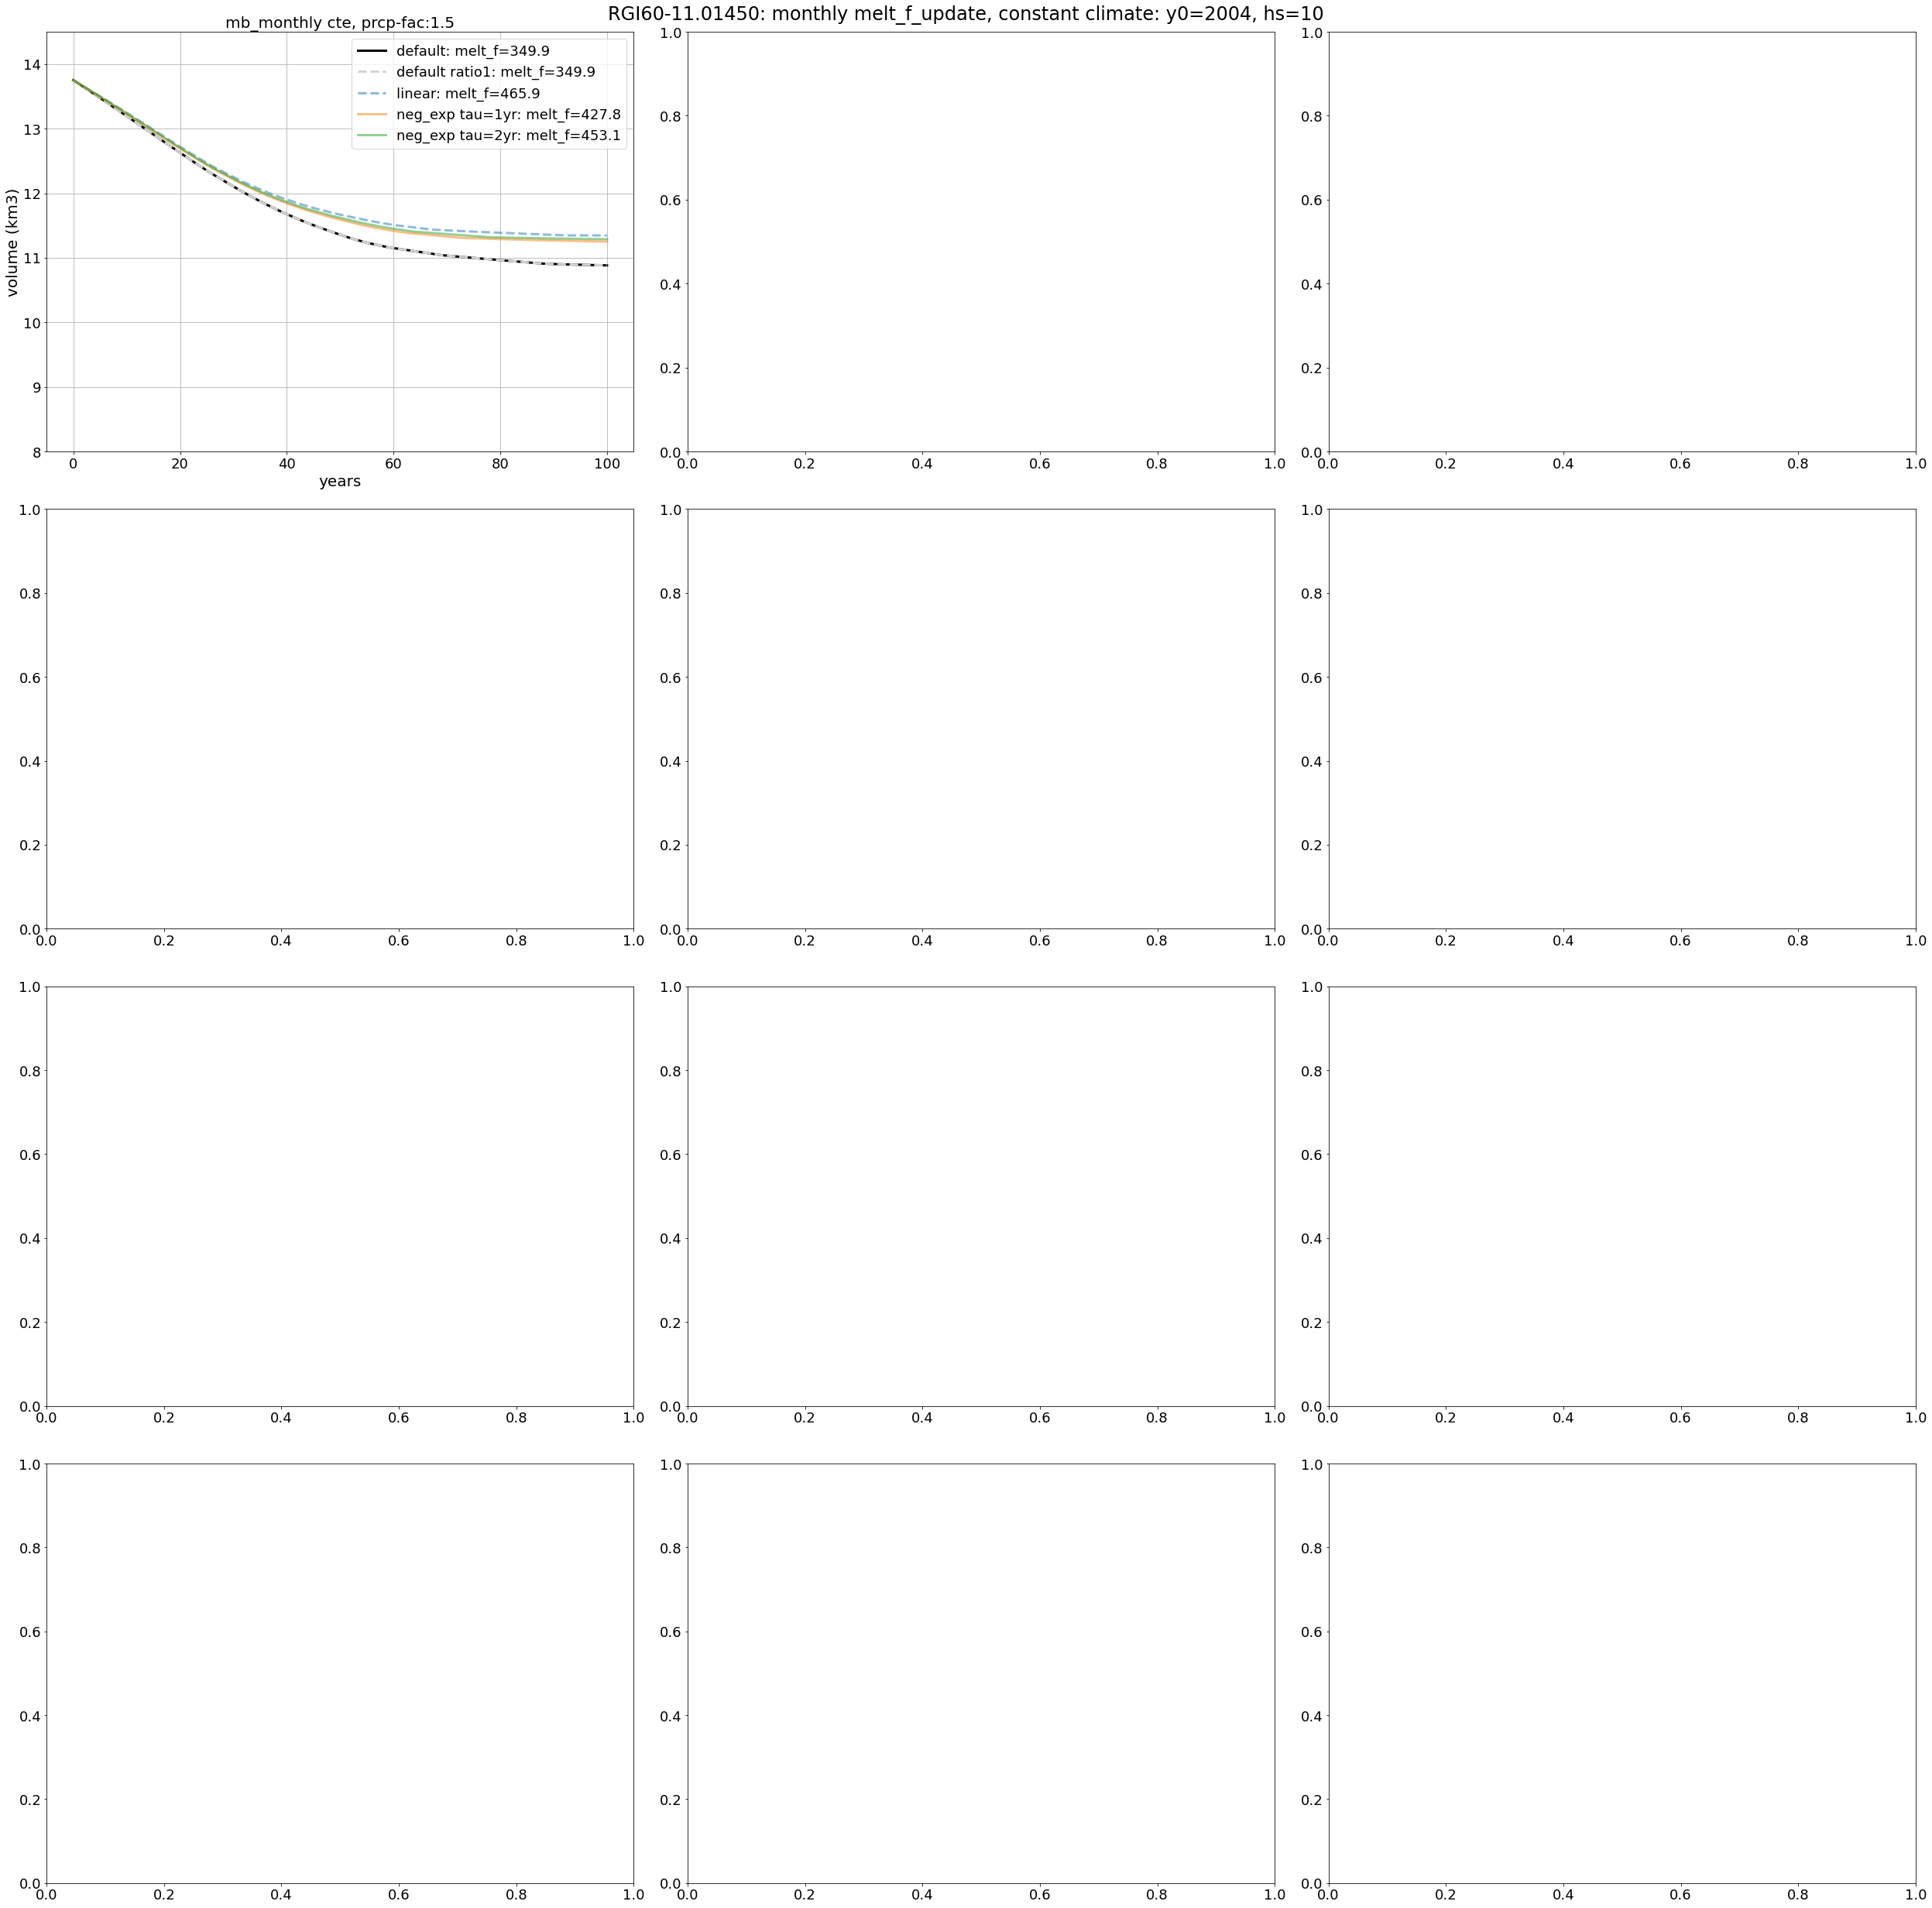

In [24]:
calendar_year = ds_default_random_TIModel[f'mb_monthly_cte_pf_1.5_melt_f_update_{melt_f_update}'].calendar_year
plt.figure(figsize=(35,35))
j=0
plt.suptitle(f'{gdirs[-1].rgi_id}: {melt_f_update} melt_f_update, {run_type} climate: y0=2004, hs=10')

for pf in [1.5, 2.5]:
    for mb_type in ['mb_monthly', 'mb_pseudo_daily', 'mb_real_daily']:
        for grad_type in ['cte', 'var_an_cycle']:
            j+=1

            try:
                typ = f'{mb_type}_{grad_type}_pf_{pf}_melt_f_update_{melt_f_update}'

                plt.subplot(4,3,j)

                plt.plot(calendar_year, ds_default_random_TIModel[typ].volume/1e9, label = 'default: melt_f={:0.1f}'.format(melt_f_default_random_TIModel[typ]), color = 'black', ls='-', lw=3, alpha = 1)
                plt.plot(calendar_year, ds_default_random_ratio1[typ].volume/1e9, label = 'default ratio1: melt_f={:0.1f}'.format(melt_f_default_random_ratio1[typ]), color = 'lightgrey', ls='--', lw=3, alpha = 1)


                plt.plot(calendar_year, ds_linear_an_random[typ].volume/1e9, label = 'linear: melt_f={:0.1f}'.format(melt_f_linear_an_random[typ]), ls = '--', lw=3, alpha = 0.5)
                plt.plot(calendar_year, ds_neg_exp_an_random_1[typ].volume/1e9, label = 'neg_exp tau=1yr: melt_f={:0.1f}'.format(melt_f_neg_exp_an_random_1[typ]), ls = '-', lw=3, alpha = 0.5)
                plt.plot(calendar_year, ds_neg_exp_an_random_2[typ].volume/1e9, label = 'neg_exp tau=2yr: melt_f={:0.1f}'.format(melt_f_neg_exp_an_random_2[typ]), ls = '-', lw=3, alpha = 0.5)


                #plt.plot(ds_linear_m_random.volume, label = 'linear_monthly_melt_f_update: melt_f={:0.1f}'.format(melt_f_linear_m_random))
                #plt.plot(ds_neg_exp_m_random_1.volume, label = 'neg_exp_monthly_melt_f_update: melt_f={:0.1f}, tau_e_fold =1'.format(melt_f_neg_exp_m_random_1))
                #plt.plot(ds_neg_exp_m_random_1_5.volume, label = 'neg_exp_monthly_melt_f_update: melt_f={:0.1f}, tau_e_fold=1.5'.format(melt_f_neg_exp_m_random_1_5))
                plt.xlabel('years')

                plt.ylabel('volume (km3)')
                plt.legend()
                plt.title(f'{mb_type} {grad_type}, prcp-fac:{pf}', fontsize=20)

                plt.ylim([8, 14.5])
                plt.grid()
            except:
                pass
plt.tight_layout()


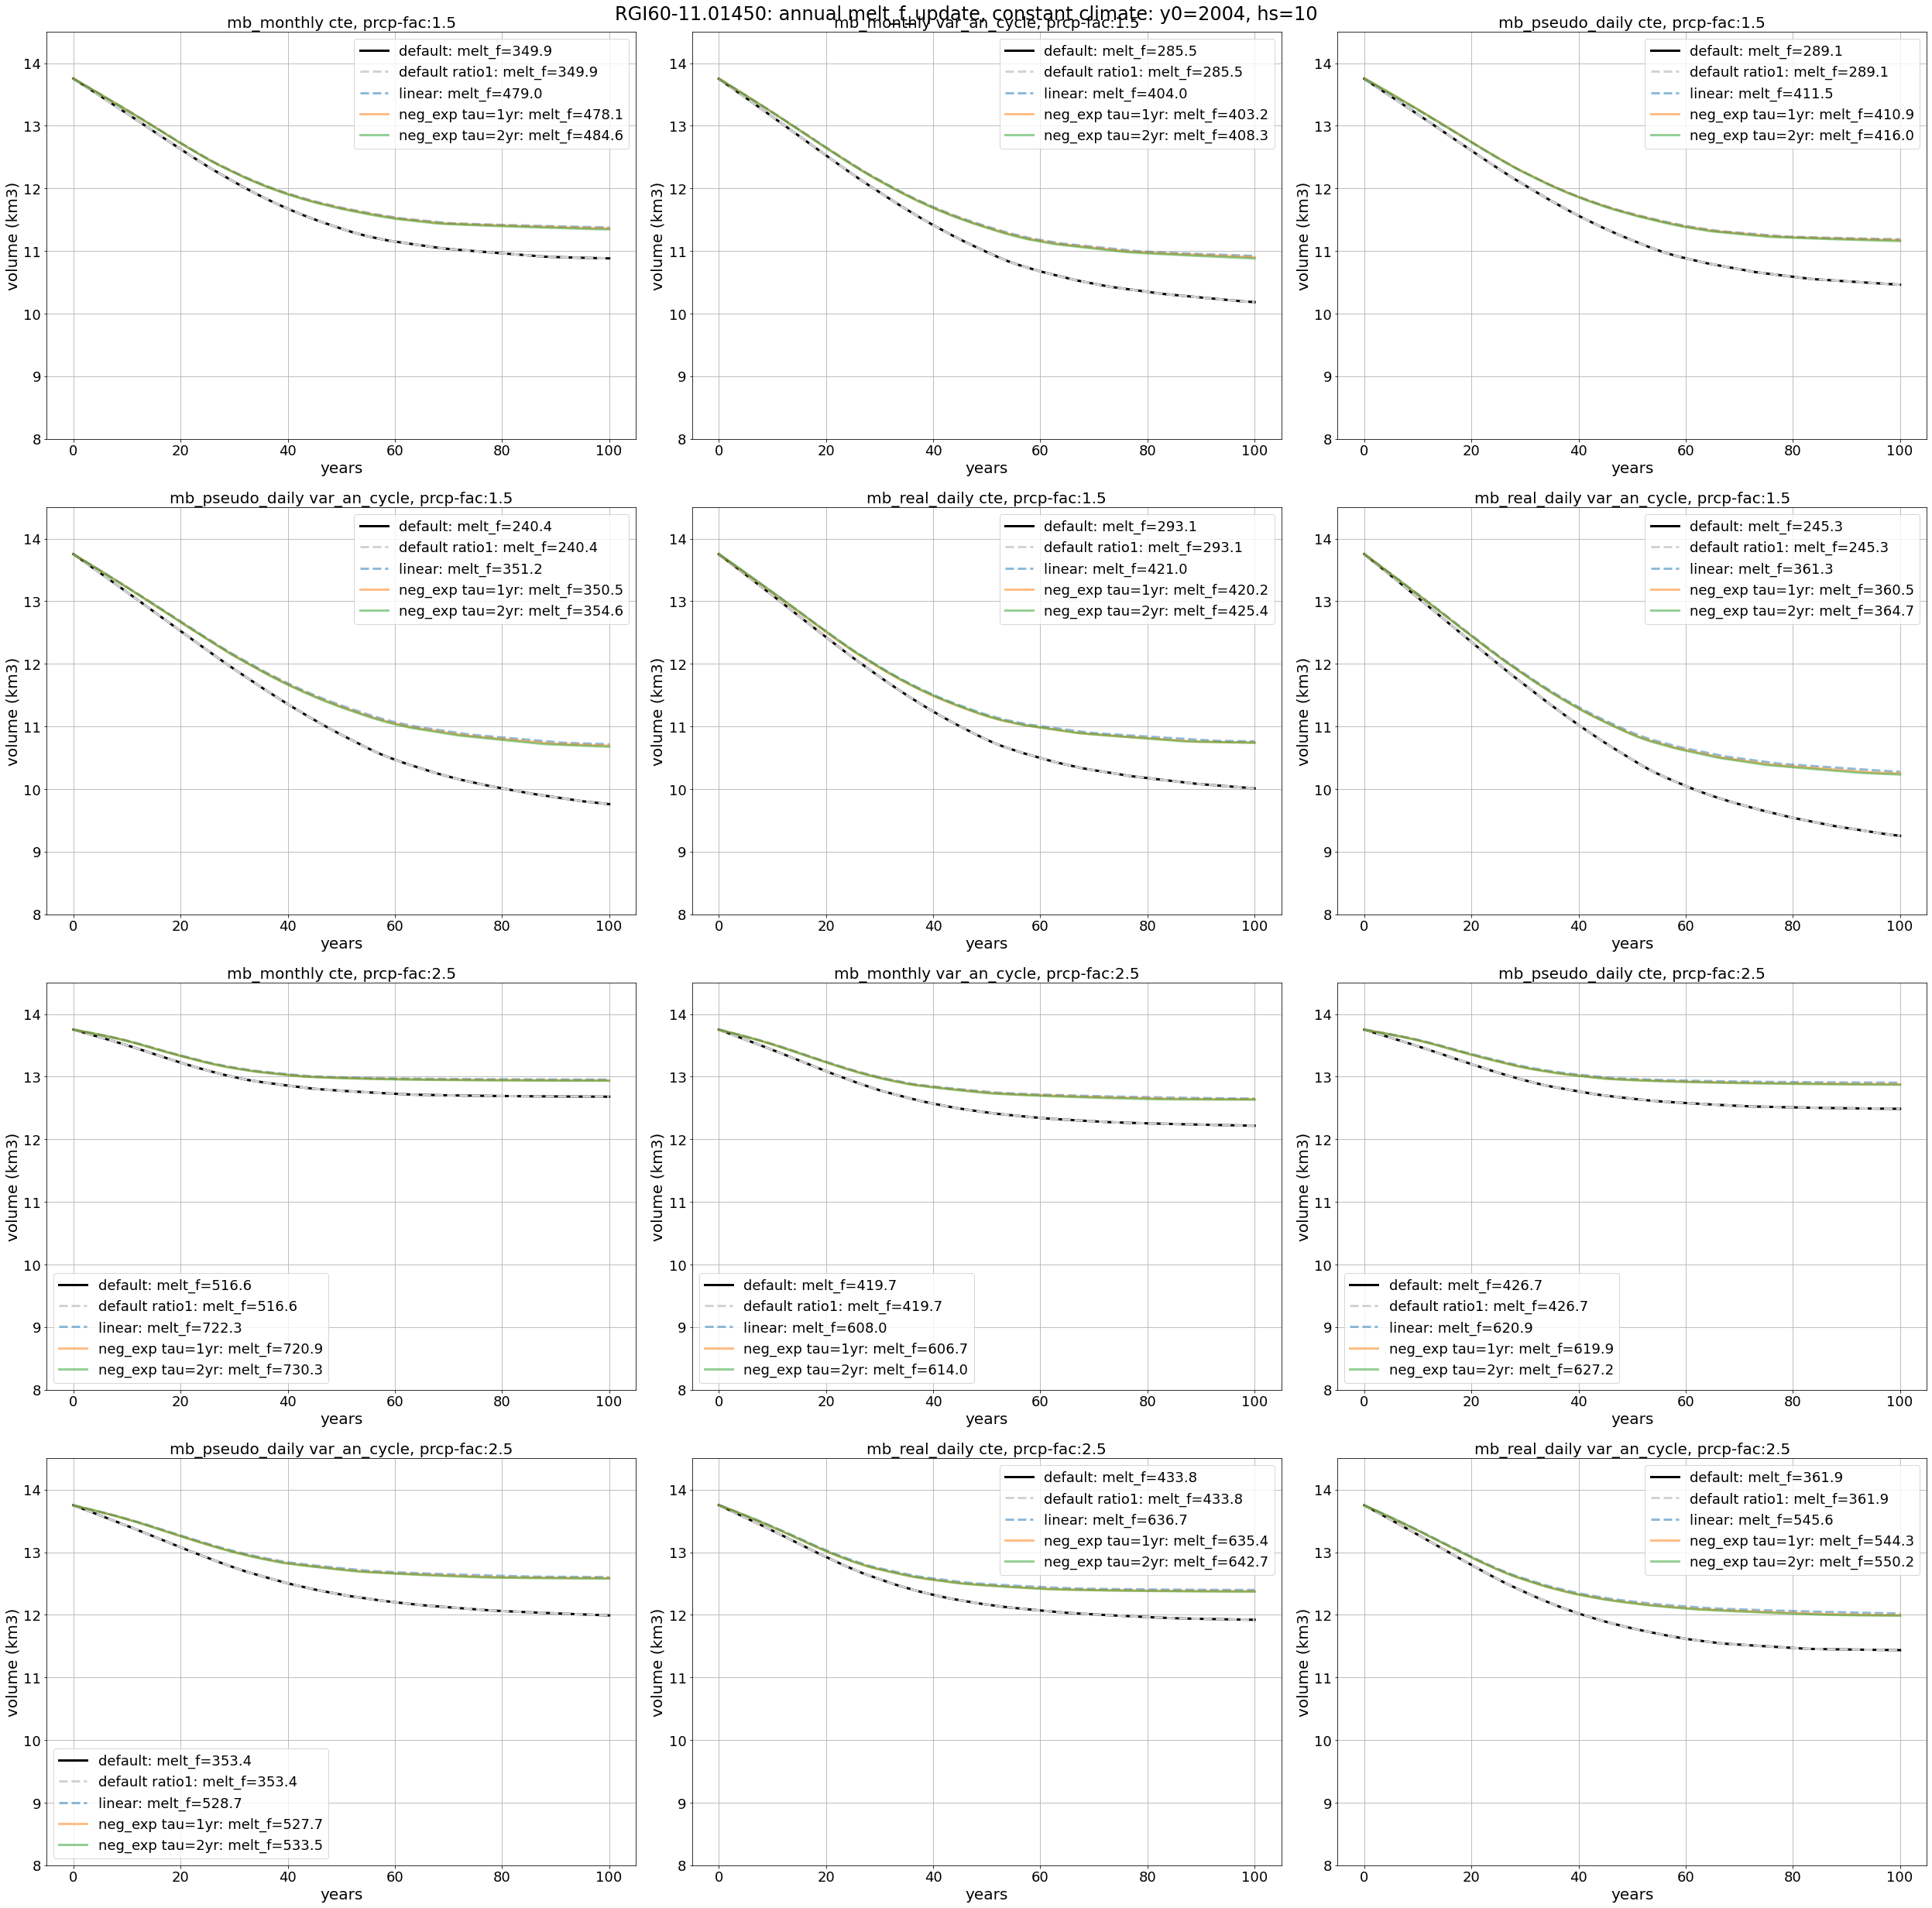

In [17]:
calendar_year = ds_default_random_TIModel[f'mb_monthly_cte_pf_1.5_melt_f_update_{melt_f_update}'].calendar_year
plt.figure(figsize=(35,35))
j=0
plt.suptitle(f'{gdirs[-1].rgi_id}: {melt_f_update} melt_f_update, {run_type} climate: y0=2004, hs=10')

for pf in [1.5, 2.5]:
    for mb_type in ['mb_monthly', 'mb_pseudo_daily', 'mb_real_daily']:
        for grad_type in ['cte', 'var_an_cycle']:
            j+=1

            try:
                typ = f'{mb_type}_{grad_type}_pf_{pf}_melt_f_update_{melt_f_update}'

                plt.subplot(4,3,j)

                plt.plot(calendar_year, ds_default_random_TIModel[typ].volume/1e9, label = 'default: melt_f={:0.1f}'.format(melt_f_default_random_TIModel[typ]), color = 'black', ls='-', lw=3, alpha = 1)
                plt.plot(calendar_year, ds_default_random_ratio1[typ].volume/1e9, label = 'default ratio1: melt_f={:0.1f}'.format(melt_f_default_random_ratio1[typ]), color = 'lightgrey', ls='--', lw=3, alpha = 1)


                plt.plot(calendar_year, ds_linear_an_random[typ].volume/1e9, label = 'linear: melt_f={:0.1f}'.format(melt_f_linear_an_random[typ]), ls = '--', lw=3, alpha = 0.5)
                plt.plot(calendar_year, ds_neg_exp_an_random_1[typ].volume/1e9, label = 'neg_exp tau=1yr: melt_f={:0.1f}'.format(melt_f_neg_exp_an_random_1[typ]), ls = '-', lw=3, alpha = 0.5)
                plt.plot(calendar_year, ds_neg_exp_an_random_2[typ].volume/1e9, label = 'neg_exp tau=2yr: melt_f={:0.1f}'.format(melt_f_neg_exp_an_random_2[typ]), ls = '-', lw=3, alpha = 0.5)


                #plt.plot(ds_linear_m_random.volume, label = 'linear_monthly_melt_f_update: melt_f={:0.1f}'.format(melt_f_linear_m_random))
                #plt.plot(ds_neg_exp_m_random_1.volume, label = 'neg_exp_monthly_melt_f_update: melt_f={:0.1f}, tau_e_fold =1'.format(melt_f_neg_exp_m_random_1))
                #plt.plot(ds_neg_exp_m_random_1_5.volume, label = 'neg_exp_monthly_melt_f_update: melt_f={:0.1f}, tau_e_fold=1.5'.format(melt_f_neg_exp_m_random_1_5))
                plt.xlabel('years')

                plt.ylabel('volume (km3)')
                plt.legend()
                plt.title(f'{mb_type} {grad_type}, prcp-fac:{pf}', fontsize=20)

                plt.ylim([8, 14.5])
                plt.grid()
            except:
                pass
plt.tight_layout()


# Actual runs and plots
- choose for run_type either `from_climate`, `random` or `cte` (cte is not yet implemented the most efficient way however)
- also choose for melt_f_update either `monthly` or `annual`

In [5]:
nyears=100
ds_default_random_TIModel={}
ds_default_random_ratio1={}
ds_linear_an_random={}
ds_neg_exp_an_random_1={}
ds_neg_exp_an_random_2={}
melt_f_default_random_TIModel={}
melt_f_default_random_ratio1={}
melt_f_linear_an_random={}
melt_f_neg_exp_an_random_1={}
melt_f_neg_exp_an_random_2={}
# or 
# melt_f_update='annual'
#run_type = 'random'#'from_climate' # or

In [10]:
# just to check how fast/slow it runs
import timeit

interpolation_optim = True
y0 = 2004
hs = 10

#melt_f_update = 'monthly' #'monthly' 
melt_f_update = 'monthly' #'monthly' 

#melt_f_update = 'annual' #'monthly' #'monthly' 

# run_type = 'random'
for mb_type in ['mb_real_daily']:
#for mb_type in ['mb_real_daily']:
    for grad_type in ['cte']:
        for pf in [1.5]:
            #for run_type in ['random', 'constant']:
            for run_type in ['from_climate']:

                #typ = f'{mb_type}_{grad_type}_pf_{pf}'
                typ = f'{mb_type}_{grad_type}_pf_{pf}_melt_f_update_{melt_f_update}_run_type_{run_type}'

                

                


In [11]:
import datetime
start_time = datetime.datetime.now()
calib_inv_run(gdir=gdirs[-1],kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'linear',
                                                                     'tau_e_fold_yr':1,
                                                                     'spinup_yrs':6,
                                                                     'melt_f_update':melt_f_update, 
                                               'melt_f_ratio_snow_to_ice':0.5},
                                      mb_elev_feedback = 'annual', run_type = run_type,mb_type=mb_type, grad_type=grad_type, pf=pf, interpolation_optim=interpolation_optim,
                                                                                         y0=y0, hs=hs,
                                     nyears=nyears,
                                     spinup=True)
end_time = datetime.datetime.now()


In [12]:
end_time-start_time

datetime.timedelta(seconds=229, microseconds=78297)

In [38]:
interpolation_optim = True
y0 = 2004
hs = 10

#melt_f_update = 'monthly' #'monthly' 
melt_f_update = 'monthly' #'monthly' 

# melt_f_update = 'annual' #'monthly' 

# run_type = 'random'
for mb_type in ['mb_monthly', 'mb_pseudo_daily', 'mb_real_daily']:
#for mb_type in ['mb_real_daily']:
    for grad_type in ['cte', 'var_an_cycle']:
        for pf in [1.5, 2.5]:
            #for run_type in ['random', 'constant']:
            for run_type in ['from_climate']:

                #typ = f'{mb_type}_{grad_type}_pf_{pf}'
                typ = f'{mb_type}_{grad_type}_pf_{pf}_melt_f_update_{melt_f_update}_run_type_{run_type}'

                ds_default_random_TIModel[typ], melt_f_default_random_TIModel[typ],_ = calib_inv_run(gdir=gdirs[-1],mb_model_sub_class = TIModel,
                                                                      mb_elev_feedback = 'annual',mb_type=mb_type, grad_type=grad_type, pf=pf,
                                                                      nyears=nyears,
                                                                             run_type = run_type, interpolation_optim=interpolation_optim, y0=y0, hs=hs)

                ds_default_random_ratio1[typ], melt_f_default_random_ratio1[typ],_ = calib_inv_run(gdir=gdirs[-1],kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'linear',
                                                                                                                                                 'tau_e_fold_yr':20,
                                                                     'spinup_yrs':6,
                                                                     'melt_f_update':melt_f_update, 
                                                                     'melt_f_ratio_snow_to_ice':1},
                                                                      mb_elev_feedback = 'annual',
                                                                      nyears=nyears,mb_type=mb_type, grad_type=grad_type, pf=pf, interpolation_optim=interpolation_optim,
                                                                                                   y0=y0, hs=hs,
                                                                             run_type = run_type)

                ds_linear_an_random[typ], melt_f_linear_an_random[typ],_ = calib_inv_run(gdir=gdirs[-1],kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'linear',
                                                                     'tau_e_fold_yr':1,
                                                                     'spinup_yrs':6,
                                                                     'melt_f_update':melt_f_update, 
                                               'melt_f_ratio_snow_to_ice':0.5},
                                      mb_elev_feedback = 'annual', run_type = run_type,mb_type=mb_type, grad_type=grad_type, pf=pf, interpolation_optim=interpolation_optim,
                                                                                         y0=y0, hs=hs,
                                     nyears=nyears,
                                     spinup=True)
                ds_neg_exp_an_random_1[typ], melt_f_neg_exp_an_random_1[typ],_ = calib_inv_run(gdir=gdirs[-1],kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'neg_exp',
                                                                     'tau_e_fold_yr':1,
                                                                     'spinup_yrs':6,
                                                                     'melt_f_update':melt_f_update,
                                               'melt_f_ratio_snow_to_ice':0.5},
                                      mb_elev_feedback = 'annual',run_type = run_type,mb_type=mb_type, grad_type=grad_type, pf=pf, interpolation_optim=interpolation_optim,
                                                                                               y0=y0, hs=hs,
                                     nyears=nyears,
                                     spinup=True)

                ds_neg_exp_an_random_2[typ], melt_f_neg_exp_an_random_2[typ],_ = calib_inv_run(gdir=gdirs[-1], kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'neg_exp',
                                                                     'tau_e_fold_yr':2,
                                                                     'spinup_yrs':6,
                                                                     'melt_f_update':melt_f_update,
                                               'melt_f_ratio_snow_to_ice':0.5},
                                      mb_elev_feedback = 'annual',run_type = run_type, mb_type=mb_type, grad_type=grad_type, pf=pf, interpolation_optim=interpolation_optim,
                                                                                               y0=y0, hs=hs,
                                     nyears=nyears,
                                     spinup=True)
                print(typ)

mb_monthly_cte_pf_1.5_melt_f_update_monthly_run_type_from_climate
mb_monthly_cte_pf_2.5_melt_f_update_monthly_run_type_from_climate
mb_monthly_var_an_cycle_pf_1.5_melt_f_update_monthly_run_type_from_climate
mb_monthly_var_an_cycle_pf_2.5_melt_f_update_monthly_run_type_from_climate
mb_pseudo_daily_cte_pf_1.5_melt_f_update_monthly_run_type_from_climate
mb_pseudo_daily_cte_pf_2.5_melt_f_update_monthly_run_type_from_climate
mb_pseudo_daily_var_an_cycle_pf_1.5_melt_f_update_monthly_run_type_from_climate
mb_pseudo_daily_var_an_cycle_pf_2.5_melt_f_update_monthly_run_type_from_climate
mb_real_daily_cte_pf_1.5_melt_f_update_monthly_run_type_from_climate
mb_real_daily_cte_pf_2.5_melt_f_update_monthly_run_type_from_climate
mb_real_daily_var_an_cycle_pf_1.5_melt_f_update_monthly_run_type_from_climate
mb_real_daily_var_an_cycle_pf_2.5_melt_f_update_monthly_run_type_from_climate


In [9]:
colors = ['black', 'grey', 'blue', 'red', 'green']

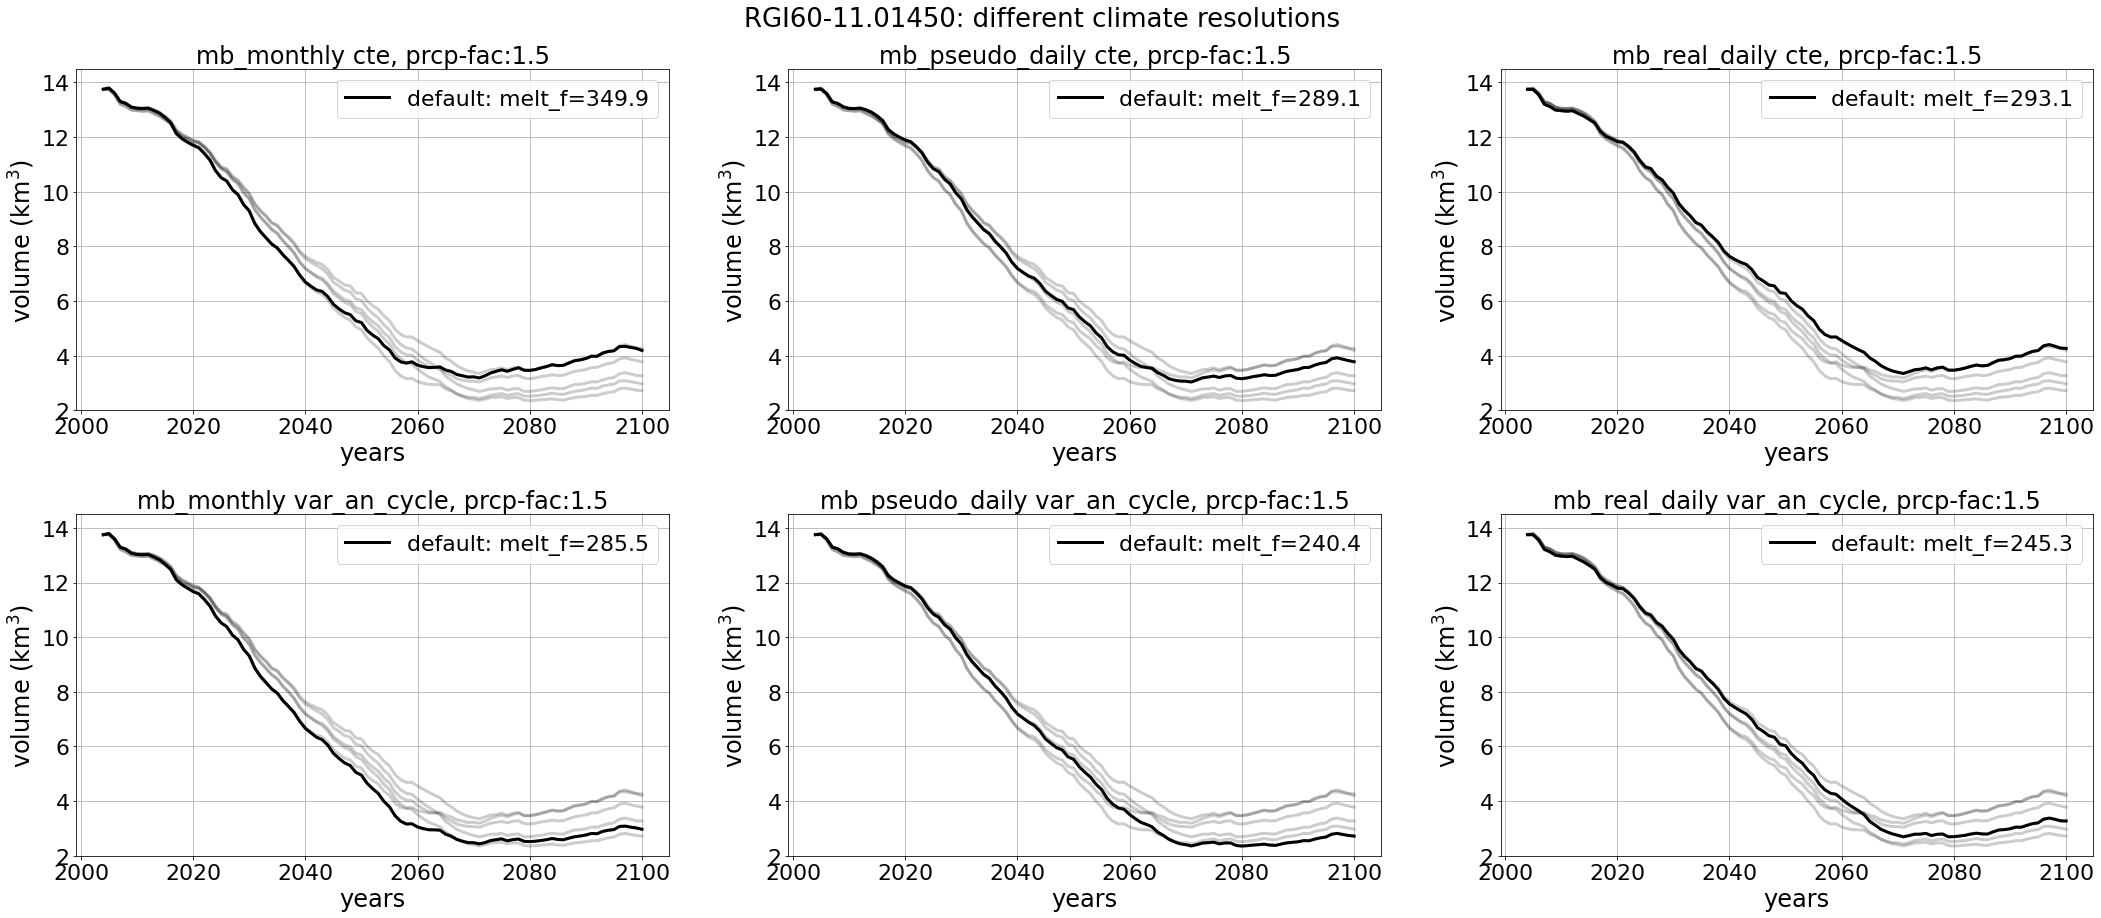

In [10]:
melt_f_update = 'annual'
calendar_year = ds_default_random_TIModel[f'mb_monthly_cte_pf_1.5_melt_f_update_{melt_f_update}_run_type_{run_type}'].calendar_year
#calendar_year = ds_default_random_TIModel[f'mb_monthly_cte_pf_1.5_melt_f_update_{melt_f_update}'].calendar_year

plt.figure(figsize=(30,25))
j=0
plt.suptitle(f'{gdirs[-1].rgi_id}: different climate resolutions')
pf_comp=False
#for pf in [1.5, 2.5]:
for grad_type in ['cte', 'var_an_cycle']:
    for mb_type in ['mb_monthly', 'mb_pseudo_daily', 'mb_real_daily']:

            j+=1

            try:
                #typ = f'{mb_type}_{grad_type}_pf_{pf}'
                #print(typ)
                #typ = f'{mb_type}_{grad_type}_pf_{pf}_melt_f_update_{melt_f_update}'


                plt.subplot(4,3,j)
                pf = 1.5
                typ = f'{mb_type}_{grad_type}_pf_{pf}_melt_f_update_{melt_f_update}_run_type_{run_type}'

                plt.plot(calendar_year, ds_default_random_TIModel[typ].volume/1e9,
                         label = 'default: melt_f={:0.1f}'.format(melt_f_default_random_TIModel[typ]), ls='-', lw=3, alpha = 1, color = colors[0])
                #plt.plot(calendar_year, ds_default_random_ratio1[typ].volume/1e9, label = 'default ratio1: melt_f={:0.1f}'.format(melt_f_default_random_ratio1[typ]),  ls='--', lw=3, alpha = 1, color = colors[1])
                #plt.plot(calendar_year, ds_linear_an_random[typ].volume/1e9, label = 'linear: melt_f={:0.1f}'.format(melt_f_linear_an_random[typ]), ls = '-', lw=2, alpha = 0.4, color = colors[2])
                #plt.plot(calendar_year, ds_neg_exp_an_random_1[typ].volume/1e9, label = 'neg_exp tau=1yr: melt_f={:0.1f}'.format(melt_f_neg_exp_an_random_1[typ]), ls = '-', lw=2, alpha = 0.4, color = colors[3])
                #plt.plot(calendar_year, ds_neg_exp_an_random_2[typ].volume/1e9, label = 'neg_exp tau=2yr: melt_f={:0.1f}'.format(melt_f_neg_exp_an_random_2[typ]), ls = '-', lw=2, alpha = 0.4, color = colors[4])


                #plt.plot(ds_linear_m_random.volume, label = 'linear_monthly_melt_f_update: melt_f={:0.1f}'.format(melt_f_linear_m_random))
                #plt.plot(ds_neg_exp_m_random_1.volume, label = 'neg_exp_monthly_melt_f_update: melt_f={:0.1f}, tau_e_fold =1'.format(melt_f_neg_exp_m_random_1))
                #plt.plot(ds_neg_exp_m_random_1_5.volume, label = 'neg_exp_monthly_melt_f_update: melt_f={:0.1f}, tau_e_fold=1.5'.format(melt_f_neg_exp_m_random_1_5))
                plt.xlabel('years')

                plt.ylabel(r'volume (km$^3$)')
                plt.legend()
                plt.title(f'{mb_type} {grad_type}, prcp-fac:{pf}', fontsize=24)

                for grad_type2 in ['cte', 'var_an_cycle']:
                    for mb_type in ['mb_monthly', 'mb_pseudo_daily', 'mb_real_daily']:
                        typ = f'{mb_type}_{grad_type2}_pf_{pf}_melt_f_update_{melt_f_update}_run_type_{run_type}'

                        plt.plot(calendar_year, ds_default_random_TIModel[typ].volume/1e9,
                                 label = 'default: melt_f={:0.1f}'.format(melt_f_default_random_TIModel[typ]), ls='-', lw=3, alpha =0.2, color = colors[0])
                if pf_comp:
                    pf = 2.5
                    alpha=0.3
                    ls = '--'
                    typ = f'{mb_type}_{grad_type}_pf_{pf}_melt_f_update_{melt_f_update}_run_type_{run_type}'
                    plt.plot(calendar_year, ds_default_random_TIModel[typ].volume/1e9, label = 'default: melt_f={:0.1f}'.format(melt_f_default_random_TIModel[typ]), ls=ls, lw=3, alpha = alpha, color = colors[0])
                    #plt.plot(calendar_year, ds_default_random_ratio1[typ].volume/1e9, label = 'default ratio1: melt_f={:0.1f}'.format(melt_f_default_random_ratio1[typ]), ls='--', lw=3, alpha = alpha, color = colors[1])
                    plt.plot(calendar_year, ds_linear_an_random[typ].volume/1e9, label = 'linear: melt_f={:0.1f}'.format(melt_f_linear_an_random[typ]), ls = ls, lw=3, alpha = alpha, color = colors[2])
                    plt.plot(calendar_year, ds_neg_exp_an_random_1[typ].volume/1e9, label = 'neg_exp tau=1yr: melt_f={:0.1f}'.format(melt_f_neg_exp_an_random_1[typ]), ls = ls, lw=3, alpha = alpha, color = colors[3])
                    plt.plot(calendar_year, ds_neg_exp_an_random_2[typ].volume/1e9, label = 'neg_exp tau=2yr: melt_f={:0.1f}'.format(melt_f_neg_exp_an_random_2[typ]), ls = ls, lw=3, alpha = alpha, color = colors[4])



                plt.ylim([2,14.5])
                plt.grid()
            except:
                pass
plt.tight_layout()
plt.savefig(f'{gdirs[-1].rgi_id}_climate_resol.pdf', dpi=150, bbox_inches='tight')

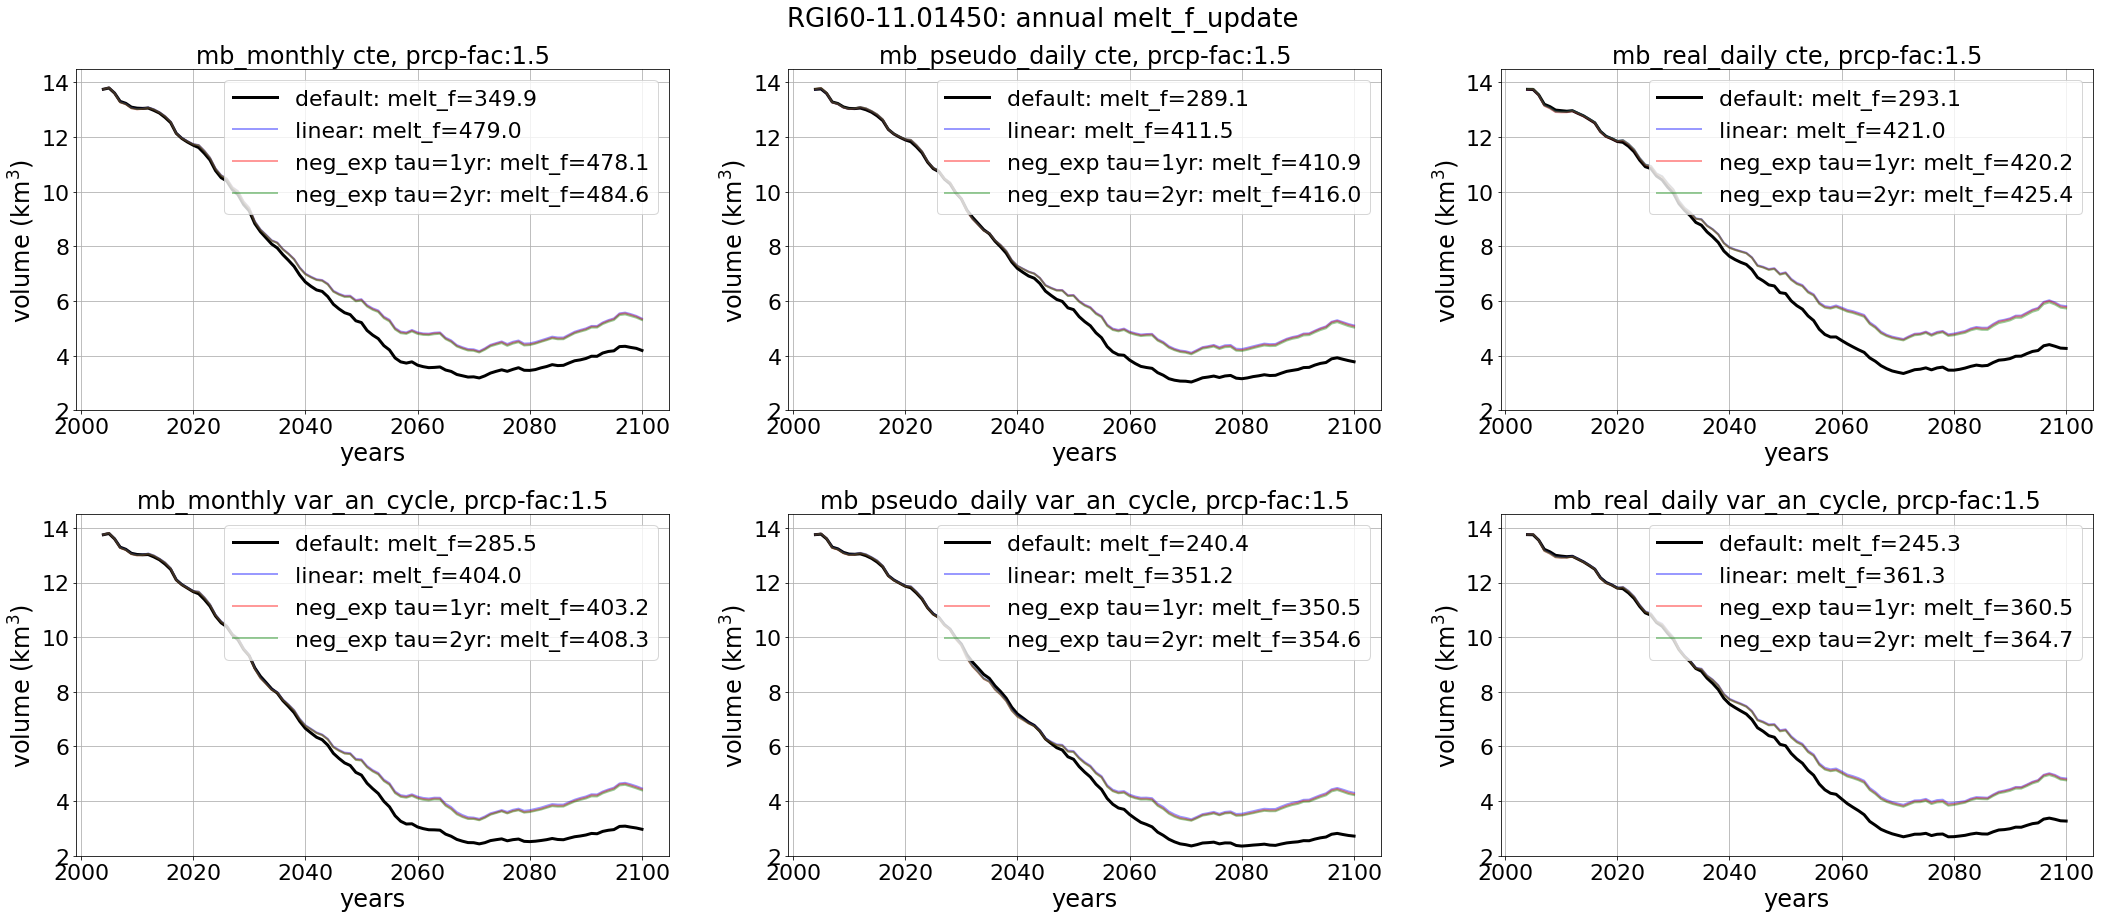

In [49]:
melt_f_update = 'annual'
calendar_year = ds_default_random_TIModel[f'mb_monthly_cte_pf_1.5_melt_f_update_{melt_f_update}_run_type_{run_type}'].calendar_year
#calendar_year = ds_default_random_TIModel[f'mb_monthly_cte_pf_1.5_melt_f_update_{melt_f_update}'].calendar_year

plt.figure(figsize=(30,25))
j=0
plt.suptitle(f'{gdirs[-1].rgi_id}: {melt_f_update} melt_f_update')
pf_comp=False
#for pf in [1.5, 2.5]:
for grad_type in ['cte', 'var_an_cycle']:
    for mb_type in ['mb_monthly', 'mb_pseudo_daily', 'mb_real_daily']:

            j+=1

            try:
                #typ = f'{mb_type}_{grad_type}_pf_{pf}'
                #print(typ)
                #typ = f'{mb_type}_{grad_type}_pf_{pf}_melt_f_update_{melt_f_update}'


                plt.subplot(4,3,j)
                pf = 1.5
                typ = f'{mb_type}_{grad_type}_pf_{pf}_melt_f_update_{melt_f_update}_run_type_{run_type}'

                plt.plot(calendar_year, ds_default_random_TIModel[typ].volume/1e9, label = 'default: melt_f={:0.1f}'.format(melt_f_default_random_TIModel[typ]), ls='-', lw=3, alpha = 1, color = colors[0])
                #plt.plot(calendar_year, ds_default_random_ratio1[typ].volume/1e9, label = 'default ratio1: melt_f={:0.1f}'.format(melt_f_default_random_ratio1[typ]),  ls='--', lw=3, alpha = 1, color = colors[1])
                plt.plot(calendar_year, ds_linear_an_random[typ].volume/1e9, label = 'linear: melt_f={:0.1f}'.format(melt_f_linear_an_random[typ]), ls = '-', lw=2, alpha = 0.4, color = colors[2])
                plt.plot(calendar_year, ds_neg_exp_an_random_1[typ].volume/1e9, label = 'neg_exp tau=1yr: melt_f={:0.1f}'.format(melt_f_neg_exp_an_random_1[typ]), ls = '-', lw=2, alpha = 0.4, color = colors[3])
                plt.plot(calendar_year, ds_neg_exp_an_random_2[typ].volume/1e9, label = 'neg_exp tau=2yr: melt_f={:0.1f}'.format(melt_f_neg_exp_an_random_2[typ]), ls = '-', lw=2, alpha = 0.4, color = colors[4])


                #plt.plot(ds_linear_m_random.volume, label = 'linear_monthly_melt_f_update: melt_f={:0.1f}'.format(melt_f_linear_m_random))
                #plt.plot(ds_neg_exp_m_random_1.volume, label = 'neg_exp_monthly_melt_f_update: melt_f={:0.1f}, tau_e_fold =1'.format(melt_f_neg_exp_m_random_1))
                #plt.plot(ds_neg_exp_m_random_1_5.volume, label = 'neg_exp_monthly_melt_f_update: melt_f={:0.1f}, tau_e_fold=1.5'.format(melt_f_neg_exp_m_random_1_5))
                plt.xlabel('years')

                plt.ylabel(r'volume (km$^3$)')
                plt.legend()
                if pf_comp:
                    pf = 2.5
                    alpha=0.3
                    ls = '--'
                    typ = f'{mb_type}_{grad_type}_pf_{pf}_melt_f_update_{melt_f_update}_run_type_{run_type}'
                    plt.plot(calendar_year, ds_default_random_TIModel[typ].volume/1e9, label = 'default: melt_f={:0.1f}'.format(melt_f_default_random_TIModel[typ]), ls=ls, lw=3, alpha = alpha, color = colors[0])
                    #plt.plot(calendar_year, ds_default_random_ratio1[typ].volume/1e9, label = 'default ratio1: melt_f={:0.1f}'.format(melt_f_default_random_ratio1[typ]), ls='--', lw=3, alpha = alpha, color = colors[1])
                    plt.plot(calendar_year, ds_linear_an_random[typ].volume/1e9, label = 'linear: melt_f={:0.1f}'.format(melt_f_linear_an_random[typ]), ls = ls, lw=3, alpha = alpha, color = colors[2])
                    plt.plot(calendar_year, ds_neg_exp_an_random_1[typ].volume/1e9, label = 'neg_exp tau=1yr: melt_f={:0.1f}'.format(melt_f_neg_exp_an_random_1[typ]), ls = ls, lw=3, alpha = alpha, color = colors[3])
                    plt.plot(calendar_year, ds_neg_exp_an_random_2[typ].volume/1e9, label = 'neg_exp tau=2yr: melt_f={:0.1f}'.format(melt_f_neg_exp_an_random_2[typ]), ls = ls, lw=3, alpha = alpha, color = colors[4])


                plt.title(f'{mb_type} {grad_type}, prcp-fac:{pf}', fontsize=24)

                plt.ylim([2,14.5])
                plt.grid()
            except:
                pass
plt.tight_layout()
plt.savefig(f'{gdirs[-1].rgi_id}_{typ}_pf_comp_{pf_comp}.pdf', dpi=150, bbox_inches='tight')

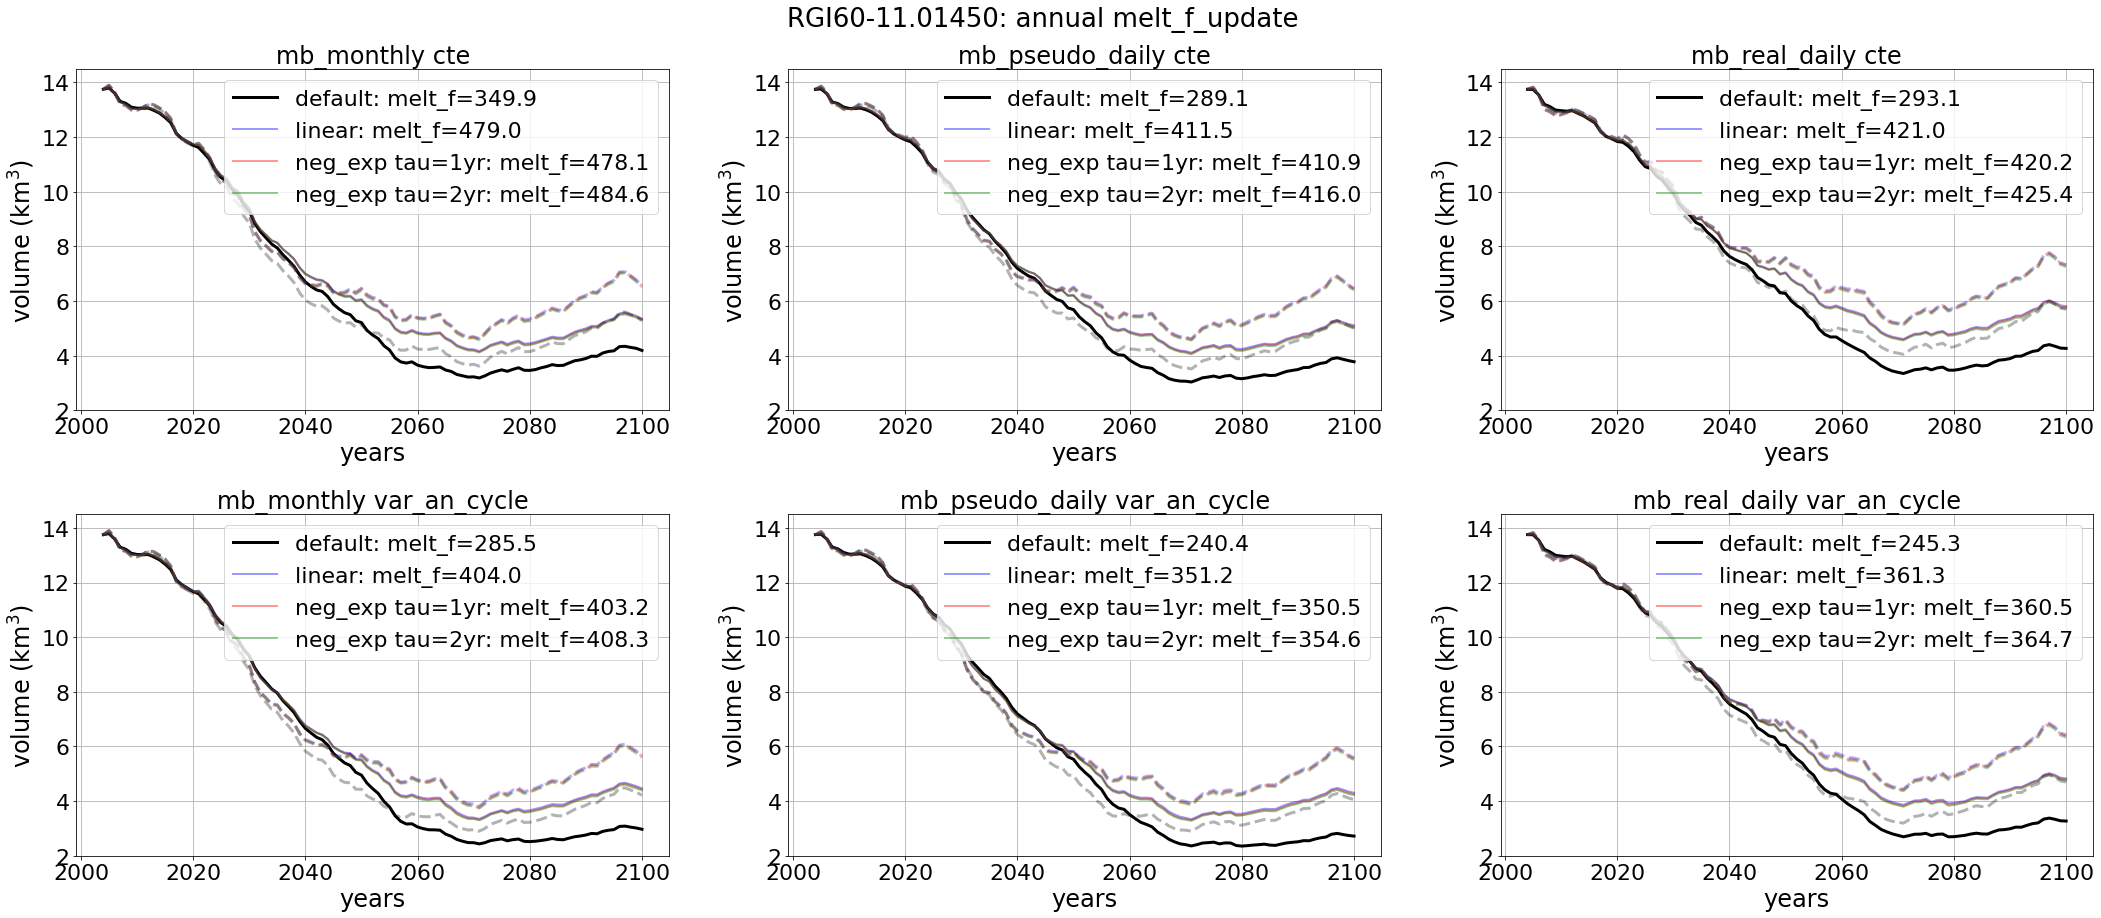

In [50]:
melt_f_update = 'annual'

calendar_year = ds_default_random_TIModel[f'mb_monthly_cte_pf_1.5_melt_f_update_{melt_f_update}_run_type_{run_type}'].calendar_year
#calendar_year = ds_default_random_TIModel[f'mb_monthly_cte_pf_1.5_melt_f_update_{melt_f_update}'].calendar_year

plt.figure(figsize=(30,25))
j=0
plt.suptitle(f'{gdirs[-1].rgi_id}: {melt_f_update} melt_f_update')
pf_comp=True
#for pf in [1.5, 2.5]:
for grad_type in ['cte', 'var_an_cycle']:
    for mb_type in ['mb_monthly', 'mb_pseudo_daily', 'mb_real_daily']:

            j+=1

            try:
                #typ = f'{mb_type}_{grad_type}_pf_{pf}'
                #print(typ)
                #typ = f'{mb_type}_{grad_type}_pf_{pf}_melt_f_update_{melt_f_update}'


                plt.subplot(4,3,j)
                pf = 1.5
                typ = f'{mb_type}_{grad_type}_pf_{pf}_melt_f_update_{melt_f_update}_run_type_{run_type}'

                plt.plot(calendar_year, ds_default_random_TIModel[typ].volume/1e9, label = 'default: melt_f={:0.1f}'.format(melt_f_default_random_TIModel[typ]), ls='-', lw=3, alpha = 1, color = colors[0])
                #plt.plot(calendar_year, ds_default_random_ratio1[typ].volume/1e9, label = 'default ratio1: melt_f={:0.1f}'.format(melt_f_default_random_ratio1[typ]),  ls='--', lw=3, alpha = 1, color = colors[1])
                plt.plot(calendar_year, ds_linear_an_random[typ].volume/1e9, label = 'linear: melt_f={:0.1f}'.format(melt_f_linear_an_random[typ]), ls = '-', lw=2, alpha = 0.4, color = colors[2])
                plt.plot(calendar_year, ds_neg_exp_an_random_1[typ].volume/1e9, label = 'neg_exp tau=1yr: melt_f={:0.1f}'.format(melt_f_neg_exp_an_random_1[typ]), ls = '-', lw=2, alpha = 0.4, color = colors[3])
                plt.plot(calendar_year, ds_neg_exp_an_random_2[typ].volume/1e9, label = 'neg_exp tau=2yr: melt_f={:0.1f}'.format(melt_f_neg_exp_an_random_2[typ]), ls = '-', lw=2, alpha = 0.4, color = colors[4])


                #plt.plot(ds_linear_m_random.volume, label = 'linear_monthly_melt_f_update: melt_f={:0.1f}'.format(melt_f_linear_m_random))
                #plt.plot(ds_neg_exp_m_random_1.volume, label = 'neg_exp_monthly_melt_f_update: melt_f={:0.1f}, tau_e_fold =1'.format(melt_f_neg_exp_m_random_1))
                #plt.plot(ds_neg_exp_m_random_1_5.volume, label = 'neg_exp_monthly_melt_f_update: melt_f={:0.1f}, tau_e_fold=1.5'.format(melt_f_neg_exp_m_random_1_5))
                plt.xlabel('years')

                plt.ylabel(r'volume (km$^3$)')
                plt.legend()
                if pf_comp:
                    pf = 2.5
                    alpha=0.3
                    ls = '--'
                    typ = f'{mb_type}_{grad_type}_pf_{pf}_melt_f_update_{melt_f_update}_run_type_{run_type}'
                    plt.plot(calendar_year, ds_default_random_TIModel[typ].volume/1e9, label = 'default: melt_f={:0.1f}'.format(melt_f_default_random_TIModel[typ]), ls=ls, lw=3, alpha = alpha, color = colors[0])
                    #plt.plot(calendar_year, ds_default_random_ratio1[typ].volume/1e9, label = 'default ratio1: melt_f={:0.1f}'.format(melt_f_default_random_ratio1[typ]), ls='--', lw=3, alpha = alpha, color = colors[1])
                    plt.plot(calendar_year, ds_linear_an_random[typ].volume/1e9, label = 'linear: melt_f={:0.1f}'.format(melt_f_linear_an_random[typ]), ls = ls, lw=3, alpha = alpha, color = colors[2])
                    plt.plot(calendar_year, ds_neg_exp_an_random_1[typ].volume/1e9, label = 'neg_exp tau=1yr: melt_f={:0.1f}'.format(melt_f_neg_exp_an_random_1[typ]), ls = ls, lw=3, alpha = alpha, color = colors[3])
                    plt.plot(calendar_year, ds_neg_exp_an_random_2[typ].volume/1e9, label = 'neg_exp tau=2yr: melt_f={:0.1f}'.format(melt_f_neg_exp_an_random_2[typ]), ls = ls, lw=3, alpha = alpha, color = colors[4])

                if pf_comp==True:
                    plt.title(f'{mb_type} {grad_type}', fontsize=24)
                else:
                    plt.title(f'{mb_type} {grad_type}, prcp-fac:{pf}', fontsize=24)

                plt.ylim([2,14.5])
                plt.grid()
            except:
                pass
plt.tight_layout()
plt.savefig(f'{gdirs[-1].rgi_id}_{typ}_pf_comp_{pf_comp}.pdf',  dpi=150, bbox_inches='tight')

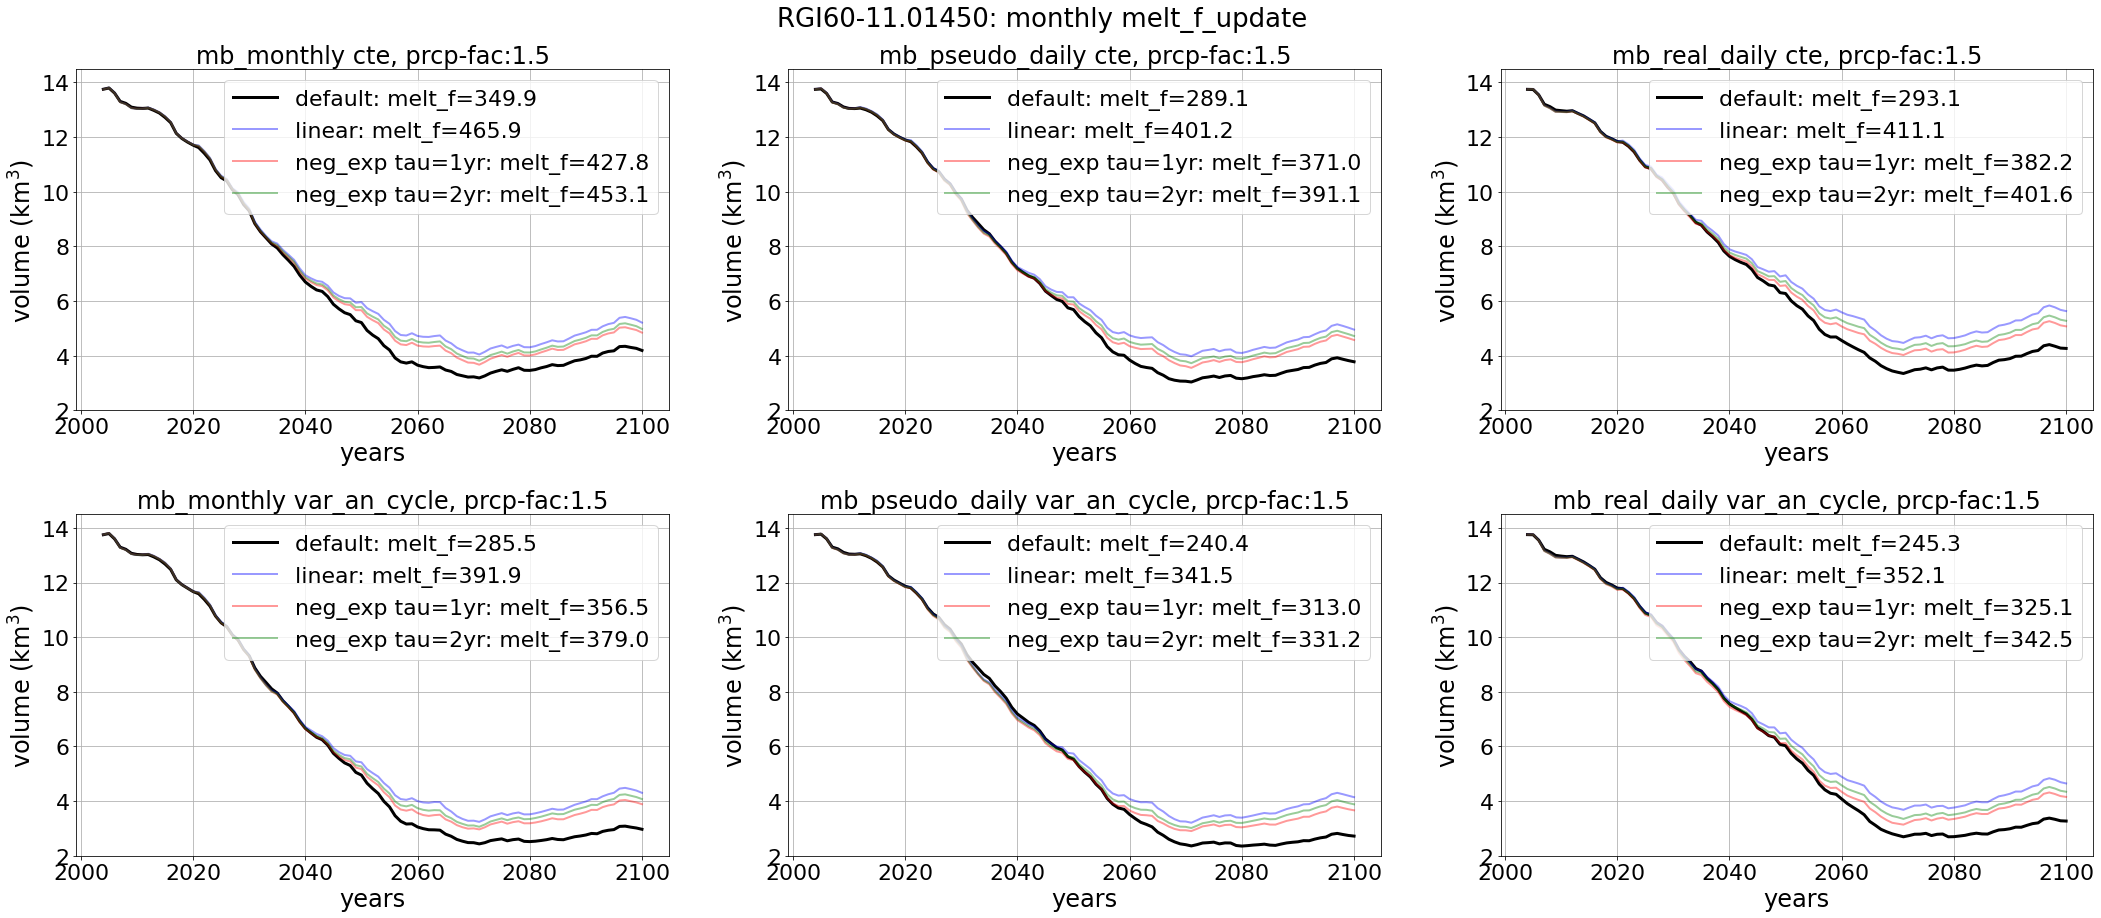

In [52]:
melt_f_update = 'monthly'

calendar_year = ds_default_random_TIModel[f'mb_monthly_cte_pf_1.5_melt_f_update_{melt_f_update}_run_type_{run_type}'].calendar_year
#calendar_year = ds_default_random_TIModel[f'mb_monthly_cte_pf_1.5_melt_f_update_{melt_f_update}'].calendar_year

plt.figure(figsize=(30,25))
j=0
plt.suptitle(f'{gdirs[-1].rgi_id}: {melt_f_update} melt_f_update')
pf_comp=False
#for pf in [1.5, 2.5]:
for grad_type in ['cte', 'var_an_cycle']:
    for mb_type in ['mb_monthly', 'mb_pseudo_daily', 'mb_real_daily']:

            j+=1

            try:
                #typ = f'{mb_type}_{grad_type}_pf_{pf}'
                #print(typ)
                #typ = f'{mb_type}_{grad_type}_pf_{pf}_melt_f_update_{melt_f_update}'


                plt.subplot(4,3,j)
                pf = 1.5
                typ = f'{mb_type}_{grad_type}_pf_{pf}_melt_f_update_{melt_f_update}_run_type_{run_type}'

                plt.plot(calendar_year, ds_default_random_TIModel[typ].volume/1e9, label = 'default: melt_f={:0.1f}'.format(melt_f_default_random_TIModel[typ]), ls='-', lw=3, alpha = 1, color = colors[0])
                #plt.plot(calendar_year, ds_default_random_ratio1[typ].volume/1e9, label = 'default ratio1: melt_f={:0.1f}'.format(melt_f_default_random_ratio1[typ]),  ls='--', lw=3, alpha = 1, color = colors[1])
                plt.plot(calendar_year, ds_linear_an_random[typ].volume/1e9, label = 'linear: melt_f={:0.1f}'.format(melt_f_linear_an_random[typ]), ls = '-', lw=2, alpha = 0.4, color = colors[2])
                plt.plot(calendar_year, ds_neg_exp_an_random_1[typ].volume/1e9, label = 'neg_exp tau=1yr: melt_f={:0.1f}'.format(melt_f_neg_exp_an_random_1[typ]), ls = '-', lw=2, alpha = 0.4, color = colors[3])
                plt.plot(calendar_year, ds_neg_exp_an_random_2[typ].volume/1e9, label = 'neg_exp tau=2yr: melt_f={:0.1f}'.format(melt_f_neg_exp_an_random_2[typ]), ls = '-', lw=2, alpha = 0.4, color = colors[4])


                #plt.plot(ds_linear_m_random.volume, label = 'linear_monthly_melt_f_update: melt_f={:0.1f}'.format(melt_f_linear_m_random))
                #plt.plot(ds_neg_exp_m_random_1.volume, label = 'neg_exp_monthly_melt_f_update: melt_f={:0.1f}, tau_e_fold =1'.format(melt_f_neg_exp_m_random_1))
                #plt.plot(ds_neg_exp_m_random_1_5.volume, label = 'neg_exp_monthly_melt_f_update: melt_f={:0.1f}, tau_e_fold=1.5'.format(melt_f_neg_exp_m_random_1_5))
                plt.xlabel('years')

                plt.ylabel(r'volume (km$^3$)')
                plt.legend()
                if pf_comp:
                    pf = 2.5
                    alpha=0.3
                    ls = '--'
                    typ = f'{mb_type}_{grad_type}_pf_{pf}_melt_f_update_{melt_f_update}_run_type_{run_type}'
                    plt.plot(calendar_year, ds_default_random_TIModel[typ].volume/1e9, label = 'default: melt_f={:0.1f}'.format(melt_f_default_random_TIModel[typ]), ls=ls, lw=3, alpha = alpha, color = colors[0])
                    #plt.plot(calendar_year, ds_default_random_ratio1[typ].volume/1e9, label = 'default ratio1: melt_f={:0.1f}'.format(melt_f_default_random_ratio1[typ]), ls='--', lw=3, alpha = alpha, color = colors[1])
                    plt.plot(calendar_year, ds_linear_an_random[typ].volume/1e9, label = 'linear: melt_f={:0.1f}'.format(melt_f_linear_an_random[typ]), ls = ls, lw=3, alpha = alpha, color = colors[2])
                    plt.plot(calendar_year, ds_neg_exp_an_random_1[typ].volume/1e9, label = 'neg_exp tau=1yr: melt_f={:0.1f}'.format(melt_f_neg_exp_an_random_1[typ]), ls = ls, lw=3, alpha = alpha, color = colors[3])
                    plt.plot(calendar_year, ds_neg_exp_an_random_2[typ].volume/1e9, label = 'neg_exp tau=2yr: melt_f={:0.1f}'.format(melt_f_neg_exp_an_random_2[typ]), ls = ls, lw=3, alpha = alpha, color = colors[4])


                plt.title(f'{mb_type} {grad_type}, prcp-fac:{pf}', fontsize=24)

                plt.ylim([2,14.5])
                plt.grid()
            except:
                pass
plt.tight_layout()
plt.savefig(f'{gdirs[-1].rgi_id}_{typ}_pf_comp_{pf_comp}.pdf', dpi=150, bbox_inches='tight')

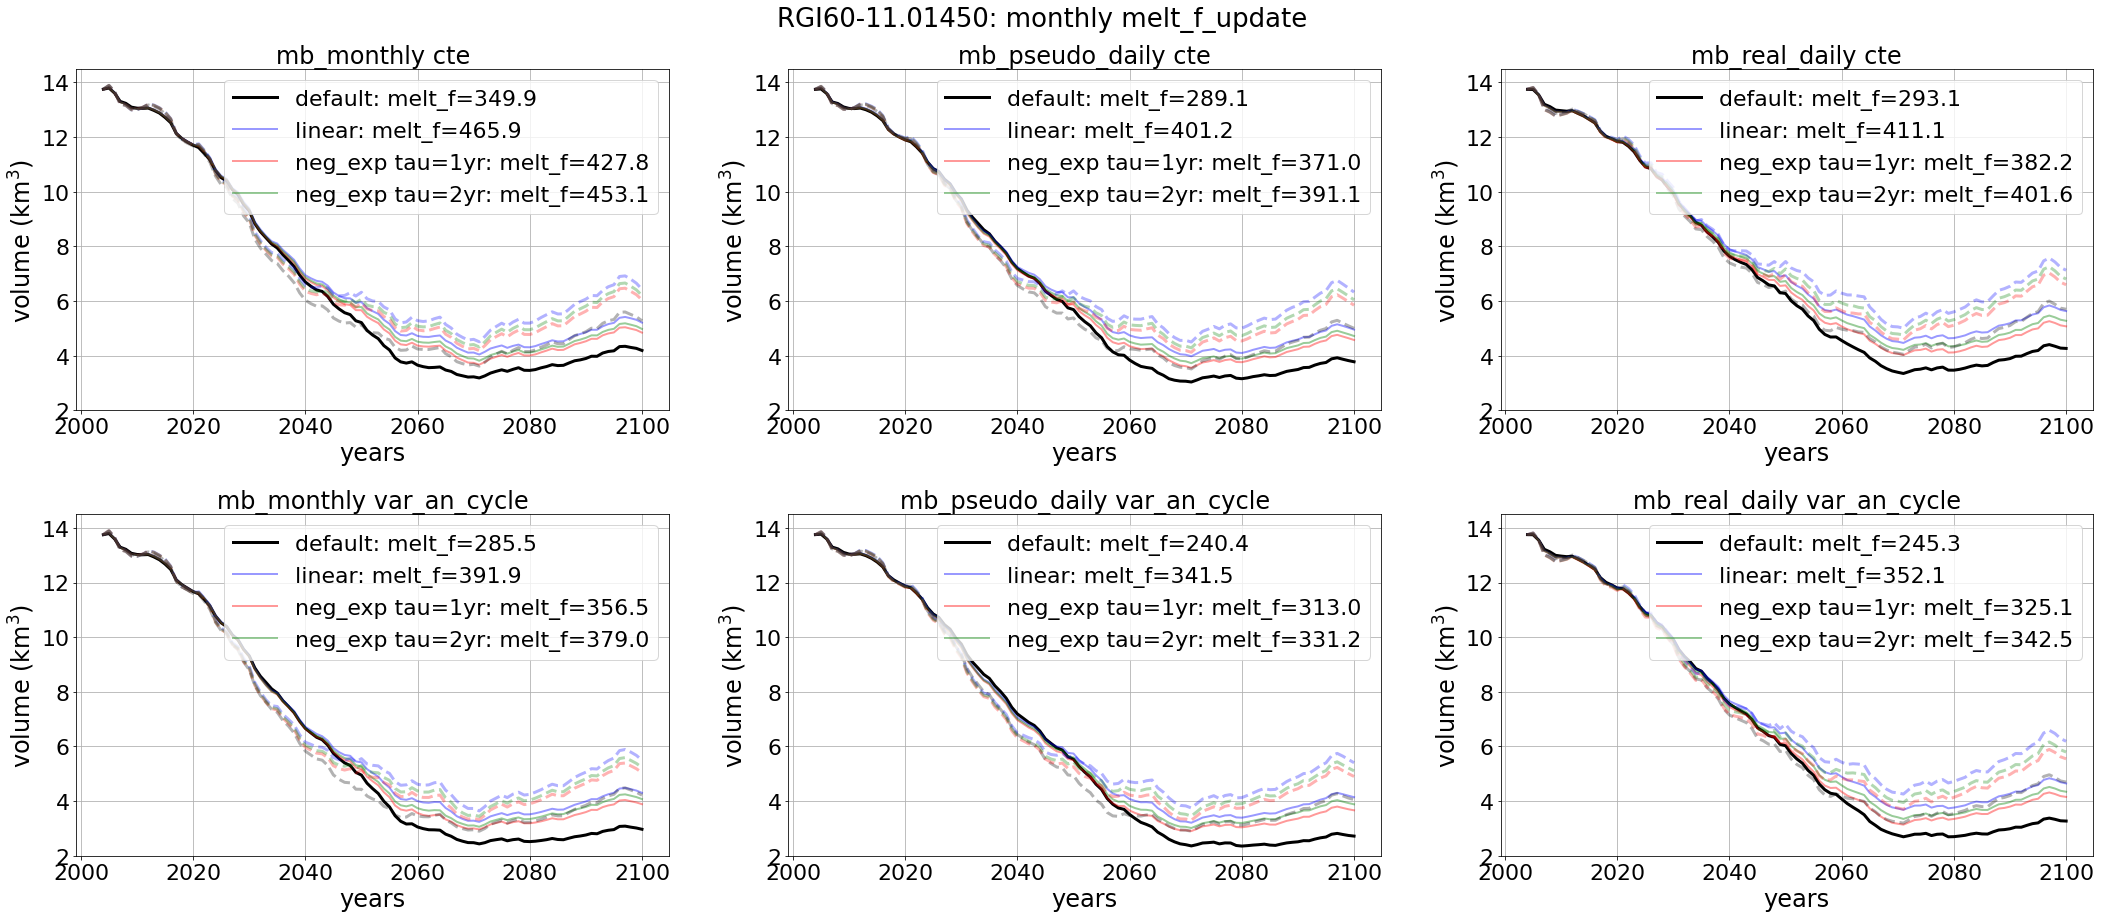

In [53]:
melt_f_update = 'monthly'

calendar_year = ds_default_random_TIModel[f'mb_monthly_cte_pf_1.5_melt_f_update_{melt_f_update}_run_type_{run_type}'].calendar_year
#calendar_year = ds_default_random_TIModel[f'mb_monthly_cte_pf_1.5_melt_f_update_{melt_f_update}'].calendar_year

plt.figure(figsize=(30,25))
j=0
plt.suptitle(f'{gdirs[-1].rgi_id}: {melt_f_update} melt_f_update')
pf_comp=True
#for pf in [1.5, 2.5]:
for grad_type in ['cte', 'var_an_cycle']:
    for mb_type in ['mb_monthly', 'mb_pseudo_daily', 'mb_real_daily']:

            j+=1

            try:
                #typ = f'{mb_type}_{grad_type}_pf_{pf}'
                #print(typ)
                #typ = f'{mb_type}_{grad_type}_pf_{pf}_melt_f_update_{melt_f_update}'


                plt.subplot(4,3,j)
                pf = 1.5
                typ = f'{mb_type}_{grad_type}_pf_{pf}_melt_f_update_{melt_f_update}_run_type_{run_type}'

                plt.plot(calendar_year, ds_default_random_TIModel[typ].volume/1e9, label = 'default: melt_f={:0.1f}'.format(melt_f_default_random_TIModel[typ]), ls='-', lw=3, alpha = 1, color = colors[0])
                #plt.plot(calendar_year, ds_default_random_ratio1[typ].volume/1e9, label = 'default ratio1: melt_f={:0.1f}'.format(melt_f_default_random_ratio1[typ]),  ls='--', lw=3, alpha = 1, color = colors[1])
                plt.plot(calendar_year, ds_linear_an_random[typ].volume/1e9, label = 'linear: melt_f={:0.1f}'.format(melt_f_linear_an_random[typ]), ls = '-', lw=2, alpha = 0.4, color = colors[2])
                plt.plot(calendar_year, ds_neg_exp_an_random_1[typ].volume/1e9, label = 'neg_exp tau=1yr: melt_f={:0.1f}'.format(melt_f_neg_exp_an_random_1[typ]), ls = '-', lw=2, alpha = 0.4, color = colors[3])
                plt.plot(calendar_year, ds_neg_exp_an_random_2[typ].volume/1e9, label = 'neg_exp tau=2yr: melt_f={:0.1f}'.format(melt_f_neg_exp_an_random_2[typ]), ls = '-', lw=2, alpha = 0.4, color = colors[4])


                #plt.plot(ds_linear_m_random.volume, label = 'linear_monthly_melt_f_update: melt_f={:0.1f}'.format(melt_f_linear_m_random))
                #plt.plot(ds_neg_exp_m_random_1.volume, label = 'neg_exp_monthly_melt_f_update: melt_f={:0.1f}, tau_e_fold =1'.format(melt_f_neg_exp_m_random_1))
                #plt.plot(ds_neg_exp_m_random_1_5.volume, label = 'neg_exp_monthly_melt_f_update: melt_f={:0.1f}, tau_e_fold=1.5'.format(melt_f_neg_exp_m_random_1_5))
                plt.xlabel('years')

                plt.ylabel(r'volume (km$^3$)')
                plt.legend()
                if pf_comp:
                    pf = 2.5
                    alpha=0.3
                    ls = '--'
                    typ = f'{mb_type}_{grad_type}_pf_{pf}_melt_f_update_{melt_f_update}_run_type_{run_type}'
                    plt.plot(calendar_year, ds_default_random_TIModel[typ].volume/1e9, label = 'default: melt_f={:0.1f}'.format(melt_f_default_random_TIModel[typ]), ls=ls, lw=3, alpha = alpha, color = colors[0])
                    #plt.plot(calendar_year, ds_default_random_ratio1[typ].volume/1e9, label = 'default ratio1: melt_f={:0.1f}'.format(melt_f_default_random_ratio1[typ]), ls='--', lw=3, alpha = alpha, color = colors[1])
                    plt.plot(calendar_year, ds_linear_an_random[typ].volume/1e9, label = 'linear: melt_f={:0.1f}'.format(melt_f_linear_an_random[typ]), ls = ls, lw=3, alpha = alpha, color = colors[2])
                    plt.plot(calendar_year, ds_neg_exp_an_random_1[typ].volume/1e9, label = 'neg_exp tau=1yr: melt_f={:0.1f}'.format(melt_f_neg_exp_an_random_1[typ]), ls = ls, lw=3, alpha = alpha, color = colors[3])
                    plt.plot(calendar_year, ds_neg_exp_an_random_2[typ].volume/1e9, label = 'neg_exp tau=2yr: melt_f={:0.1f}'.format(melt_f_neg_exp_an_random_2[typ]), ls = ls, lw=3, alpha = alpha, color = colors[4])

                if pf_comp==True:
                    plt.title(f'{mb_type} {grad_type}', fontsize=24)
                else:
                    plt.title(f'{mb_type} {grad_type}, prcp-fac:{pf}', fontsize=24)

                plt.ylim([2,14.5])
                plt.grid()
            except:
                pass
plt.tight_layout()
plt.savefig(f'{gdirs[-1].rgi_id}_{typ}_pf_comp_{pf_comp}.pdf', dpi=150, bbox_inches='tight')

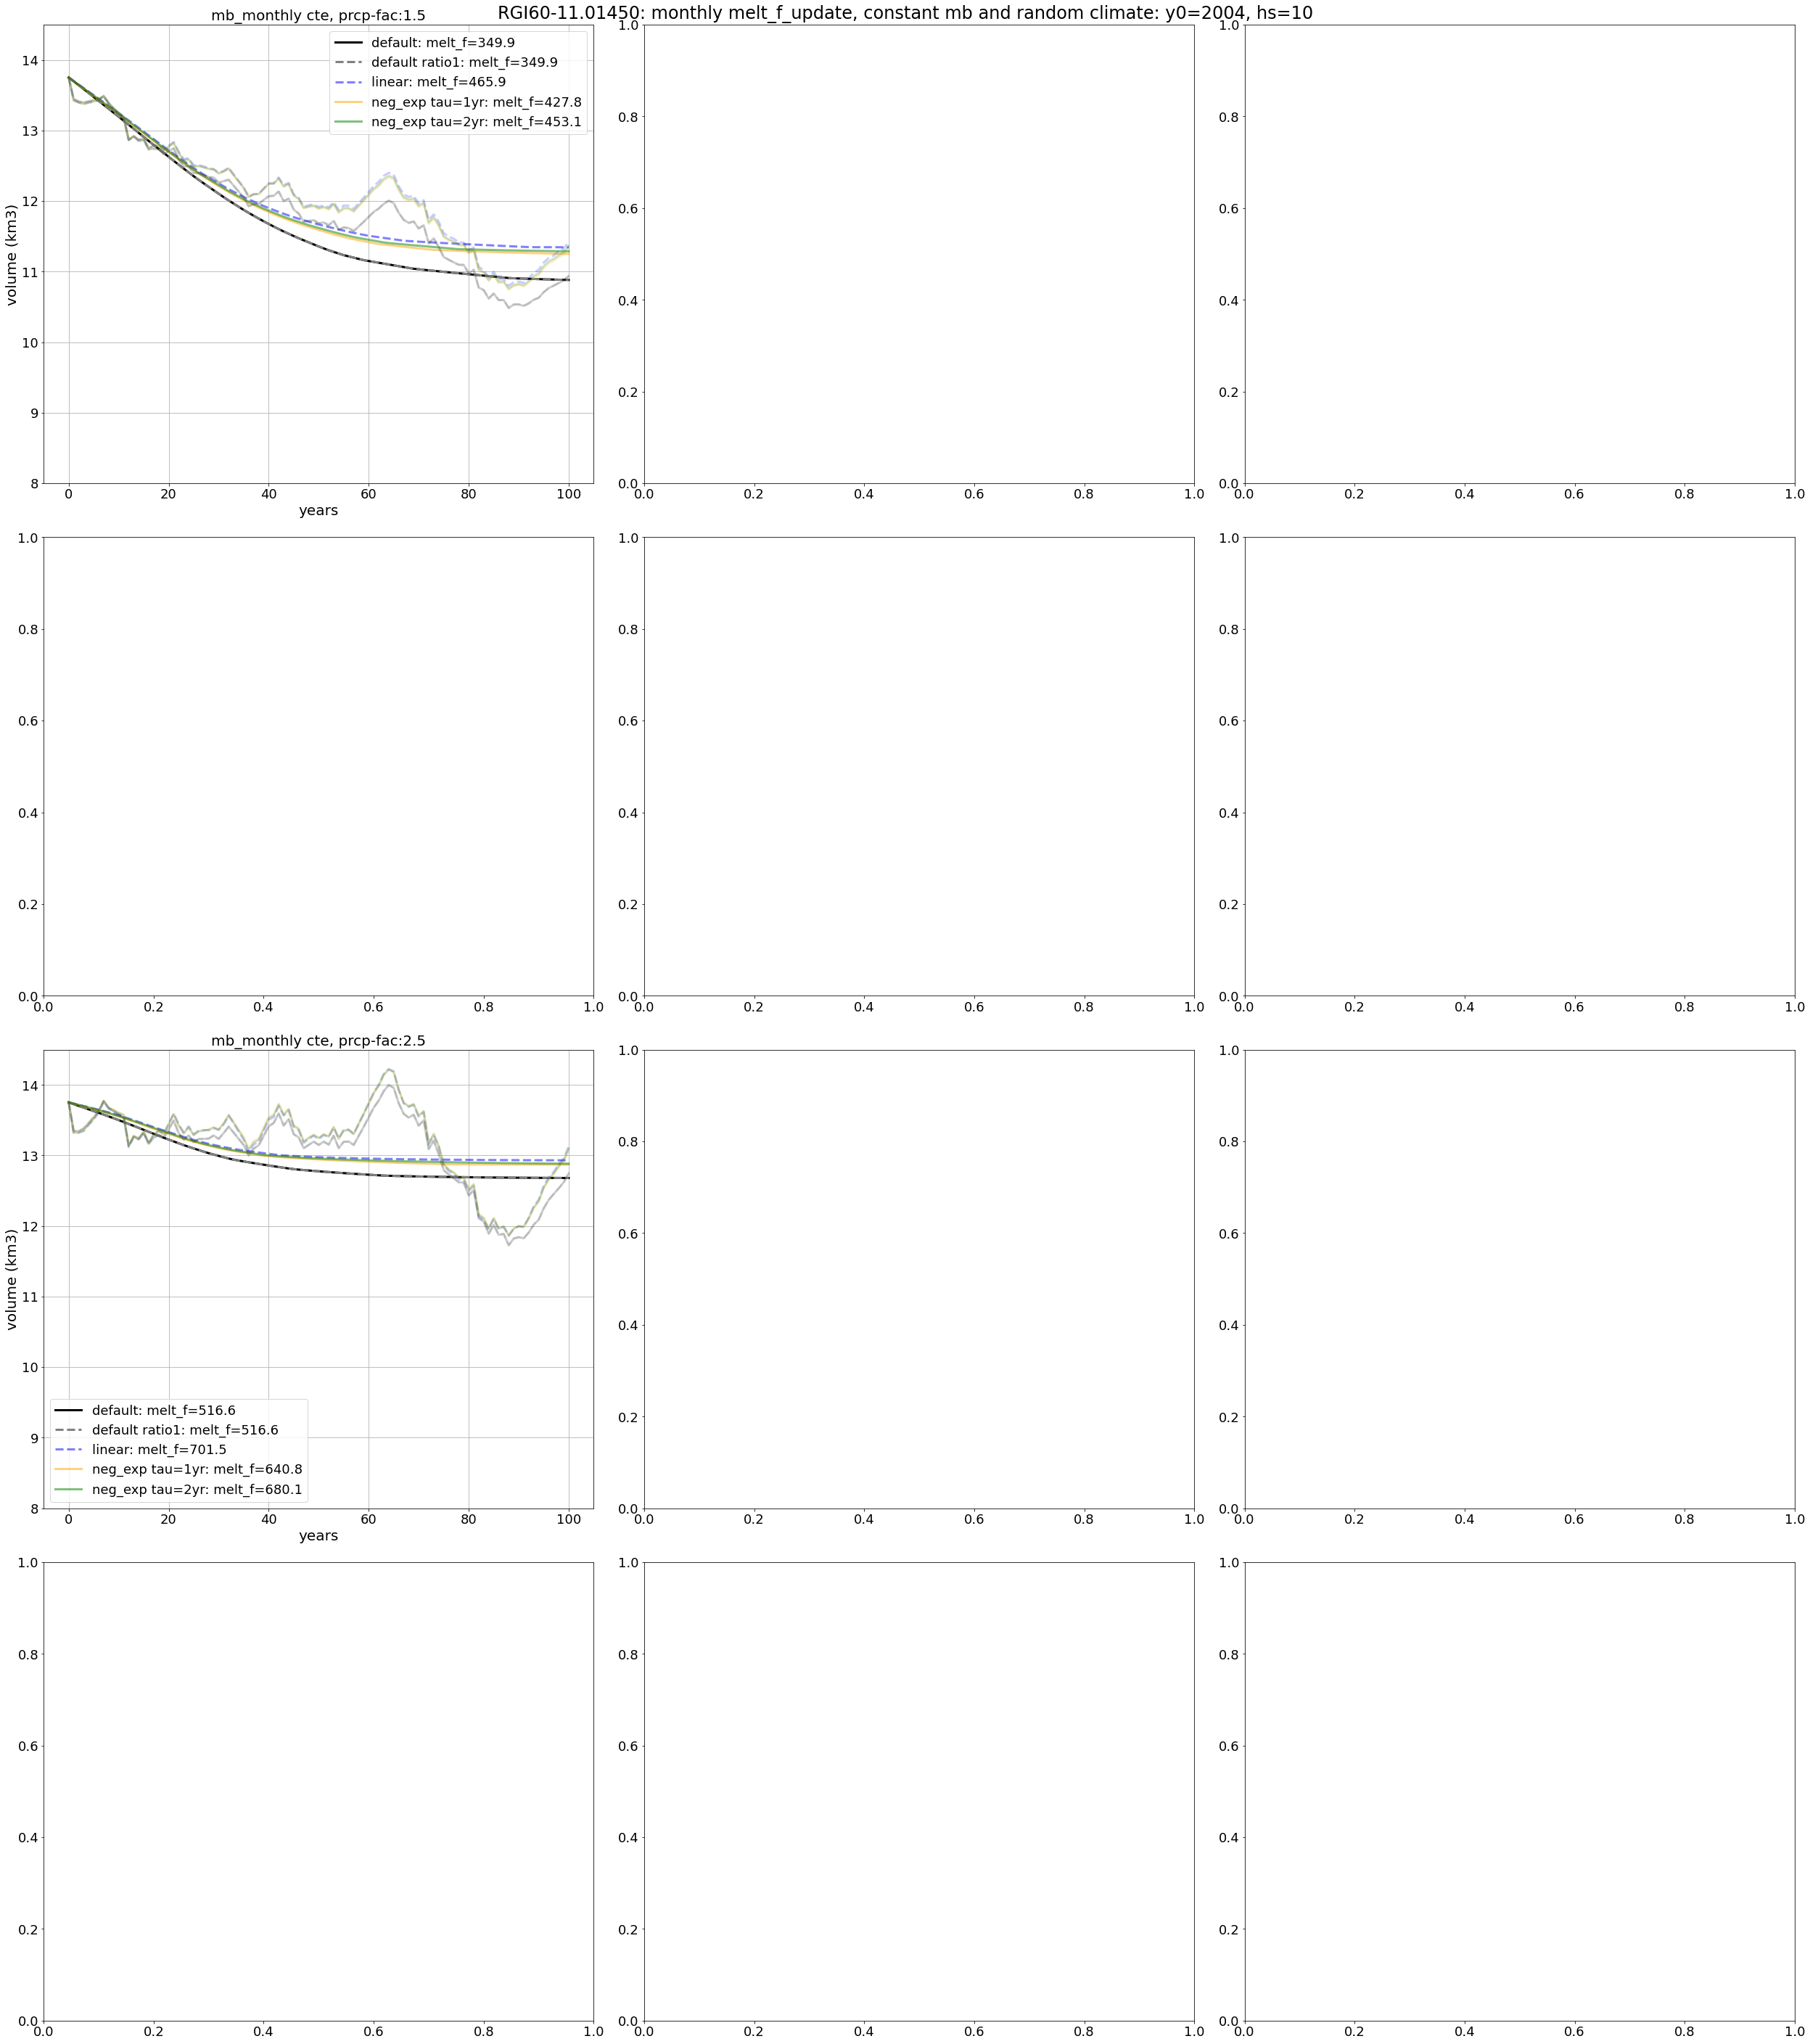

In [53]:
calendar_year = ds_default_random_TIModel[f'mb_monthly_cte_pf_1.5_melt_f_update_{melt_f_update}_run_type_{run_type}'].calendar_year
#calendar_year = ds_default_random_TIModel[f'mb_monthly_cte_pf_1.5_melt_f_update_{melt_f_update}'].calendar_year

plt.figure(figsize=(35,40))
j=0
plt.suptitle(f'{gdirs[-1].rgi_id}: {melt_f_update} melt_f_update, constant mb and random climate: y0=2004, hs=10')

for pf in [1.5, 2.5]:
    for grad_type in ['cte', 'var_an_cycle']:
        for mb_type in ['mb_monthly', 'mb_pseudo_daily', 'mb_real_daily']:

            j+=1

            try:
                #typ = f'{mb_type}_{grad_type}_pf_{pf}'
                #print(typ)
                #typ = f'{mb_type}_{grad_type}_pf_{pf}_melt_f_update_{melt_f_update}'


                plt.subplot(4,3,j)
                run_type = 'constant'
                typ = f'{mb_type}_{grad_type}_pf_{pf}_melt_f_update_{melt_f_update}_run_type_{run_type}'

                plt.plot(calendar_year, ds_default_random_TIModel[typ].volume/1e9, label = 'default: melt_f={:0.1f}'.format(melt_f_default_random_TIModel[typ]), ls='-', lw=3, alpha = 1, color = colors[0])
                plt.plot(calendar_year, ds_default_random_ratio1[typ].volume/1e9, label = 'default ratio1: melt_f={:0.1f}'.format(melt_f_default_random_ratio1[typ]),  ls='--', lw=3, alpha = 1, color = colors[1])
                plt.plot(calendar_year, ds_linear_an_random[typ].volume/1e9, label = 'linear: melt_f={:0.1f}'.format(melt_f_linear_an_random[typ]), ls = '--', lw=3, alpha = 0.5, color = colors[2])
                plt.plot(calendar_year, ds_neg_exp_an_random_1[typ].volume/1e9, label = 'neg_exp tau=1yr: melt_f={:0.1f}'.format(melt_f_neg_exp_an_random_1[typ]), ls = '-', lw=3, alpha = 0.5, color = colors[3])
                plt.plot(calendar_year, ds_neg_exp_an_random_2[typ].volume/1e9, label = 'neg_exp tau=2yr: melt_f={:0.1f}'.format(melt_f_neg_exp_an_random_2[typ]), ls = '-', lw=3, alpha = 0.5, color = colors[4])


                #plt.plot(ds_linear_m_random.volume, label = 'linear_monthly_melt_f_update: melt_f={:0.1f}'.format(melt_f_linear_m_random))
                #plt.plot(ds_neg_exp_m_random_1.volume, label = 'neg_exp_monthly_melt_f_update: melt_f={:0.1f}, tau_e_fold =1'.format(melt_f_neg_exp_m_random_1))
                #plt.plot(ds_neg_exp_m_random_1_5.volume, label = 'neg_exp_monthly_melt_f_update: melt_f={:0.1f}, tau_e_fold=1.5'.format(melt_f_neg_exp_m_random_1_5))
                plt.xlabel('years')

                plt.ylabel('volume (km3)')
                plt.legend()
                
                run_type = 'random'
                typ = f'{mb_type}_{grad_type}_pf_{pf}_melt_f_update_{melt_f_update}_run_type_{run_type}'
                plt.plot(calendar_year, ds_default_random_TIModel[typ].volume/1e9, label = 'default: melt_f={:0.1f}'.format(melt_f_default_random_TIModel[typ]), ls='-', lw=3, alpha = 0.2, color = colors[0])
                plt.plot(calendar_year, ds_default_random_ratio1[typ].volume/1e9, label = 'default ratio1: melt_f={:0.1f}'.format(melt_f_default_random_ratio1[typ]), ls='--', lw=3, alpha = 0.2, color = colors[1])
                plt.plot(calendar_year, ds_linear_an_random[typ].volume/1e9, label = 'linear: melt_f={:0.1f}'.format(melt_f_linear_an_random[typ]), ls = '--', lw=3, alpha = 0.2, color = colors[2])
                plt.plot(calendar_year, ds_neg_exp_an_random_1[typ].volume/1e9, label = 'neg_exp tau=1yr: melt_f={:0.1f}'.format(melt_f_neg_exp_an_random_1[typ]), ls = '-', lw=3, alpha = 0.2, color = colors[3])
                plt.plot(calendar_year, ds_neg_exp_an_random_2[typ].volume/1e9, label = 'neg_exp tau=2yr: melt_f={:0.1f}'.format(melt_f_neg_exp_an_random_2[typ]), ls = '-', lw=3, alpha = 0.2, color = colors[4])
                
                
                plt.title(f'{mb_type} {grad_type}, prcp-fac:{pf}', fontsize=20)

                plt.ylim([8,14.5])
                plt.grid()
            except:
                pass
plt.tight_layout()


In [ ]:
calendar_year = ds_default_random_TIModel['mb_monthly_cte_pf_1.5'].calendar_year
plt.figure(figsize=(35,18))
j=0
plt.suptitle(f'{gdirs[-1].rgi_id}: {melt_f_update} melt_f_update, {run_type} climate: y0=2004, hs=10')

for pf in [1.5, 2.5]:
    for mb_type in ['mb_monthly', 'mb_pseudo_daily']: #, 'mb_real_daily']:
        for grad_type in ['cte', 'var_an_cycle']:
            j+=1

            try:
                typ = f'{mb_type}_{grad_type}_pf_{pf}'

                plt.subplot(2,4,j)

                plt.plot(calendar_year, ds_default_random_TIModel[typ].volume/1e9-ds_default_random_TIModel[typ].volume/1e9, label = 'default: melt_f={:0.1f}'.format(melt_f_default_random_TIModel[typ]), color = 'black', ls='-', lw=3, alpha = 0.5)
                plt.plot(calendar_year, ds_default_random_ratio1[typ].volume/1e9-ds_default_random_TIModel[typ].volume/1e9, label = 'default ratio1: melt_f={:0.1f}'.format(melt_f_default_random_ratio1[typ]), color = 'grey', ls='--', lw=3, alpha = 0.5)

                plt.plot(calendar_year, ds_linear_an_random[typ].volume/1e9-ds_default_random_TIModel[typ].volume/1e9, label = 'linear: melt_f={:0.1f}'.format(melt_f_linear_an_random[typ]), ls = '--', lw=3, alpha = 0.5)
                plt.plot(calendar_year, ds_neg_exp_an_random_1[typ].volume/1e9-ds_default_random_TIModel[typ].volume/1e9, label = 'neg_exp tau=1yr: melt_f={:0.1f}'.format(melt_f_neg_exp_an_random_1[typ]), ls = '-', lw=3, alpha = 0.5)
                plt.plot(calendar_year, ds_neg_exp_an_random_2[typ].volume/1e9-ds_default_random_TIModel[typ].volume/1e9, label = 'neg_exp tau=2yr: melt_f={:0.1f}'.format(melt_f_neg_exp_an_random_2[typ]), ls = '-', lw=3, alpha = 0.5)


                #plt.plot(ds_linear_m_random.volume, label = 'linear_monthly_melt_f_update: melt_f={:0.1f}'.format(melt_f_linear_m_random))
                #plt.plot(ds_neg_exp_m_random_1.volume, label = 'neg_exp_monthly_melt_f_update: melt_f={:0.1f}, tau_e_fold =1'.format(melt_f_neg_exp_m_random_1))
                #plt.plot(ds_neg_exp_m_random_1_5.volume, label = 'neg_exp_monthly_melt_f_update: melt_f={:0.1f}, tau_e_fold=1.5'.format(melt_f_neg_exp_m_random_1_5))
                plt.xlabel('years')

                plt.ylabel('volume difference to default(km3)')
                plt.legend()
                plt.title(f'{mb_type} {grad_type}, prcp-fac:{pf}', fontsize=20)

                #plt.ylim([-0.035,0.035])
                plt.ylim([-1.5,1.5])

                plt.grid()
            except:
                pass
plt.tight_layout()


# Run from climate ...with monthly

In [9]:
interpolation_optim = True
y0 = 2004
hs = 10
melt_f_update = 'monthly' #'monthly' 
# melt_f_update = 'annual' #'monthly' 

# run_type = 'random'
for pf in [1.5, 2.5]:
    for grad_type in ['cte', 'var_an_cycle']:
        for mb_type in ['mb_monthly', 'mb_pseudo_daily', 'mb_real_daily']:
#for mb_type in ['mb_real_daily']:
            for run_type in ['from_climate']:
                #typ = f'{mb_type}_{grad_type}_pf_{pf}'
                typ = f'{mb_type}_{grad_type}_pf_{pf}_melt_f_update_{melt_f_update}_run_type_{run_type}'

                ds_default_random_TIModel[typ], melt_f_default_random_TIModel[typ],_ = calib_inv_run(gdir=gdirs[-1],mb_model_sub_class = TIModel,
                                                                      mb_elev_feedback = 'annual',mb_type=mb_type, grad_type=grad_type, pf=pf,
                                                                      nyears=nyears,
                                                                             run_type = run_type, interpolation_optim=interpolation_optim, y0=y0, hs=hs)

                ds_default_random_ratio1[typ], melt_f_default_random_ratio1[typ],_ = calib_inv_run(gdir=gdirs[-1],kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'linear', 'tau_e_fold_yr':20,
                                                                     'spinup_yrs':6,
                                                                     'melt_f_update':melt_f_update, 
                                                                     'melt_f_ratio_snow_to_ice':1},
                                                                      mb_elev_feedback = 'annual',
                                                                      nyears=nyears,mb_type=mb_type, grad_type=grad_type, pf=pf, interpolation_optim=interpolation_optim, y0=y0, hs=hs,
                                                                             run_type = run_type)

                ds_linear_an_random[typ], melt_f_linear_an_random[typ],_ = calib_inv_run(gdir=gdirs[-1],kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'linear',
                                                                     'tau_e_fold_yr':1,
                                                                     'spinup_yrs':6,
                                                                     'melt_f_update':melt_f_update, 
                                               'melt_f_ratio_snow_to_ice':0.5},
                                      mb_elev_feedback = 'annual', run_type = run_type,mb_type=mb_type, grad_type=grad_type, pf=pf, interpolation_optim=interpolation_optim, y0=y0, hs=hs,
                                     nyears=nyears,
                                     spinup=True)
                ds_neg_exp_an_random_1[typ], melt_f_neg_exp_an_random_1[typ],_ = calib_inv_run(gdir=gdirs[-1],kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'neg_exp',
                                                                     'tau_e_fold_yr':1,
                                                                     'spinup_yrs':6,
                                                                     'melt_f_update':melt_f_update,
                                               'melt_f_ratio_snow_to_ice':0.5},
                                      mb_elev_feedback = 'annual',run_type = run_type,mb_type=mb_type, grad_type=grad_type, pf=pf, interpolation_optim=interpolation_optim, y0=y0, hs=hs,
                                     nyears=nyears,
                                     spinup=True)

                ds_neg_exp_an_random_2[typ], melt_f_neg_exp_an_random_2[typ],_ = calib_inv_run(gdir=gdirs[-1], kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'neg_exp',
                                                                     'tau_e_fold_yr':2,
                                                                     'spinup_yrs':6,
                                                                     'melt_f_update':melt_f_update,
                                               'melt_f_ratio_snow_to_ice':0.5},
                                      mb_elev_feedback = 'annual',run_type = run_type, mb_type=mb_type, grad_type=grad_type, pf=pf, interpolation_optim=interpolation_optim, y0=y0, hs=hs,
                                     nyears=nyears,
                                     spinup=True)
                print(typ)

mb_monthly_cte_pf_1.5_melt_f_update_monthly_run_type_from_climate
mb_pseudo_daily_cte_pf_1.5_melt_f_update_monthly_run_type_from_climate
mb_real_daily_cte_pf_1.5_melt_f_update_monthly_run_type_from_climate
mb_monthly_var_an_cycle_pf_1.5_melt_f_update_monthly_run_type_from_climate


KeyboardInterrupt: 

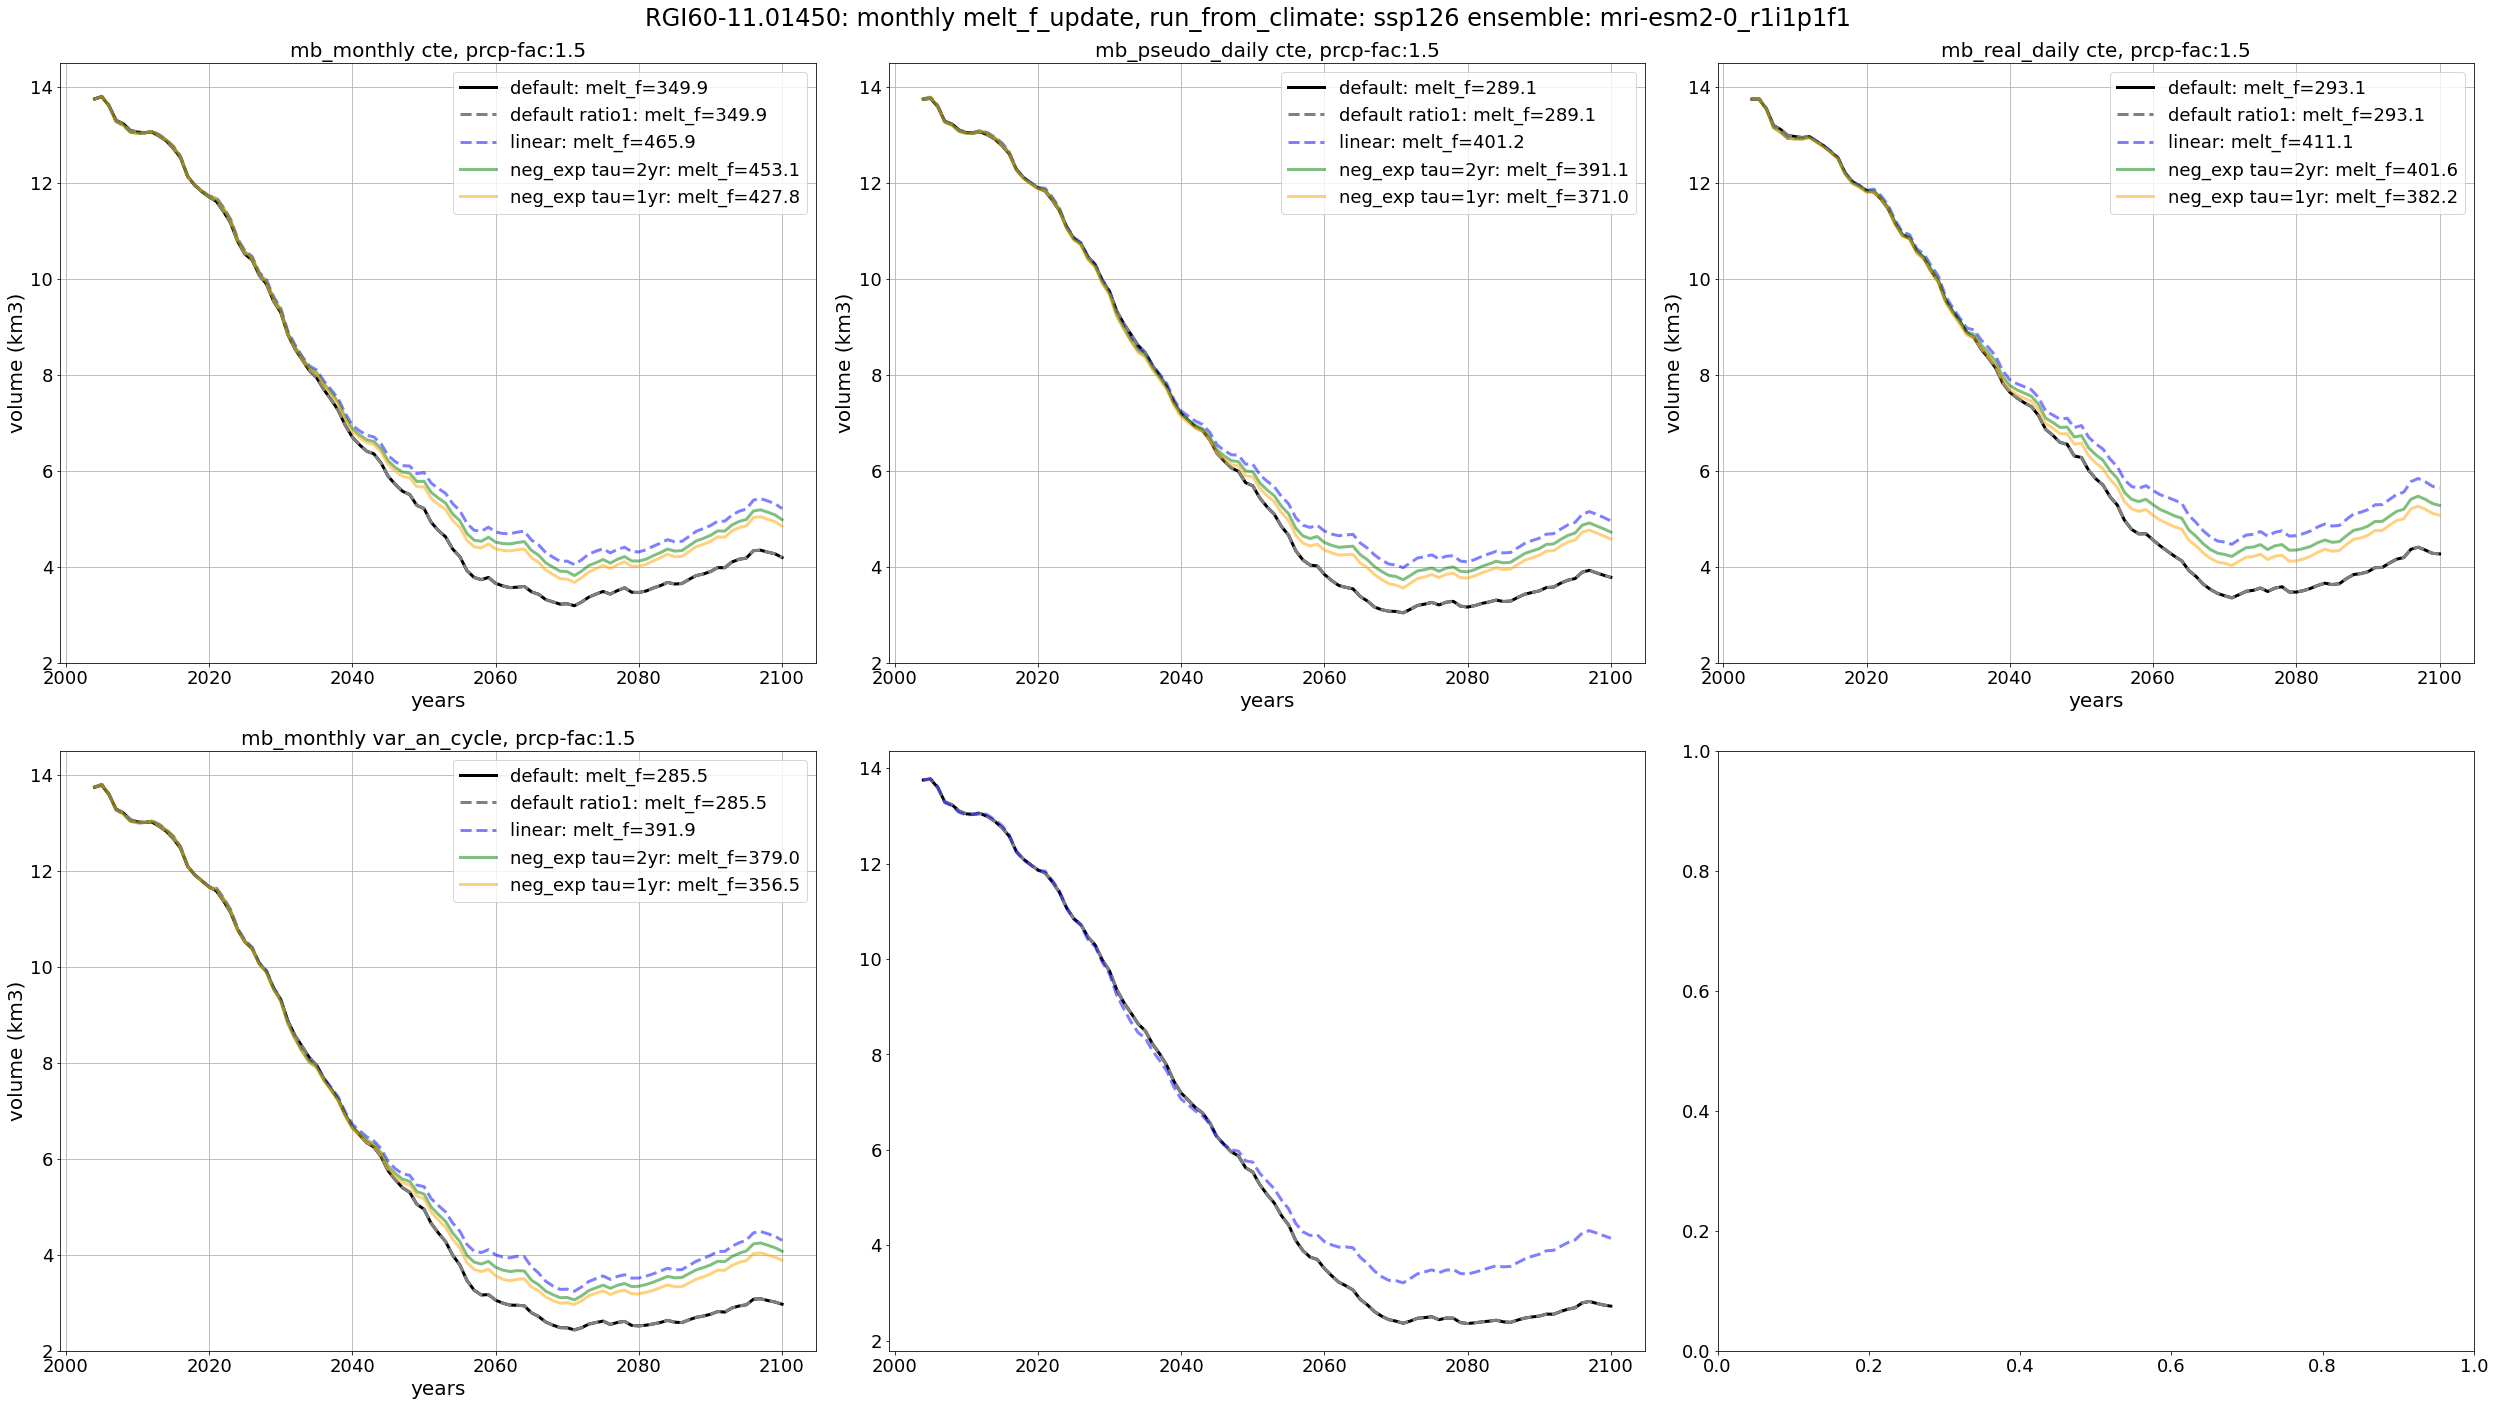

In [30]:
colors = ['black', 'grey', 'blue', 'orange', 'green']
calendar_year = ds_default_random_TIModel[f'mb_monthly_cte_pf_1.5_melt_f_update_{melt_f_update}_run_type_{run_type}'].calendar_year
#calendar_year = ds_default_random_TIModel[f'mb_monthly_cte_pf_1.5_melt_f_update_{melt_f_update}'].calendar_year

plt.figure(figsize=(35,20))
j=0
plt.suptitle(f'{gdirs[-1].rgi_id}: {melt_f_update} melt_f_update, run_from_climate: ssp126 ensemble: {ensemble}')

for pf in [1.5, 2.5]:
    for grad_type in ['cte', 'var_an_cycle']:
        for mb_type in ['mb_monthly', 'mb_pseudo_daily', 'mb_real_daily']:

            j+=1

            try:
                #typ = f'{mb_type}_{grad_type}_pf_{pf}'
                #print(typ)
                #typ = f'{mb_type}_{grad_type}_pf_{pf}_melt_f_update_{melt_f_update}'


                plt.subplot(2,3,j)
                #run_type = 'constant'
                typ = f'{mb_type}_{grad_type}_pf_{pf}_melt_f_update_{melt_f_update}_run_type_{run_type}'
                #print(ds_default_random_TIModel[typ].volume/1e9)
                plt.plot(calendar_year, ds_default_random_TIModel[typ].volume/1e9, label = 'default: melt_f={:0.1f}'.format(melt_f_default_random_TIModel[typ]), ls='-', lw=3, alpha = 1, color = colors[0])
                plt.plot(calendar_year, ds_default_random_ratio1[typ].volume/1e9, label = 'default ratio1: melt_f={:0.1f}'.format(melt_f_default_random_ratio1[typ]),  ls='--', lw=3, alpha = 1, color = colors[1])
                plt.plot(calendar_year, ds_linear_an_random[typ].volume/1e9, label = 'linear: melt_f={:0.1f}'.format(melt_f_linear_an_random[typ]), ls = '--', lw=3, alpha = 0.5, color = colors[2])
                plt.plot(calendar_year, ds_neg_exp_an_random_2[typ].volume/1e9, label = 'neg_exp tau=2yr: melt_f={:0.1f}'.format(melt_f_neg_exp_an_random_2[typ]), ls = '-', lw=3, alpha = 0.5, color = colors[4])
                plt.plot(calendar_year, ds_neg_exp_an_random_1[typ].volume/1e9, label = 'neg_exp tau=1yr: melt_f={:0.1f}'.format(melt_f_neg_exp_an_random_1[typ]), ls = '-', lw=3, alpha = 0.5, color = colors[3])


                #plt.plot(ds_linear_m_random.volume, label = 'linear_monthly_melt_f_update: melt_f={:0.1f}'.format(melt_f_linear_m_random))
                #plt.plot(ds_neg_exp_m_random_1.volume, label = 'neg_exp_monthly_melt_f_update: melt_f={:0.1f}, tau_e_fold =1'.format(melt_f_neg_exp_m_random_1))
                #plt.plot(ds_neg_exp_m_random_1_5.volume, label = 'neg_exp_monthly_melt_f_update: melt_f={:0.1f}, tau_e_fold=1.5'.format(melt_f_neg_exp_m_random_1_5))
                plt.xlabel('years')

                plt.ylabel('volume (km3)')
                plt.legend()
                
                #run_type = 'random'
                #typ = f'{mb_type}_{grad_type}_pf_{pf}_melt_f_update_{melt_f_update}_run_type_{run_type}'
                #plt.plot(calendar_year, ds_default_random_TIModel[typ].volume/1e9, label = 'default: melt_f={:0.1f}'.format(melt_f_default_random_TIModel[typ]), ls='-', lw=3, alpha = 0.2, color = colors[0])
                #plt.plot(calendar_year, ds_default_random_ratio1[typ].volume/1e9, label = 'default ratio1: melt_f={:0.1f}'.format(melt_f_default_random_ratio1[typ]), ls='--', lw=3, alpha = 0.2, color = colors[1])
                #plt.plot(calendar_year, ds_linear_an_random[typ].volume/1e9, label = 'linear: melt_f={:0.1f}'.format(melt_f_linear_an_random[typ]), ls = '--', lw=3, alpha = 0.2, color = colors[2])
                #plt.plot(calendar_year, ds_neg_exp_an_random_1[typ].volume/1e9, label = 'neg_exp tau=1yr: melt_f={:0.1f}'.format(melt_f_neg_exp_an_random_1[typ]), ls = '-', lw=3, alpha = 0.2, color = colors[3])
                #plt.plot(calendar_year, ds_neg_exp_an_random_2[typ].volume/1e9, label = 'neg_exp tau=2yr: melt_f={:0.1f}'.format(melt_f_neg_exp_an_random_2[typ]), ls = '-', lw=3, alpha = 0.2, color = colors[4])
                
                
                plt.title(f'{mb_type} {grad_type}, prcp-fac:{pf}', fontsize=20)

                plt.ylim([2,14.5])
                plt.grid()
            except:
                pass
plt.tight_layout()


# Trash

In [ ]:
melt_f_update = 'monthly'
nyears = 300
ds_random_ratio1_a_fb_monthly_step, melt_f_random_ratio1_a_fb_monthly_step, run_model_random_ratio1_a_fb_monthly_step = calib_inv_run(gdir=gdirs[-1], kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'linear', 'tau_e_fold_yr':20,
                                                     'spinup_yrs':6,
                                                     'melt_f_update':melt_f_update, 
                                                     'melt_f_ratio_snow_to_ice':1},
                                                      mb_elev_feedback = 'annual',
                                                      nyears=nyears,mb_type=mb_type, grad_type=grad_type, pf=pf, hs=10, store_monthly_step=True,
                                                             run_type = 'random')

ds_default_random_a_fb_monthly_step, melt_f_default_random_a_fb_monthly_step, run_model_random_a_fb_monthly_step = calib_inv_run(gdir=gdirs[-1], mb_model_sub_class = TIModel,
                                                      mb_elev_feedback = 'annual',
                                                      nyears=nyears,mb_type=mb_type, grad_type=grad_type, pf=pf, store_monthly_step=True,
                                                             run_type = 'random', hs=10)

In [ ]:
melt_f_random_ratio1_a_fb_annual_update

In [ ]:

ds_random_ratio1_a_fb_annual_update, melt_f_random_ratio1_a_fb_annual_update, run_model_random_ratio1_a_fb_annual_update = calib_inv_run(gdir=gdirs[-1], kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'linear', 'tau_e_fold_yr':20,
                                                     'spinup_yrs':6,
                                                     'melt_f_update':'annual', 
                                                     'melt_f_ratio_snow_to_ice':1},
                                                      mb_elev_feedback = 'annual',
                                                      nyears=nyears,mb_type=mb_type, grad_type=grad_type, pf=pf, hs=10,
                                                             run_type = 'random')


In [ ]:
run_model_random_ratio1_a_fb.mb_model.flowline_mb_models[-1].check_availability

In [ ]:
melt_f_update = 'monthly'
nyears = 10
ds_random_ratio1_a_fb, melt_f_random_ratio1_a_fb, run_model_random_ratio1_a_fb = calib_inv_run(gdir=gdirs[-1], kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'linear', 'tau_e_fold_yr':20,
                                                     'spinup_yrs':6,
                                                     'melt_f_update':melt_f_update, 
                                                     'melt_f_ratio_snow_to_ice':1},
                                                      mb_elev_feedback = 'annual',
                                                      nyears=nyears,mb_type=mb_type, grad_type=grad_type, pf=pf, hs=1,
                                                             run_type = 'random', unique_samples=True)



In [ ]:
melt_f_random_ratio1_a_fb

In [ ]:
ds_default_random_a_fb, melt_f_default_random_a_fb, run_model_random_a_fb = calib_inv_run(gdir=gdirs[-1], mb_model_sub_class = TIModel,
                                                      mb_elev_feedback = 'annual',
                                                      nyears=nyears,mb_type=mb_type, grad_type=grad_type, pf=pf,
                                                             run_type = 'random', hs=1, unique_samples=True)


In [ ]:
np.testing.assert_allclose(ds_random_ratio1_a_fb.volume, ds_default_random_a_fb.volume)

In [ ]:
pd_def = run_model_random_a_fb.mb_model.flowline_mb_models[-1]._mb_debug_container
pd_ratio = run_model_random_ratio1_a_fb.mb_model.flowline_mb_models[-1]._mb_debug_container
#pd_ratio_annual_update = run_model_random_ratio1_a_fb_annual_update.mb_model.flowline_mb_models[-1]._mb_debug_container

In [ ]:
assert np.all(pd_ratio.ryr == pd_def.ryr)

In [ ]:
ryrs = []
for t in np.arange(0,100):
    ryrs.append(run_model_random_ratio1_a_fb.mb_model.flowline_mb_models[-1].get_state_yr(t))

In [ ]:
run_model_random_ratio1_a_fb.mb_model.flowline_mb_models[-1].unique_samples

In [ ]:
len(set(pdx[pdx.ryr == ryr].mb))

In [ ]:
plt.figure(figsize=(30,25))

for j, ryr in enumerate(set(pd_def.ryr)):
    plt.subplot(6,5,j+1)
    pdx = pd_ratio
    for yr in set(pdx[pdx.ryr == ryr].yr):
        #print(yr)
        plt.plot(pdx[pdx.ryr == ryr][pdx[pdx.ryr == ryr].yr==yr].mb, '.', label = yr)
        # for yr in set(pdx[pdx.ryr == ryr].yr):
        plt.plot(pd_def[pd_def.ryr == ryr][pd_def[pd_def.ryr == ryr].yr==yr].mb, '-', color = 'grey', alpha = 0.7, lw=6)
    plt.legend(title='year')

    plt.title(f'random year: {ryr}')
    plt.ylabel('heights (m)')

In [ ]:
plt.figure(figsize=(30,25))

for j, ryr in enumerate(set(pd_def.ryr)):
    plt.subplot(6,5,j+1)
    pdx = pd_ratio
    for yr in set(pdx[pdx.ryr == ryr].yr):
        #print(yr)
        plt.plot(pdx[pdx.ryr == ryr][pdx[pdx.ryr == ryr].yr==yr].heights, '.', label = yr)
        # for yr in set(pdx[pdx.ryr == ryr].yr):
        plt.plot(pd_def[pd_def.ryr == ryr][pd_def[pd_def.ryr == ryr].yr==yr].heights, '-', color = 'grey', alpha = 0.7, lw=6)
    plt.legend(title='year')

    plt.title(f'random year: {ryr}')
    plt.ylabel('heights (m)')

In [ ]:
plt.figure(figsize=(30,25))

for j, ryr in enumerate(set(pd_def.ryr)):
    plt.subplot(6,5,j+1)
    pdx = pd_ratio
    for yr in set(pdx[pdx.ryr == ryr].yr):
        #print(yr)
        plt.plot(pdx[pdx.ryr == ryr][pdx[pdx.ryr == ryr].yr==yr].mb, pdx[pdx.ryr == ryr][pdx[pdx.ryr == ryr].yr==yr].heights, '.', label = yr)
        # for yr in set(pdx[pdx.ryr == ryr].yr):
        plt.plot(pd_def[pd_def.ryr == ryr][pd_def[pd_def.ryr == ryr].yr==yr].mb, pd_def[pd_def.ryr == ryr][pd_def[pd_def.ryr == ryr].yr==yr].heights, '-', color = 'grey', alpha = 0.4, lw=6)
    plt.legend(title='year')

    plt.title(f'random year: {ryr}')
    plt.ylabel('heights (m)')

- less ablation for the same altitude

In [ ]:
pd_def[pd_def.index==35]

In [ ]:
pd_ratio[pd_ratio.index==35]

In [ ]:
np.testing.assert_allclose(pd_ratio[pd_ratio.ryr == 2006][pd_ratio[pd_ratio.ryr == 2006].yr==0], pd_def[pd_def.ryr == 2006][pd_def[pd_def.ryr == 2006].yr==0])

In [ ]:
ryr = 200
pd_ratio_annual_update[pd_ratio_annual_update.ryr==ryr][pd_ratio_annual_update[pd_ratio_annual_update.ryr==ryr].yr==yr].heights

In [ ]:
pd_def[pd_def.ryr == 2006][pd_def[pd_def.ryr == 2006].yr==yr]

In [ ]:
plt.plot(pd_def.heights, '.')

In [ ]:
plt.plot(pd_ratio.heights, '.')

In [ ]:
plt.plot(pd_ratio[pd_ratio.ryr == 2006][pd_ratio[pd_ratio.ryr == 2006].yr==yr].mb, 
         pd_ratio[pd_ratio.ryr == 2006][pd_ratio[pd_ratio.ryr == 2006].yr==yr].heights, '.', label='ratio 1', lw=2)

In [ ]:
pd_ratio[pd_ratio.ryr == 2006][pd_ratio[pd_ratio.ryr == 2006].yr==yr]

In [ ]:
yr = 66
#plt.plot(pd_ratio_annual_update[pd_ratio_annual_update.ryr == 2006][pd_ratio_annual_update[pd_ratio_annual_update.ryr == 2006].yr==yr].mb, 
#         pd_ratio_annual_update[pd_ratio_annual_update.ryr == 2006][pd_ratio_annual_update[pd_ratio_annual_update.ryr == 2006].yr==yr].heights, '.', label='ratio 1 annual update', lw=2)
plt.plot(pd_ratio[pd_ratio.ryr == 2006][pd_ratio[pd_ratio.ryr == 2006].yr==yr].mb, 
         pd_ratio[pd_ratio.ryr == 2006][pd_ratio[pd_ratio.ryr == 2006].yr==yr].heights, '.', label='ratio 1', lw=2)
plt.plot(pd_def[pd_def.ryr == 2006][pd_def[pd_def.ryr == 2006].yr==yr].mb, 
         pd_def[pd_def.ryr == 2006][pd_def[pd_def.ryr == 2006].yr==yr].heights, '.',label='default', lw=2)
plt.legend()
np.testing.assert_allclose(pd_ratio[pd_ratio.ryr == 2006][pd_ratio[pd_ratio.ryr == 2006].yr==yr], pd_def[pd_def.ryr == 2006][pd_def[pd_def.ryr == 2006].yr==yr])

In [ ]:
set(pd_def[pd_def.ryr == 2002].yr)


In [ ]:
set(pd_ratio[pd_ratio.ryr == 2006].yr)

In [ ]:
pd_def[pd_def.ryr == 2006][pd_def[pd_def.ryr == 2006].yr==81]

In [ ]:
pd.DataFrame(h)

In [ ]:
plt.plot(ds_random_ratio1_a_fb.volume)
plt.plot(ds_default_random_a_fb.volume)

# Trash

In [ ]:

df_past = {}
df_const = {}
ds_rdn = {}
ds_const = {}
ds_avg = {}
years = np.arange(2004-10, 2004+10+1)





In [ ]:
mb_past = TIModel(gdirs[-1],melt_f_calib,  prcp_fac=pf, mb_type = mb_type, grad_type = grad_type,
              baseline_climate = climate_type) #filename='gcm_data', baseline_climate = climate_type_gcm

mb = []
for f in np.arange(0,50):
    for y in years:
        tmp = mb_past.get_annual_mb(h, y) * cfg.SEC_IN_YEAR * cfg.PARAMS['ice_density']
        mb.append(np.average(tmp, weights=w))
        
mb_past_sfc_type = TIModel_Sfc_Type(gdirs[-1],melt_f_calib,  prcp_fac=pf, mb_type = mb_type, grad_type = grad_type,
              baseline_climate = climate_type, melt_f_ratio_snow_to_ice=1) #filename='gcm_data', baseline_climate = climate_type_gcm

mb_sfc_type = []
for f in np.arange(0,50):
    for y in years:
        tmp = mb_past_sfc_type.get_annual_mb(h, y) * cfg.SEC_IN_YEAR * cfg.PARAMS['ice_density']
        mb_sfc_type.append(np.average(tmp, weights=w))
np.testing.assert_allclose(mb, mb_sfc_type)

In [ ]:
from MBsandbox.mbmod_daily_oneflowline import RandomMassBalance_TIModel

In [ ]:
mb_random = RandomMassBalance_TIModel(gdirs[-1], melt_f_calib,  prcp_fac=pf,
                                       mb_type = mb_type, grad_type = grad_type,
                                       baseline_climate = climate_type, 
                                       #baseline_climate = climate_type_gcm, filename='gcm_data',
                                       y0=2004, halfsize=10, seed = 0)
mb = []
for f in np.arange(0,20):
    for y in years:
        tmp = mb_random.get_annual_mb(h, y) * cfg.SEC_IN_YEAR * cfg.PARAMS['ice_density']
        mb.append(np.average(tmp, weights=w))
        
mb_random_sfc_type = RandomMassBalance_TIModel(gdirs[-1], melt_f_calib,  prcp_fac=pf,
                                               mb_model_sub_class=TIModel_Sfc_Type,
                                       mb_type = mb_type, grad_type = grad_type,
                                       baseline_climate = climate_type, 
                                       #baseline_climate = climate_type_gcm, filename='gcm_data',
                                       y0=2004, halfsize=10, melt_f_ratio_snow_to_ice=1, seed=0,
                                               melt_f_update = 'monthly' # for annual melt_f_update it works
                                              )
for y00 in np.arange(1994-6,1994):
    mb_random_sfc_type.mbmod.get_annual_mb(h, y00, spinup=False, auto_spinup=False)
    mb_random_sfc_type.mbmod.spinup_yrs = 0
#print(mb_random_sfc_type.mbmod.pd_mb_annual)
mb_sfc_type = []
for f in np.arange(0,20):
    print(f)
    for y in years:
        tmp = mb_random_sfc_type.get_annual_mb(h,y) * cfg.SEC_IN_YEAR * cfg.PARAMS['ice_density']
        mb_sfc_type.append(np.average(tmp, weights=w))

np.testing.assert_allclose(mb, mb_sfc_type)

In [ ]:
plt.plot(mb, '.')
plt.plot(mb_sfc_type, '.')

In [ ]:
nyears=100
melt_f_update = 'annual'

ds_default_from_climate_TIModel, melt_f_default_from_climate_TIModel = calib_inv_run(gdir=gdirs[-1], mb_model_sub_class = TIModel,
                                                      mb_elev_feedback = melt_f_update,mb_type=mb_type, grad_type=grad_type, pf=pf,
                                                      nyears=nyears,
                                                             run_type = 'from_climate')
ds_default_from_climate_TIModel_ratio1, melt_f_default_from_climate_TIModel_ratio1 = calib_inv_run(gdir=gdirs[-1], mb_model_sub_class = TIModel_Sfc_Type,
                                                                                                       kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'linear', 'tau_e_fold_yr':20,
                                                     'spinup_yrs':6,
                                                     'melt_f_update':melt_f_update, 
                                                     'melt_f_ratio_snow_to_ice':1},
                                                      mb_elev_feedback = melt_f_update, mb_type=mb_type, grad_type=grad_type, pf=pf,
                                                      nyears=nyears,
                                                             run_type = 'from_climate')
np.testing.assert_allclose(ds_default_from_climate_TIModel.volume, ds_default_from_climate_TIModel_ratio1.volume)

In [ ]:
melt_f_update = 'monthly'

ds_default_from_climate_TIModel, melt_f_default_from_climate_TIModel = calib_inv_run(gdir=gdirs[-1], mb_model_sub_class = TIModel,
                                                      mb_elev_feedback = melt_f_update,mb_type=mb_type, grad_type=grad_type, pf=pf,
                                                      nyears=nyears,
                                                             run_type = 'from_climate')

ds_default_from_climate_TIModel_ratio1, melt_f_default_from_climate_TIModel_ratio1 = calib_inv_run(gdir=gdirs[-1], mb_model_sub_class = TIModel_Sfc_Type,
                                                                                                       kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'linear', 'tau_e_fold_yr':20,
                                                     'spinup_yrs':6,
                                                     'melt_f_update':melt_f_update, 
                                                     'melt_f_ratio_snow_to_ice':1},
                                                      mb_elev_feedback = melt_f_update, mb_type=mb_type, grad_type=grad_type, pf=pf,
                                                      nyears=nyears,
                                                             run_type = 'from_climate')
np.testing.assert_allclose(ds_default_from_climate_TIModel.volume, ds_default_from_climate_TIModel_ratio1.volume)

In [ ]:
ds_default_from_climate_TIModel_annual_elev_fb, melt_f_default_from_climate_TIModel_annual_elev_fb = calib_inv_run(gdir=gdirs[-1], mb_model_sub_class = TIModel,
                                                      mb_elev_feedback = 'annual', mb_type=mb_type, grad_type=grad_type, pf=pf,
                                                      nyears=nyears, 
                                                             run_type = 'from_climate')

In [ ]:
ds_default_from_climate_TIModel_ratio1_annual_elev_fb, melt_f_default_from_climate_TIModel_ratio1_annual_elev_fb = calib_inv_run(gdir=gdirs[-1], mb_model_sub_class = TIModel_Sfc_Type,
                                                                                                       kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'linear', 'tau_e_fold_yr':20,
                                                     'spinup_yrs':6,
                                                     'melt_f_update':melt_f_update, 
                                                     'melt_f_ratio_snow_to_ice':1},
                                                      mb_elev_feedback = 'annual', mb_type=mb_type, grad_type=grad_type, pf=pf,
                                                      nyears=nyears,
                                                             run_type = 'from_climate')

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(ds_default_from_climate_TIModel.volume, label='monthly_elev_fb')
plt.plot(ds_default_from_climate_TIModel_annual_elev_fb.volume, label='annual_elev_fb')
plt.plot(ds_default_from_climate_TIModel_ratio1.volume, label='monthly_elev_fb ratio 1')
plt.plot(ds_default_from_climate_TIModel_annual_elev_fb.volume, label='annual_elev_fb ratio 1')
plt.legend()

In [ ]:
np.testing.assert_allclose(ds_default_from_climate_TIModel.volume, ds_default_from_climate_TIModel_ratio1.volume)

In [ ]:
ds_default_cte_TIModel = {}
melt_f_default_cte_TIModel = {}
ds_default_cte_ratio1 = {}
melt_f_default_cte_ratio1 = {}

nyears = 50

typ = f'{mb_type}_{grad_type}_pf_{pf}'
melt_f_update = 'monthly'
ds_default_cte_TIModel[typ], melt_f_default_cte_TIModel[typ] = calib_inv_run(gdir=gdirs[-1], mb_model_sub_class = TIModel,
                                                      mb_elev_feedback = 'annual',
                                                      nyears=nyears,mb_type=mb_type, grad_type=grad_type, pf=pf,
                                                             run_type = 'cte')

ds_default_cte_ratio1[typ], melt_f_default_cte_ratio1[typ] = calib_inv_run(gdir=gdirs[-1], kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'linear', 'tau_e_fold_yr':20,
                                                     'spinup_yrs':6,
                                                     'melt_f_update':melt_f_update, 
                                                     'melt_f_ratio_snow_to_ice':1},
                                                      mb_elev_feedback = 'annual',
                                                      nyears=nyears,mb_type=mb_type, grad_type=grad_type, pf=pf,
                                                             run_type = 'cte')



In [ ]:
ds_default_cte_ratio1_m_fb, melt_f_default_cte_ratio1_m_fb = calib_inv_run(gdir=gdirs[-1], kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'linear', 'tau_e_fold_yr':20,
                                                     'spinup_yrs':6,
                                                     'melt_f_update':melt_f_update, 
                                                     'melt_f_ratio_snow_to_ice':1},
                                                      mb_elev_feedback = melt_f_update,
                                                      nyears=nyears,mb_type=mb_type, grad_type=grad_type, pf=pf,
                                                             run_type = 'random')

In [ ]:
ds_default_random_ratio1_a_fb, melt_f_default_random_ratio1_a_fb = calib_inv_run(gdir=gdirs[-1], kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'linear', 'tau_e_fold_yr':20,
                                                     'spinup_yrs':6,
                                                     'melt_f_update':'monthly', 
                                                     'melt_f_ratio_snow_to_ice':1},
                                                      mb_elev_feedback = 'annual',
                                                      nyears=nyears,mb_type=mb_type, grad_type=grad_type, pf=pf,
                                                             run_type = 'random')

In [ ]:
ds_default_random_ratio1_never_fb, melt_f_default_random_ratio1_never_fb = calib_inv_run(gdir=gdirs[-1], kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'linear', 'tau_e_fold_yr':20,
                                                     'spinup_yrs':6,
                                                     'melt_f_update':'monthly', 
                                                     'melt_f_ratio_snow_to_ice':1},
                                                      mb_elev_feedback = 'never',
                                                      nyears=nyears,mb_type=mb_type, grad_type=grad_type, pf=pf,
                                                             run_type = 'random', hs = 10)
ds_default_random_never_fb, melt_f_default_random_never_fb = calib_inv_run(gdir=gdirs[-1], mb_model_sub_class = TIModel,
                                                      mb_elev_feedback = 'never',
                                                      nyears=nyears,mb_type=mb_type, grad_type=grad_type, pf=pf,
                                                             run_type = 'random', hs=10)

In [ ]:
ds_default_random_ratio1_a_fb_hs5, melt_f_default_random_ratio1_a_fb_hs5 = calib_inv_run(gdir=gdirs[-1], kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'linear', 'tau_e_fold_yr':20,
                                                     'spinup_yrs':6,
                                                     'melt_f_update':'monthly', 
                                                     'melt_f_ratio_snow_to_ice':1},
                                                      mb_elev_feedback = 'annual',
                                                      nyears=nyears,mb_type=mb_type, grad_type=grad_type, pf=pf,
                                                             run_type = 'random', hs = 25)

In [ ]:
ds_default_random_a_fb_hs5, melt_f_default_random_a_fb_hs5 = calib_inv_run(gdir=gdirs[-1], mb_model_sub_class = TIModel,
                                                      mb_elev_feedback = 'annual',
                                                      nyears=nyears,mb_type=mb_type, grad_type=grad_type, pf=pf,
                                                             run_type = 'random', hs=25)

In [ ]:
ds_default_random_m_fb, melt_f_default_random_m_fb = calib_inv_run(gdir=gdirs[-1], mb_model_sub_class = TIModel,
                                                      mb_elev_feedback = melt_f_update,
                                                      nyears=nyears,mb_type=mb_type, grad_type=grad_type, pf=pf,
                                                             run_type = 'random')
ds_default_random_a_fb, melt_f_default_random_a_fb = calib_inv_run(gdir=gdirs[-1], mb_model_sub_class = TIModel,
                                                      mb_elev_feedback = 'annual',
                                                      nyears=nyears,mb_type=mb_type, grad_type=grad_type, pf=pf,
                                                             run_type = 'random')

In [ ]:
ds_default_cte_TIModel_m_fb, melt_f_default_cte_TIModel_m_fb = calib_inv_run(gdir=gdirs[-1], mb_model_sub_class = TIModel,
                                                      mb_elev_feedback = 'monthly',
                                                      nyears=nyears,mb_type=mb_type, grad_type=grad_type, pf=pf,
                                                             run_type = 'cte')

In [ ]:
plt.plot(ds_default_random_a_fb_hs5.volume, label='a_fb_hs5')
plt.plot(ds_default_random_ratio1_a_fb_hs5.volume, label='ratio 1a_fb_hs5')

plt.plot(ds_default_random_never_fb.volume, label='never feedback')
plt.plot(ds_default_random_ratio1_never_fb.volume, label='never feedback ratio1')
plt.legend()

In [ ]:
plt.plot(ds_default_cte_TIModel_m_fb.volume, label = 'TIModel_monthly fb')


In [ ]:
plt.figure(figsize=(20,10))
plt.plot(ds_default_cte_TIModel[typ].volume, label='TIModel')
plt.plot(ds_default_cte_TIModel_m_fb.volume, label = 'TIModel_monthly fb')
plt.plot(ds_default_cte_ratio1[typ].volume, label ='TIModel_Sfc_Type ratio 1')
plt.plot(ds_default_cte_ratio1_m_fb.volume, label='TIModel_Sfc_type ratio 1 monthly fb')
plt.plot(ds_default_random_ratio1_a_fb.volume, label='TIModel Sfc Type random ratio 1 annual fb')
plt.plot(ds_default_random_m_fb.volume, label='TIModel random monthly fb')
plt.plot(ds_default_random_a_fb.volume, label='TIModel random annual fb')

plt.legend()
np.testing.assert_allclose(ds_default_cte_ratio1_m_fb.volume, ds_default_cte_ratio1[typ].volume)

np.testing.assert_allclose(ds_default_cte_TIModel[typ].volume, ds_default_cte_ratio1[typ].volume)


In [ ]:
plt.plot(ds_default_cte_TIModel[typ].volume)
plt.plot(ds_default_cte_ratio1[typ].volume)
np.testing.assert_allclose(ds_default_cte_TIModel[typ].volume, ds_default_cte_ratio1[typ].volume)


In [ ]:
ds_default_cte_TIModel = {}
melt_f_default_cte_TIModel = {}
ds_default_cte_ratio1 = {}
melt_f_default_cte_ratio1 = {}
ds_linear_an_cte = {}
melt_f_linear_an_cte = {}
ds_neg_exp_an_cte_1 = {}
melt_f_neg_exp_an_cte_1 = {}
nyears = 100
for pf in [1.5, 2.5]:
    for mb_type in ['mb_monthly', 'mb_pseudo_daily']:
        for grad_type in ['cte', 'var_an_cycle']:
            typ = f'{mb_type}_{grad_type}_pf_{pf}'
            melt_f_update = 'annual'
            ds_default_cte_TIModel[typ], melt_f_default_cte_TIModel[typ] = calib_inv_run(gdir=gdirs[-1], mb_model_sub_class = TIModel,
                                                                  mb_elev_feedback = 'annual',
                                                                  nyears=nyears,mb_type=mb_type, grad_type=grad_type, pf=pf,
                                                                         run_type = 'cte')

            ds_default_cte_ratio1[typ], melt_f_default_cte_ratio1[typ] = calib_inv_run(gdir=gdirs[-1], kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'linear', 'tau_e_fold_yr':20,
                                                                 'spinup_yrs':6,
                                                                 'melt_f_update':melt_f_update, 
                                                                 'melt_f_ratio_snow_to_ice':1},
                                                                  mb_elev_feedback = 'annual',
                                                                  nyears=nyears,mb_type=mb_type, grad_type=grad_type, pf=pf,
                                                                         run_type = 'cte')
            
            ds_linear_an_cte[typ], melt_f_linear_an_cte[typ] = calib_inv_run(gdir=gdirs[-1], kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'linear',
                                                                 'tau_e_fold_yr':1,
                                                                 'spinup_yrs':6,
                                                                 'melt_f_update':melt_f_update, 
                                           'melt_f_ratio_snow_to_ice':0.5},
                                  mb_elev_feedback = 'annual', run_type = 'cte',mb_type=mb_type, grad_type=grad_type, pf=pf,
                                 nyears=nyears,
                                 spinup=True)
            ds_neg_exp_an_cte_1[typ], melt_f_neg_exp_an_cte_1[typ] = calib_inv_run(gdir=gdirs[-1], kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'neg_exp',
                                                                 'tau_e_fold_yr':1,
                                                                 'spinup_yrs':6,
                                                                 'melt_f_update':melt_f_update,
                                           'melt_f_ratio_snow_to_ice':0.5},
                                  mb_elev_feedback = 'annual',run_type = 'cte',mb_type=mb_type, grad_type=grad_type, pf=pf,
                                 nyears=nyears,
                                 spinup=True)
            print(typ)

In [ ]:
plt.figure(figsize=(30,18))
j=0
plt.suptitle(f'HEF: {melt_f_update} melt_f_update, constant climate: y0=2004, hs=10')
for pf in [1.5, 2.5]:
    for mb_type in ['mb_monthly', 'mb_pseudo_daily']:
        for grad_type in ['cte', 'var_an_cycle']:
            typ = f'{mb_type}_{grad_type}_pf_{pf}'
            
            j+=1
            plt.subplot(2,4,j)

            plt.plot(ds_default_cte_TIModel[typ].volume/1e9, label = 'default: melt_f={:0.1f}'.format(melt_f_default_cte_TIModel[typ]), color = 'black', ls='-')
            plt.plot(ds_default_cte_ratio1[typ].volume/1e9, label = 'default ratio1: melt_f={:0.1f}'.format(melt_f_default_cte_ratio1[typ]), color = 'grey')

            plt.plot(ds_linear_an_cte[typ].volume/1e9, label = 'linear: melt_f={:0.1f}'.format(melt_f_linear_an_cte[typ]), ls = '--')
            plt.plot(ds_neg_exp_an_cte_1[typ].volume/1e9, label = 'linear: melt_f={:0.1f}'.format(melt_f_neg_exp_an_cte_1[typ]), ls = '--')

            #plt.plot(ds_neg_exp_an_random_1[typ].volume/1e9, label = 'neg_exp tau=1yr: melt_f={:0.1f}'.format(melt_f_neg_exp_an_random_1[typ]), ls = '-')
            #plt.plot(ds_neg_exp_an_random_2[typ].volume/1e9, label = 'neg_exp tau=2yr: melt_f={:0.1f}'.format(melt_f_neg_exp_an_random_2[typ]), ls = '-')


            #plt.plot(ds_linear_m_random.volume, label = 'linear_monthly_melt_f_update: melt_f={:0.1f}'.format(melt_f_linear_m_random))
            #plt.plot(ds_neg_exp_m_random_1.volume, label = 'neg_exp_monthly_melt_f_update: melt_f={:0.1f}, tau_e_fold =1'.format(melt_f_neg_exp_m_random_1))
            #plt.plot(ds_neg_exp_m_random_1_5.volume, label = 'neg_exp_monthly_melt_f_update: melt_f={:0.1f}, tau_e_fold=1.5'.format(melt_f_neg_exp_m_random_1_5))
            plt.xlabel('years')

            plt.ylabel('volume (km3)')
            plt.legend()
            plt.title(f'{mb_type} {grad_type}, prcp-fac:{pf}', fontsize=20)

            plt.ylim([0.2,0.8])
            plt.grid()
plt.tight_layout()


In [ ]:
nyears=100
ds_default_random_TIModel={}
ds_default_random_ratio1={}

#melt_f_update='monthly'
melt_f_update='monthly'

for mb_type in ['mb_monthly', 'mb_pseudo_daily']:
    for grad_type in ['cte', 'var_an_cycle']:
        for pf in [1.5, 2.5]:
            typ = f'{mb_type}_{grad_type}_pf_{pf}'
            ds_default_random_TIModel[typ], melt_f_default_random_TIModel[typ] = calib_inv_run(gdir=gdirs[-1], mb_model_sub_class = TIModel,
                                                                  mb_elev_feedback = 'annual',mb_type=mb_type, grad_type=grad_type, pf=pf,
                                                                  nyears=nyears,
                                                                         run_type = 'random')

            ds_default_random_ratio1[typ], melt_f_default_random_ratio1[typ] = calib_inv_run(gdir=gdirs[-1], kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'linear', 'tau_e_fold_yr':20,
                                                                 'spinup_yrs':6,
                                                                 'melt_f_update':melt_f_update, 
                                                                 'melt_f_ratio_snow_to_ice':1},
                                                                  mb_elev_feedback = 'annual',
                                                                  nyears=nyears,mb_type=mb_type, grad_type=grad_type, pf=pf,
                                                                         run_type = 'random')
            print(typ)





In [ ]:
plt.figure(figsize=(30,18))
j=0
plt.suptitle(f'HEF: {melt_f_update} melt_f_update, random climate: y0=2004, hs=10')
for pf in [1.5, 2.5]:
    for mb_type in ['mb_monthly', 'mb_pseudo_daily']:
        for grad_type in ['cte', 'var_an_cycle']:
            typ = f'{mb_type}_{grad_type}_pf_{pf}'
            
            j+=1
            plt.subplot(2,4,j)

            plt.plot(ds_default_random_TIModel[typ].volume/1e9, label = 'default: melt_f={:0.1f}'.format(melt_f_default_random_TIModel[typ]), color = 'black', ls='-')
            plt.plot(ds_default_random_ratio1[typ].volume/1e9, label = 'default ratio1: melt_f={:0.1f}'.format(melt_f_default_random_ratio1[typ]), color = 'grey', ls='--')

            #plt.plot(ds_linear_an_random[typ].volume/1e9, label = 'linear: melt_f={:0.1f}'.format(melt_f_linear_an_random[typ]), ls = '--')
            #plt.plot(ds_neg_exp_an_random_1[typ].volume/1e9, label = 'neg_exp tau=1yr: melt_f={:0.1f}'.format(melt_f_neg_exp_an_random_1[typ]), ls = '-')
            #plt.plot(ds_neg_exp_an_random_2[typ].volume/1e9, label = 'neg_exp tau=2yr: melt_f={:0.1f}'.format(melt_f_neg_exp_an_random_2[typ]), ls = '-')


            #plt.plot(ds_linear_m_random.volume, label = 'linear_monthly_melt_f_update: melt_f={:0.1f}'.format(melt_f_linear_m_random))
            #plt.plot(ds_neg_exp_m_random_1.volume, label = 'neg_exp_monthly_melt_f_update: melt_f={:0.1f}, tau_e_fold =1'.format(melt_f_neg_exp_m_random_1))
            #plt.plot(ds_neg_exp_m_random_1_5.volume, label = 'neg_exp_monthly_melt_f_update: melt_f={:0.1f}, tau_e_fold=1.5'.format(melt_f_neg_exp_m_random_1_5))
            plt.xlabel('years')

            plt.ylabel('volume (km3)')
            plt.legend()
            plt.title(f'{mb_type} {grad_type}, prcp-fac:{pf}', fontsize=20)

            plt.ylim([0.2,0.8])
            plt.grid()
plt.tight_layout()

In [ ]:
typ = 'mb_monthly_cte_pf_1.5'
melt_f_update = 'annual'
ds_default_random_TIModel[typ], melt_f_default_random_TIModel[typ] = calib_inv_run(gdir=gdirs[-1], mb_model_sub_class = TIModel, seed=0,
                                                      mb_elev_feedback = 'annual',
                                                      nyears=300,mb_type=mb_type, grad_type=grad_type, pf=pf,
                                                             run_type = 'random')
ds_default_random_ratio1[typ], melt_f_default_random_ratio1[typ] = calib_inv_run(gdir=gdirs[-1], kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'linear', 'tau_e_fold_yr':20,
                                                     'spinup_yrs':6,
                                                     'melt_f_update':melt_f_update, 
                                                     'melt_f_ratio_snow_to_ice':1},
                                                      mb_elev_feedback = 'annual', seed=0,
                                                      nyears=300,mb_type=mb_type, grad_type=grad_type, pf=pf,
                                                             run_type = 'random')

plt.figure(figsize=(30,18))
j=0
plt.suptitle(f'HEF: {melt_f_update} melt_f_update, random climate: y0=2004, hs=10')
for pf in [1.5, 2.5]:
    for mb_type in ['mb_monthly', 'mb_pseudo_daily']:
        for grad_type in ['cte', 'var_an_cycle']:
            typ = f'{mb_type}_{grad_type}_pf_{pf}'
            
            j+=1
            plt.subplot(2,4,j)

            plt.plot(ds_default_random_TIModel[typ].volume/1e9, label = 'default: melt_f={:0.1f}'.format(melt_f_default_random_TIModel[typ]), color = 'black', ls='-')
            plt.plot(ds_default_random_ratio1[typ].volume/1e9, label = 'default ratio1: melt_f={:0.1f}'.format(melt_f_default_random_ratio1[typ]), color = 'grey', ls='--')

            #plt.plot(ds_linear_an_random[typ].volume/1e9, label = 'linear: melt_f={:0.1f}'.format(melt_f_linear_an_random[typ]), ls = '--')
            #plt.plot(ds_neg_exp_an_random_1[typ].volume/1e9, label = 'neg_exp tau=1yr: melt_f={:0.1f}'.format(melt_f_neg_exp_an_random_1[typ]), ls = '-')
            #plt.plot(ds_neg_exp_an_random_2[typ].volume/1e9, label = 'neg_exp tau=2yr: melt_f={:0.1f}'.format(melt_f_neg_exp_an_random_2[typ]), ls = '-')


            #plt.plot(ds_linear_m_random.volume, label = 'linear_monthly_melt_f_update: melt_f={:0.1f}'.format(melt_f_linear_m_random))
            #plt.plot(ds_neg_exp_m_random_1.volume, label = 'neg_exp_monthly_melt_f_update: melt_f={:0.1f}, tau_e_fold =1'.format(melt_f_neg_exp_m_random_1))
            #plt.plot(ds_neg_exp_m_random_1_5.volume, label = 'neg_exp_monthly_melt_f_update: melt_f={:0.1f}, tau_e_fold=1.5'.format(melt_f_neg_exp_m_random_1_5))
            plt.xlabel('years')

            plt.ylabel('volume (km3)')
            plt.legend()
            plt.title(f'{mb_type} {grad_type}, prcp-fac:{pf}', fontsize=20)

            plt.ylim([0.2,0.8])
            plt.grid()
plt.tight_layout()


In [ ]:
typ = 'mb_monthly_cte_pf_1.5'

In [ ]:
plt.plot((-ds_default_random_TIModel[typ].volume + ds_default_random_ratio1[typ].volume)/ds_default_random_TIModel[typ].volume,
                     label = 'default: melt_f={:0.1f}'.format(melt_f_default_random_TIModel[typ]), color = 'black', ls='-')
plt.axvline(22)
plt.axvline(22*2)

In [ ]:
plt.figure(figsize=(30,18))
j=0
plt.suptitle(f'HEF: {melt_f_update} melt_f_update, random climate: y0=2004, hs=10')
for pf in [1.5, 2.5]:
    for mb_type in ['mb_monthly', 'mb_pseudo_daily']:
        for grad_type in ['cte', 'var_an_cycle']:
            typ = f'{mb_type}_{grad_type}_pf_{pf}'
            
            j+=1
            plt.subplot(2,4,j)

            plt.plot(ds_default_random_TIModel[typ].volume/1e9, label = 'default: melt_f={:0.1f}'.format(melt_f_default_random_TIModel[typ]), color = 'black', ls='-')
            plt.plot(ds_default_random_ratio1[typ].volume/1e9, label = 'default ratio1: melt_f={:0.1f}'.format(melt_f_default_random_ratio1[typ]), color = 'grey', ls='--')

            plt.plot(ds_linear_an_random[typ].volume/1e9, label = 'linear: melt_f={:0.1f}'.format(melt_f_linear_an_random[typ]), ls = '--')
            plt.plot(ds_neg_exp_an_random_1[typ].volume/1e9, label = 'neg_exp tau=1yr: melt_f={:0.1f}'.format(melt_f_neg_exp_an_random_1[typ]), ls = '-')
            plt.plot(ds_neg_exp_an_random_2[typ].volume/1e9, label = 'neg_exp tau=2yr: melt_f={:0.1f}'.format(melt_f_neg_exp_an_random_2[typ]), ls = '-')


            #plt.plot(ds_linear_m_random.volume, label = 'linear_monthly_melt_f_update: melt_f={:0.1f}'.format(melt_f_linear_m_random))
            #plt.plot(ds_neg_exp_m_random_1.volume, label = 'neg_exp_monthly_melt_f_update: melt_f={:0.1f}, tau_e_fold =1'.format(melt_f_neg_exp_m_random_1))
            #plt.plot(ds_neg_exp_m_random_1_5.volume, label = 'neg_exp_monthly_melt_f_update: melt_f={:0.1f}, tau_e_fold=1.5'.format(melt_f_neg_exp_m_random_1_5))
            plt.xlabel('years')

            plt.ylabel('volume (km3)')
            plt.legend()
            plt.title(f'{mb_type} {grad_type}, prcp-fac:{pf}', fontsize=20)

            plt.ylim([0.2,0.8])
            plt.grid()
plt.tight_layout()


### old

In [ ]:
plt.subplot(121)

plt.plot(ds_default_random_TIModel.volume, label = 'default: melt_f={:0.1f}'.format(melt_f_default_random_TIModel), color = 'black', ls='-')
plt.plot(ds_default_random_ratio1.volume, label = 'default sfc type ratio1: melt_f={:0.1f}'.format(melt_f_default_random_ratio1), color = 'grey', ls='--')

plt.plot(ds_linear_an_random.volume, label = 'linear_annual_melt_f_update: melt_f={:0.1f}'.format(melt_f_linear_an_random))
plt.plot(ds_neg_exp_an_random_1.volume, label = 'neg_exp_annual_melt_f_update: melt_f={:0.1f}'.format(melt_f_neg_exp_an_random_1), ls = ':')
plt.plot(ds_neg_exp_an_random_2.volume, label = 'neg_exp_annual_melt_f_update: melt_f={:0.1f}'.format(melt_f_neg_exp_an_random_2), ls = ':')


#plt.plot(ds_linear_m_random.volume, label = 'linear_monthly_melt_f_update: melt_f={:0.1f}'.format(melt_f_linear_m_random))
#plt.plot(ds_neg_exp_m_random_1.volume, label = 'neg_exp_monthly_melt_f_update: melt_f={:0.1f}, tau_e_fold =1'.format(melt_f_neg_exp_m_random_1))
#plt.plot(ds_neg_exp_m_random_1_5.volume, label = 'neg_exp_monthly_melt_f_update: melt_f={:0.1f}, tau_e_fold=1.5'.format(melt_f_neg_exp_m_random_1_5))
plt.xlabel('years')

plt.ylabel('volume (m3)')
plt.legend()
plt.subplot(122)
plt.plot(ds_linear_an_random.volume-ds_default_random_TIModel.volume, label = 'linear-default (annual melt_f_update)')
plt.plot(ds_neg_exp_an_random_1.volume-ds_default_random_TIModel.volume, label = 'neg_exp-default (annual melt_f_update)')
plt.plot(ds_neg_exp_an_random_2.volume-ds_default_random_TIModel.volume, label = 'neg_exp_tau_2-default (annual melt_f_update)')


plt.ylabel('volume difference (m3)')
plt.xlabel('years')
plt.legend()
plt.tight_layout()

In [ ]:
ds_linear_an_cte, melt_f_linear_an_cte = calib_inv_run(gdir=gdirs[-1], kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'linear',
                                                     'tau_e_fold_yr':0.5,
                                                     'spinup_yrs':6,
                                                     'melt_f_update':'annual', 
                               'melt_f_ratio_snow_to_ice':0.5},
                      mb_elev_feedback = 'annual',
                     nyears=100,
                     spinup=True, interpolation_optim=False)
ds_neg_exp_an_cte, melt_f_neg_exp_an_cte = calib_inv_run(gdir=gdirs[-1], kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'neg_exp',
                                                     'tau_e_fold_yr':0.5,
                                                     'spinup_yrs':6,
                                                     'melt_f_update':'annual',
                               'melt_f_ratio_snow_to_ice':0.5},
                      mb_elev_feedback = 'annual',
                     nyears=100,
                     spinup=True,interpolation_optim=False)

In [ ]:
ds_linear_an_optim, melt_f_linear_an_optim = calib_inv_run(gdir=gdirs[-1], kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'linear',
                                                     'tau_e_fold_yr':0.5,
                                                     'spinup_yrs':6,
                                                     'melt_f_update':'annual', 
                               'melt_f_ratio_snow_to_ice':0.5},
                      mb_elev_feedback = 'annual',
                     nyears=100,
                     spinup=True, interpolation_optim=True)
ds_neg_exp_an_optim, melt_f_neg_exp_an_optim = calib_inv_run(gdir=gdirs[-1], kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'neg_exp',
                                                     'tau_e_fold_yr':0.5,
                                                     'spinup_yrs':6,
                                                     'melt_f_update':'annual',
                               'melt_f_ratio_snow_to_ice':0.5},
                      mb_elev_feedback = 'annual',
                     nyears=100,
                     spinup=True,interpolation_optim=True)

In [ ]:
plt.figure(figsize=(24,10))
plt.subplot(121)
plt.plot(ds_linear_an.volume, label = 'linear_annual_melt_f_update: melt_f={:0.1f}'.format(melt_f_linear_an))
plt.plot(ds_neg_exp_an.volume, label = 'neg_exp_annual_melt_f_update: melt_f={:0.1f}'.format(melt_f_neg_exp_an))
plt.plot(ds_default.volume, label = 'default: melt_f={:0.1f}'.format(melt_f_default), color = 'black')

plt.plot(ds_linear_m.volume, label = 'linear_monthly_melt_f_update: melt_f={:0.1f}'.format(melt_f_linear_m))
plt.plot(ds_neg_exp_m.volume, label = 'neg_exp_monthly_melt_f_update: melt_f={:0.1f}'.format(melt_f_neg_exp_m))
plt.ylabel('volume (m3)')
plt.legend()
plt.subplot(122)
plt.plot(ds_linear_an.volume-ds_default.volume, label = 'linear-default (annual melt_f_update)')
plt.plot(ds_neg_exp_an.volume-ds_default.volume, label = 'neg_exp-default (annual melt_f_update)')
plt.plot(ds_linear_m.volume-ds_default.volume, label = 'linear-default (monthly melt_f_update)')
plt.plot(ds_neg_exp_m.volume-ds_default.volume, label = 'neg_exp-default (monthly melt_f_update)')

plt.ylabel('volume difference (m3)')
plt.xlabel('years')
plt.legend()
plt.tight_layout()

In [ ]:
melt_f_neg_exp_an

In [ ]:
ds_default, melt_f_default = calib_inv_run(gdir=gdirs[-1], kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'linear','tau_e_fold_yr':20,
                                                     'spinup_yrs':0,
                                                     'melt_f_update':'annual', 
                               'melt_f_ratio_snow_to_ice':1},
                      mb_elev_feedback = 'annual',
                     nyears=200,
                     )

In [ ]:
ds_neg_exp_m_m, melt_f_neg_exp_m_m = calib_inv_run(gdir=gdirs[-1], kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'neg_exp',
                                                     'tau_e_fold_yr':0.5,
                                                     'spinup_yrs':6,
                                                     'melt_f_update':'monthly',
                               'melt_f_ratio_snow_to_ice':0.5},
                      mb_elev_feedback = 'monthly',
                     nyears=50,
                     spinup=True)

In [ ]:
ds_neg_exp_m, melt_f_neg_exp_m = calib_inv_run(gdir=gdirs[-1], kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'neg_exp',
                                                     'tau_e_fold_yr':0.5,
                                                     'spinup_yrs':6,
                                                     'melt_f_update':'monthly',
                               'melt_f_ratio_snow_to_ice':0.5},
                      mb_elev_feedback = 'annual',
                     nyears=50,
                     spinup=True)

In [ ]:
ds_linear_m, melt_f_linear_m = calib_inv_run(gdir=gdirs[-1], kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'linear',
                                                     'tau_e_fold_yr':0.5,
                                                     'spinup_yrs':6,
                                                     'melt_f_update':'monthly', 
                               'melt_f_ratio_snow_to_ice':0.5},
                      mb_elev_feedback = 'annual',
                     nyears=200,
                     spinup=True)


In [ ]:
from MBsandbox.mbmod_daily_oneflowline import ConstantMassBalance_TIModel
kwargs_for_TIModel_Sfc_Type = {'melt_f_change': 'linear',
                               'tau_e_fold_yr': 0.5,
                               'spinup_yrs': 6,
                               'melt_f_update': 'annual',
                               'melt_f_ratio_snow_to_ice': 0.5,
                               }
rid = '_monthly_W5E5'
gdir = gdirs[-1]
mb_mod = ConstantMassBalance_TIModel(gdir, melt_f = 300, prcp_fac=1,
                            mb_model_sub_class=TIModel_Sfc_Type, residual=0,
                            #nyears=20,
                                     y0=2010, halfsize=3,
                            #output_filesuffix='_annual',
                            #climate_
                            #input_filesuffix=rid,
                            baseline_climate=dataset,
                            mb_type=mb_type, grad_type=grad_type,
                            **kwargs_for_TIModel_Sfc_Type
                            )
h, w = gdir.get_inversion_flowline_hw()
mb, pd_bucket = mb_mod.get_annual_mb(h, spinup=False, bucket_output = True)
mb_spinup, pd_bucket_spinup = mb_mod.get_annual_mb(h, spinup=True, bucket_output = True)

In [ ]:
np.any(pd_bucket - pd_bucket_spinup != 0)

In [ ]:
pd_bucket-pd_bucket_spinup

In [ ]:
mb_mod.mbmod.pd_mb_annual

In [ ]:
(mb -  mb_spinup)/mb_spinup

In [ ]:
mb_mod.mbmod.pd_mb_annual

In [ ]:
mb_mod.mbmod.pd_bucket

In [ ]:
ds_nospinup, melt_f_nospinup = calib_inv_run(gdir=gdirs[-1], kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'linear',
                                                     'tau_e_fold_yr':0.5,
                                                     'spinup_yrs':0,
                                                     'melt_f_update':'annual',
                               'melt_f_ratio_snow_to_ice':0.5},
                      mb_elev_feedback = 'annual',
                     nyears=200, spinup=False)

In [ ]:
ds, melt_f = calib_inv_run(gdir=gdirs[-1], nyears=200)

In [ ]:
plt.plot(ds.volume)
plt.plot(ds_nospinup.volume)

In [ ]:
plt.plot((ds_nospinup.volume-ds.volume)*100/ ds.volume)
plt.ylabel('relative volume deviation in %\n (no spinup vs spinup)')


In [ ]:
melt_f

In [ ]:
melt_f_nospinup

In [ ]:
mb_mod.pd_bu

In [ ]:
np.testing.assert_allclose(ds.volume.isel(rgi_id=0).values,
                           ds_nospinup.volume.isel(rgi_id=0).values)

In [ ]:
plt.plot(ds.volume)
plt.plot(ds_nospinup.volume)

In [ ]:
run = True
if run:

    ds = {}
    ds_ratio1 = {}
    melt_fs = {}
    melt_fs_ratio1 = {}
    for update in ['annual']: # 'annual', 
        for mfc in ['linear', 'neg_exp']:
            for tau in [0.5, 1]:
            #for update in ['annual']: # 'annual', 
                for mb_el_fb in ['monthly', 'annual']:
                    v, melt_fs['{}_tau{}yr_update{}_mb_fb_{}'.format(mfc, tau, update, mb_el_fb)] = calib_inv_run(kwargs_for_TIModel_Sfc_Type = {'melt_f_change':mfc, 'tau_e_fold_yr':tau,
                                                                                                                      'spinup_yrs':6, 'melt_f_update':update,
                                       'melt_f_ratio_snow_to_ice':0.5}, mb_elev_feedback=mb_el_fb)
                    ds['{}_tau{}yr_update{}_mb_fb_{}'.format(mfc, tau, update, mb_el_fb)] = v.volume.values.squeeze()
                    v, melt_fs_ratio1['{}_tau{}yr_update{}_mb_fb_{}'.format(mfc, tau, update, mb_el_fb)] = calib_inv_run(kwargs_for_TIModel_Sfc_Type = {'melt_f_change':mfc, 'tau_e_fold_yr':tau,
                                                                                                                             'spinup_yrs':6, 'melt_f_update':update,
                                       'melt_f_ratio_snow_to_ice':1}, mb_elev_feedback=mb_el_fb)
                    ds_ratio1['{}_tau{}yr_update{}_mb_fb_{}'.format(mfc, tau, update, mb_el_fb)] = v.volume.values.squeeze()

        pd_ds_ratio1.to_csv('sfc_type_dist_projections_aletsch_{}_melt_f_update_ratio1_{}_{}.csv'.format(update, mb_type, grad_type))
        pd_ds = pd.DataFrame(ds, index =np.arange(2004,2101,1))
        pd_ds.to_csv('sfc_type_dist_projections_aletsch_{}_melt_f_update_ratio05_{}_{}.csv'.format(update,mb_type, grad_type))
else:
    # need to decide here which update to use or instead just do 
    update = 'annual'
    pd_ds_ratio1 = pd.read_csv('sfc_type_dist_projections_aletsch_{}_melt_f_update_ratio1_{}_{}.csv'.format(update,mb_type, grad_type), index_col='Unnamed: 0')
    pd_ds = pd.read_csv('sfc_type_dist_projections_aletsch_{}_melt_f_update_ratio05_{}_{}.csv'.format(update,mb_type, grad_type), index_col='Unnamed: 0')

In [ ]:
h,_ = gdirs[-1].get_inversion_flowline_hw()
len(h)

In [ ]:
    pd_ds_ratio1.to_csv('sfc_type_dist_projections_aletsch_monthly_melt_f_update_ratio1.csv')
    pd_ds = pd.DataFrame(ds, index =np.arange(2004,2101,1))
    pd_ds.to_csv('sfc_type_dist_projections_aletsch_monthly_melt_f_update_ratio05.csv')

In [ ]:
pd_ds.loc[2100]

In [ ]:
pd_ds_ratio1.loc[2100]

In [ ]:
pd_ds.loc[2100]

In [ ]:


    
pd_ds.loc[2100]


In [ ]:
pd_ds_ratio1 = pd.DataFrame(ds_ratio1, index =np.arange(2004,2101,1))
#assert np.all(pd_ds_ratio1.std(axis=1) == 0)
#pd_ds[pd_ds.columns[2:]].std(axis=1)

plt.figure(figsize=(30,18))
plt.suptitle(gdirs[-1].rgi_id)
ls = ['-', '--']
col={'annual':'grey', 'monthly':'black'}
plt.subplot(131)
for mb_el_fb in ['annual', 'monthly']:
    for update in ['monthly']: # '', 'monthly']:
        for mfc in ['linear', 'neg_exp']:
            for j, tau in enumerate([0.5, 1]):
                if mfc == 'linear' and tau == 1:
                    pass
                else:
                    ds_plot = ds['{}_tau{}yr_update{}_mb_fb_{}'.format(mfc, tau, update, mb_el_fb)]
                    melt_f = melt_fs['{}_tau{}yr_update{}_mb_fb_{}'.format(mfc, tau, update, mb_el_fb)]
                    melt_f_1 = melt_fs_ratio1['{}_tau{}yr_update{}_mb_fb_{}'.format(mfc, tau, update, mb_el_fb)]
                    if mfc == 'linear':
                        label = '{}_update{}\nratio=0.5, melt_f: {:0.1f}, mb_el_fb: {}'.format(mfc, update, melt_f, mb_el_fb)
                    else:
                        label = '{}_tau{}yr_update{}\nratio=0.5, melt_f: {:0.1f}, mb_el_fb: {}'.format(mfc, tau, update, melt_f, mb_el_fb)
                    plt.plot(np.arange(2004,2101,1), ds_plot,
                             label = label, ls = ls[j])
                    ds_plot_ratio1 = ds_ratio1['{}_tau{}yr_update{}_mb_fb_{}'.format(mfc, tau, update, mb_el_fb)]
                    if mfc == 'linear':
                        label_1 = '{}_update{}\nratio=1, melt_f: {:0.1f}, mb_el_fb:{}'.format(mfc, update, melt_f_1, mb_el_fb)
                    else:
                        label_1 = '{}_tau{}yr_update{}\nratio=1, melt_f: {:0.1f}, mb_el_fb:{}'.format(mfc, tau, update, melt_f_1, mb_el_fb)
                    plt.plot(np.arange(2004,2101,1),
                             ds_plot_ratio1, label = label_1,
                             ls = ls[j], color=col[mb_el_fb])
plt.ylabel('volume (m3)')
plt.xlabel('time')
plt.legend()
plt.subplot(132)
ax=plt.gca()

pd_ds = pd.DataFrame(ds, index =np.arange(2004,2101,1))
for mb_el_fb in ['annual', 'monthly']:
    for update in ['monthly']: # '', 'monthly']:
        for mfc in ['linear', 'neg_exp']:
            for j, tau in enumerate([0.5, 1]):
                if mfc == 'linear' and tau == 1:
                    pass
                else:
                    ds_plot = ds['{}_tau{}yr_update{}_mb_fb_{}'.format(mfc, tau, update, mb_el_fb)]
                    #((ds_plot-pd_ds_ratio1[pd_ds_ratio1.columns[0]])/pd_ds_ratio1[pd_ds_ratio1.columns[0]].mean()).plot(secondary_y=True, ax=ax2)
                    ds_plot_ratio1 = ds_ratio1['{}_tau{}yr_update{}_mb_fb_{}'.format(mfc, tau, update, mb_el_fb)]

                    ax.plot(ds_plot-pd_ds_ratio1[pd_ds_ratio1.columns[0]], ls = ls[j], color = 'grey');
                    ax.plot(ds_plot_ratio1-pd_ds_ratio1[pd_ds_ratio1.columns[0]], ls = ls[j], color=col[mb_el_fb]);
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim()/pd_ds_ratio1[pd_ds_ratio1.columns[0]].mean())
for mb_el_fb in ['annual', 'monthly']:
    for update in ['monthly']: # '', 'monthly']:
        for mfc in ['linear', 'neg_exp']:
            for j, tau in enumerate([0.5, 1]):
                if mfc == 'linear' and tau == 1:
                    pass
                else:
                    ds_plot = ds['{}_tau{}yr_update{}_mb_fb_{}'.format(mfc, tau, update, mb_el_fb)]

                    ax2.plot(((ds_plot-pd_ds_ratio1[pd_ds_ratio1.columns[0]])/pd_ds_ratio1[pd_ds_ratio1.columns[0]].mean()), ls = ls[j])

ax2.set_ylabel('relative mean volume difference (vol - vol_no_sfc_type)/mean(vol_no_sfc_type)')
ax.set_ylabel('volume difference (vol - vol_no_sfc_type)')
plt.xlabel('time')

plt.subplot(133)
ax = plt.gca()
for mb_el_fb in ['annual', 'monthly']:
    for update in ['monthly']: # '', 'monthly']:
        for mfc in ['linear', 'neg_exp']:
            for j, tau in enumerate([0.5, 1]):
                if mfc == 'linear' and tau == 1:
                    pass
                else:
                    ds_plot = ds['{}_tau{}yr_update{}_mb_fb_{}'.format(mfc, tau, update, mb_el_fb)]
                    ds_plot_ratio1 = ds_ratio1['{}_tau{}yr_update{}_mb_fb_{}'.format(mfc, tau, update, mb_el_fb)]

                    ax.plot(((ds_plot-pd_ds_ratio1[pd_ds_ratio1.columns[0]])/pd_ds_ratio1[pd_ds_ratio1.columns[0]]), ls = ls[j])
                    ax.plot(((ds_plot_ratio1-pd_ds_ratio1[pd_ds_ratio1.columns[0]])/pd_ds_ratio1[pd_ds_ratio1.columns[0]]), ls = ls[j],
                           color = col[mb_el_fb])

ax.set_ylabel('relative volume difference (vol - vol_no_sfc_type)/vol_no_sfc_type')
plt.xlabel('time')
plt.tight_layout()


In [ ]:
plt.figure(figsize=(30,18))
plt.suptitle(gdirs[-1].rgi_id)
ls = ['-', '--']
col={'annual':'grey', 'monthly':'black'}
plt.subplot(131)
for mb_el_fb in ['annual', 'monthly']:
    for update in ['annual']: # '', 'monthly']:
        for mfc in ['linear', 'neg_exp']:
            for j, tau in enumerate([0.5, 1]):
                if mfc == 'linear' and tau == 1:
                    pass
                else:
                    ds_plot = ds['{}_tau{}yr_update{}_mb_fb_{}'.format(mfc, tau, update, mb_el_fb)]
                    melt_f = melt_fs['{}_tau{}yr_update{}_mb_fb_{}'.format(mfc, tau, update, mb_el_fb)]
                    melt_f_1 = melt_fs_ratio1['{}_tau{}yr_update{}_mb_fb_{}'.format(mfc, tau, update, mb_el_fb)]
                    if mfc == 'linear':
                        label = '{}_update{}\nratio=0.5, melt_f: {:0.1f}, mb_el_fb: {}'.format(mfc, update, melt_f, mb_el_fb)
                    else:
                        label = '{}_tau{}yr_update{}\nratio=0.5, melt_f: {:0.1f}, mb_el_fb: {}'.format(mfc, tau, update, melt_f, mb_el_fb)
                    plt.plot(np.arange(2004,2101,1), ds_plot,
                             label = label, ls = ls[j])
                    ds_plot_ratio1 = ds_ratio1['{}_tau{}yr_update{}_mb_fb_{}'.format(mfc, tau, update, mb_el_fb)]
                    if mfc == 'linear':
                        label_1 = '{}_update{}\nratio=1, melt_f: {:0.1f}, mb_el_fb:{}'.format(mfc, update, melt_f_1, mb_el_fb)
                    else:
                        label_1 = '{}_tau{}yr_update{}\nratio=1, melt_f: {:0.1f}, mb_el_fb:{}'.format(mfc, tau, update, melt_f_1, mb_el_fb)
                    plt.plot(np.arange(2004,2101,1),
                             ds_plot_ratio1, label = label_1,
                             ls = ls[j], color=col[mb_el_fb])
plt.ylabel('volume (m3)')
plt.xlabel('time')
plt.legend()
plt.subplot(132)
ax=plt.gca()

pd_ds = pd.DataFrame(ds, index =np.arange(2004,2101,1))
for mb_el_fb in ['annual', 'monthly']:
    for update in ['annual']: # '', 'monthly']:
        for mfc in ['linear', 'neg_exp']:
            for j, tau in enumerate([0.5, 1]):
                if mfc == 'linear' and tau == 1:
                    pass
                else:
                    ds_plot = ds['{}_tau{}yr_update{}_mb_fb_{}'.format(mfc, tau, update, mb_el_fb)]
                    #((ds_plot-pd_ds_ratio1[pd_ds_ratio1.columns[0]])/pd_ds_ratio1[pd_ds_ratio1.columns[0]].mean()).plot(secondary_y=True, ax=ax2)
                    ds_plot_ratio1 = ds_ratio1['{}_tau{}yr_update{}_mb_fb_{}'.format(mfc, tau, update, mb_el_fb)]

                    ax.plot(ds_plot-pd_ds_ratio1[pd_ds_ratio1.columns[0]], ls = ls[j], color = 'grey');
                    ax.plot(ds_plot_ratio1-pd_ds_ratio1[pd_ds_ratio1.columns[0]], ls = ls[j], color=col[mb_el_fb]);
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim()/pd_ds_ratio1[pd_ds_ratio1.columns[0]].mean())
for mb_el_fb in ['annual', 'monthly']:
    for update in ['annual']: # '', 'monthly']:
        for mfc in ['linear', 'neg_exp']:
            for j, tau in enumerate([0.5, 1]):
                if mfc == 'linear' and tau == 1:
                    pass
                else:
                    ds_plot = ds['{}_tau{}yr_update{}_mb_fb_{}'.format(mfc, tau, update, mb_el_fb)]

                    ax2.plot(((ds_plot-pd_ds_ratio1[pd_ds_ratio1.columns[0]])/pd_ds_ratio1[pd_ds_ratio1.columns[0]].mean()), ls = ls[j])

ax2.set_ylabel('relative mean volume difference (vol - vol_no_sfc_type)/mean(vol_no_sfc_type)')
ax.set_ylabel('volume difference (vol - vol_no_sfc_type)')
plt.xlabel('time')

plt.subplot(133)
ax = plt.gca()
for mb_el_fb in ['annual', 'monthly']:
    for update in ['annual']: # '', 'monthly']:
        for mfc in ['linear', 'neg_exp']:
            for j, tau in enumerate([0.5, 1]):
                if mfc == 'linear' and tau == 1:
                    pass
                else:
                    ds_plot = ds['{}_tau{}yr_update{}_mb_fb_{}'.format(mfc, tau, update, mb_el_fb)]
                    ds_plot_ratio1 = ds_ratio1['{}_tau{}yr_update{}_mb_fb_{}'.format(mfc, tau, update, mb_el_fb)]

                    ax.plot(((ds_plot-pd_ds_ratio1[pd_ds_ratio1.columns[0]])/pd_ds_ratio1[pd_ds_ratio1.columns[0]]), ls = ls[j])
                    ax.plot(((ds_plot_ratio1-pd_ds_ratio1[pd_ds_ratio1.columns[0]])/pd_ds_ratio1[pd_ds_ratio1.columns[0]]), ls = ls[j],
                           color = col[mb_el_fb])

ax.set_ylabel('relative volume difference (vol - vol_no_sfc_type)/vol_no_sfc_type')
plt.xlabel('time')
plt.tight_layout()


# trash, old stuff

In [ ]:
plt.figure(figsize=(28,18))
plt.suptitle(gdirs[-1].rgi_id)
ls = ['-', '--']
plt.subplot(131)
for update in ['annual']: # '', 'monthly']:
    for mfc in ['linear', 'neg_exp']:
        for j, tau in enumerate([0.5, 1]):
            if mfc == 'linear' and tau == 1:
                pass
            else:
                ds_plot = ds['{}_tau{}yr_update{}'.format(mfc, tau, update)]
                melt_f = melt_fs['{}_tau{}yr_update{}'.format(mfc, tau, update)]
                melt_f_1 = melt_fs_ratio1['{}_tau{}yr_update{}'.format(mfc, tau, update)]
                if mfc == 'linear':
                    label = '{}_update{}\nratio=0.5, melt_f: {:0.1f}'.format(mfc, update, melt_f)
                else:
                    label = '{}_tau{}yr_update{}\nratio=0.5, melt_f: {:0.1f}'.format(mfc, tau, update, melt_f)
                plt.plot(np.arange(2004,2101,1), ds_plot,
                         label = label, ls = ls[j])
                ds_plot_ratio1 = ds_ratio1['{}_tau{}yr_update{}'.format(mfc, tau, update)]
                if mfc == 'linear':
                    label_1 = '{}_update{}\nratio=1, melt_f: {:0.1f}'.format(mfc, update, melt_f)
                else:
                    label_1 = '{}_tau{}yr_update{}\nratio=1, melt_f: {:0.1f}'.format(mfc, tau, update, melt_f)
                plt.plot(np.arange(2004,2101,1),
                         ds_plot_ratio1, label = label_1,
                         color = 'grey', ls = ls[j])
plt.ylabel('volume (m3)')
plt.xlabel('time')
plt.legend()
plt.subplot(132)
ax=plt.gca()

pd_ds = pd.DataFrame(ds, index =np.arange(2004,2101,1))
for update in ['annual']: # '', 'monthly']:
    for mfc in ['linear', 'neg_exp']:
        for j, tau in enumerate([0.5, 1]):
            if mfc == 'linear' and tau == 1:
                pass
            else:
                ds_plot = ds['{}_tau{}yr_update{}'.format(mfc, tau, update)]
                #((ds_plot-pd_ds_ratio1[pd_ds_ratio1.columns[0]])/pd_ds_ratio1[pd_ds_ratio1.columns[0]].mean()).plot(secondary_y=True, ax=ax2)

                ax.plot(ds_plot-pd_ds_ratio1[pd_ds_ratio1.columns[0]], ls = ls[j], color = 'grey');
                ax.plot(ds_plot_ratio1-pd_ds_ratio1[pd_ds_ratio1.columns[0]], ls = ls[j], color = 'grey');
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim()/pd_ds_ratio1[pd_ds_ratio1.columns[0]].mean())
for update in ['annual']: # '', 'monthly']:
    for mfc in ['linear', 'neg_exp']:
        for j, tau in enumerate([0.5, 1]):
            if mfc == 'linear' and tau == 1:
                pass
            else:
                ds_plot = ds['{}_tau{}yr_update{}'.format(mfc, tau, update)]

                ax2.plot(((ds_plot-pd_ds_ratio1[pd_ds_ratio1.columns[0]])/pd_ds_ratio1[pd_ds_ratio1.columns[0]].mean()), ls = ls[j])

ax2.set_ylabel('relative volume difference (vol - vol_no_sfc_type)/mean(vol_no_sfc_type)')
ax.set_ylabel('volume difference')
plt.xlabel('time')

plt.subplot(133)
ax = plt.gca()
for update in ['annual']: # '', 'monthly']:
    for mfc in ['linear', 'neg_exp']:
        for j, tau in enumerate([0.5, 1]):
            if mfc == 'linear' and tau == 1:
                pass
            else:
                ds_plot = ds['{}_tau{}yr_update{}'.format(mfc, tau, update)]

                ax.plot(((ds_plot-pd_ds_ratio1[pd_ds_ratio1.columns[0]])/pd_ds_ratio1[pd_ds_ratio1.columns[0]]), ls = ls[j])

ax2.set_ylabel('relative volume difference (vol - vol_no_sfc_type)/vol_no_sfc_type')
ax.set_ylabel('volume difference')
plt.xlabel('time')
plt.tight_layout()


In [ ]:
pd_ds_ratio1 = pd.DataFrame(ds_ratio1, index =np.arange(2004,2101,1))
assert np.all(pd_ds_ratio1.std(axis=1) == 0)
pd_ds[pd_ds.columns[2:]].std(axis=1)

- differences between neg. exponential and linear are < 1% ? (at least for HEF)

In [ ]:
pd_ds.columns

In [ ]:
# now the same using constant climate --> with run_task: run_constant_climate_TIModel, but don't need `seed` and `unique samples`
workflow.execute_entity_task(run_constant_climate_TIModel, gdirs,
                             #run_task=run_constant_climate_TIModel, #run_random_climate_TIModel
                             #store_monthly_hydro=True,
                             nyears=100,
                             temperature_bias=0,
                             y0=2003, # if WFDE5_CRU need to set y0=2013 because no data for 2019
                             halfsize=5, #seed=0, 
                             store_monthly_step=False,
                             output_filesuffix='_constant_spinup_test',
                             bias=0,  # only tested with bias=0 !!!, don't change!
                             mb_type=mb_type,
                             grad_type=grad_type,
                             precipitation_factor=pf, 
                             melt_f='from_json', #melt_f_file=melt_f_file, # need to set these to find the right calibrated melt_f
                             climate_input_filesuffix=climate_type,
                             mb_model_sub_class = TIModel_Sfc_Type,
                             kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'linear'},
                             mb_elev_feedback = 'never'
                             )
ds_runoff = utils.compile_run_output(gdirs, input_filesuffix='_constant_spinup_test')
#could also use with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix='_random_spinup')) as ds:
# but the method above aggregates all glaciers

# The last step of hydrological output is NaN (we can't compute it for this year)
ds= ds_runoff.sel(rgi_id=df[-1]).isel(time=slice(0, -1)).load()
ds = ds.drop_vars('rgi_id')
ds = ds.isel(time=slice(0, -1)).load()


In [ ]:
h,w = gdir.get_inversion_flowline_hw()

In [ ]:
fls = gdir.read_pickle('model_flowlines')

In [ ]:
from MBsandbox.mbmod_daily_oneflowline import MultipleFlowlineMassBalance_TIModel

In [ ]:
mb_mod = MultipleFlowlineMassBalance_TIModel(gdir, melt_f = 300, #fls=fls,
                                    mb_type=mb_type,
                                    mb_model_class = TIModel,
                                             prcp_fac=1,#_Sfc_Type,
                                    #melt_f_ratio_snow_to_ice=0.5, prcp_fac=pf,
                                    #      melt_f_update='monthly',
                                   input_filesuffix=climate_type)

In [ ]:
mb_mod.fls[-1].dx_meter

In [ ]:
mb_mod.get_annual_mb(mb_mod.fls[-1].surface_h, fl_id=-1)

In [ ]:
len(mb_mod.fls[-1].surface_h)

In [ ]:
# with normal spinup for 5 years
mb_geodetic = pd_geodetic.loc[gdir.rgi_id].dmdtda * 1000
years = np.arange(2000,2020,1)
mb_mod_monthly_0_5_m = TIModel_Sfc_Type(gdir, 300, mb_type=mb_type,
                                          melt_f_ratio_snow_to_ice=0.5, prcp_fac=pf,
                                          melt_f_update='monthly',
                                          baseline_climate=climate_type)
melt_f_opt_0_5_m = scipy.optimize.brentq(minimize_bias_geodetic, 1, 1000,
                                     xtol=0.01, args=(mb_mod_monthly_0_5_m,
                                                      mb_geodetic,
                                                      h, w, pf, False,
                                                      years,
                                                      False, True, # do spinup before
                                                      ), disp=True)
mb_mod_monthly_0_5_m.melt_f = melt_f_opt_0_5_m

In [ ]:
def calib_inv_run_old(kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'linear', 'tau_e_fold_yr':0.5, 'spinup_yrs':6, 'melt_f_update':'annual',
                               'melt_f_ratio_snow_to_ice':0.5}, mb_elev_feedback = 'annual'):
    
    #ye_h = 2014
    y0 = 1979
    ye = 2100
    ye_calib = 2020
    nosigmaadd = ''
    workflow.execute_entity_task(melt_f_calib_geod_prep_inversion, gdirs, 
                                  pf = pf, # precipitation factor
                                 mb_type=mb_type, grad_type=grad_type,
                                 climate_type=climate_type, residual=0,
                                 path_geodetic=path_geodetic, ye=ye_calib,
                                mb_model_sub_class=TIModel_Sfc_Type,
                                kwargs_for_TIModel_Sfc_Type=kwargs_for_TIModel_Sfc_Type)

    # here glen-a is calibrated to mathch gdirs glaciers in total
    border = 80
    filter = border >= 20
    pd_inv_melt_f = oggm.workflow.calibrate_inversion_from_consensus(gdirs,
                                                          apply_fs_on_mismatch=False,
                                                          error_on_mismatch=False,
                                                          filter_inversion_output=filter)
    workflow.execute_entity_task(tasks.init_present_time_glacier, gdirs)


    a_factor = gdirs[0].get_diagnostics()['inversion_glen_a'] / cfg.PARAMS['inversion_glen_a'] 
    # just a check if a-factor is set to the same value
    np.testing.assert_allclose(a_factor, gdirs[-1].get_diagnostics()['inversion_glen_a'] / cfg.PARAMS['inversion_glen_a'])

    # double check: volume sum of gdirs from Farinotti estimate is equal to oggm estimates
    np.testing.assert_allclose(pd_inv_melt_f.sum()['vol_itmix_m3'], pd_inv_melt_f.sum()['vol_oggm_m3'], rtol = 1e-2)
    
    ###### 

    add_msm = 'sfc_type_{}_tau_{}_{}_update_ratio{}_mb_fb_{}'.format(kwargs_for_TIModel_Sfc_Type['melt_f_change'],
                                                    kwargs_for_TIModel_Sfc_Type['tau_e_fold_yr'],
                                                    kwargs_for_TIModel_Sfc_Type['melt_f_update'],
                                                   kwargs_for_TIModel_Sfc_Type['melt_f_ratio_snow_to_ice'], mb_elev_feedback)
    j = 'test'

    add = 'pf{}'.format(pf)

    fs = '_{}_{}_{}'.format(climate_type, mb_type, grad_type)
    gdir = gdirs[-1]
    gdir.read_json(filename='melt_f_geod', filesuffix=fs)
    rid = '{}_{}_{}'.format('ISIMIP3b', ensemble, ssp)
    run_from_climate_data_TIModel(gdirs[-1], bias=0, min_ys=y0,
                                  ye=ye,
                                  mb_type=mb_type,
                                  climate_filename='gcm_data',
                                  grad_type=grad_type, precipitation_factor=pf, 
                                  melt_f=gdir.read_json(filename='melt_f_geod', filesuffix=fs)['melt_f_pf_2'], 
                                  climate_input_filesuffix= rid, #dataset,
                                  output_filesuffix='_{}{}_ISIMIP3b_{}_{}_{}_{}{}_hist_{}_{}'.format(nosigmaadd,add_msm,
                                              dataset, ensemble, mb_type, grad_type, add, ssp, j),
                             mb_model_sub_class = TIModel_Sfc_Type,
                             kwargs_for_TIModel_Sfc_Type = kwargs_for_TIModel_Sfc_Type, #{'melt_f_change':'linear'},
                             mb_elev_feedback = mb_elev_feedback)
    ds = utils.compile_run_output(gdirs, input_filesuffix='_{}{}_ISIMIP3b_{}_{}_{}_{}{}_hist_{}_{}'.format(nosigmaadd,add_msm,
                                              dataset, ensemble, mb_type, grad_type, add, ssp, j))
    
    #init_model_filesuffix='{}{}_ISIMIP3b_{}_{}_{}_{}{}_historical_{}'.format(nosigmaadd,add_msm,
    
    return ds, gdir.read_json(filename='melt_f_geod', filesuffix=fs)['melt_f_pf_2']